### Evaluating MMIDAS - Mouse smartseq data
This notebook guides you in evaluating MMIDAS in identifying meaningful cell types.

In [1]:
import warnings
import subprocess
import os
from os import path
import glob
import functools
from typing import Mapping, Any, Literal, Iterable, Sequence, Optional

import numpy as np
import torch as th
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from scipy.optimize import linear_sum_assignment
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.preprocessing import normalize
from tqdm import trange, tqdm

def run_cmd(cmd: str) -> str:
    return subprocess.check_output(cmd, shell=True).decode().strip()

def get_parentdirname(d: str) -> str:
    return path.basename(path.dirname(d))

def is_childdir(d: str, c: str) -> bool:
    return c in os.listdir(d)

def fix_dir(d: str) -> None:
    if os.getcwd().endswith(d):
        pass
    elif get_parentdirname(os.getcwd()) == d:
        os.chdir('..')
    elif is_childdir(os.getcwd(), d):
        os.chdir(d)

def dedup(xs: Iterable) -> Iterable:
    acc = []
    seen = set()
    for x in xs:
        if x not in seen:
            acc.append(x)
        seen.add(x)
    return acc

def tree_reload() -> None:
    raise NotImplementedError

def unstable(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        warnings.warn(f"{func.__name__}() is unstable", category=FutureWarning,stacklevel=2)
        return func(*args, **kwargs)
    return wrapper

DIR = "distributed-vae" # warning: change this if you change the name of the directory

fix_dir(DIR)

In [2]:
import mmidas
from mmidas.nn_model import mixVAE_model
from mmidas.utils.tree_based_analysis import get_merged_types
from mmidas.cpl_mixvae import cpl_mixVAE, unwrap, asnp
from mmidas.utils.tools import get_paths
from mmidas.utils.dataloader import load_data, get_loaders
from mmidas.utils.cluster_analysis import K_selection
from mmidas.utils.dataloader import load_data
from mmidas.eval_models import summarize_inference

In [3]:
MouseSmartSeq =  Literal["mouse_smartseq"]
Mouse10x = Literal["TODO"]
SeattleAlzheimer = Literal["TODO"]

Dataset = MouseSmartSeq | Mouse10x | SeattleAlzheimer

dataset = 'mouse_smartseq'
config: Mapping[str, Any] = get_paths('pyproject.toml', dataset)
data: Mapping[str, Any] = load_data(config[dataset]['data_path'] / config[dataset]['anndata_file'])
dedup(type(v) for v in data.values())

/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/pyproject.toml
Getting files directories belong to mouse_smartseq...


/home/hilal.mufti/miniforge3/envs/mdist-mmidas/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


data is loaded!
 --------- Data Summary --------- 
# cell types: 115 | # cells: 22365 | # genes:5032


[numpy.matrix, numpy.ndarray, pandas.core.arrays.categorical.Categorical, int]

In [4]:
def get_trained_models(f: str) -> Sequence[str]:
    return glob.glob(f + '/model/cpl_mixVAE_model_before**')

trained_model_folder = config[dataset]['trained_model']
saving_folder = str(config['paths']['main_dir'] / config[dataset]['saving_path'] / trained_model_folder)
trained_models = get_trained_models(saving_folder)
selected_model = trained_models[0]
selected_model

'/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas-results/K92_S2_AUGTrue_LR0.001_A3_B5000_E100000_Ep0_RUN0/model/cpl_mixVAE_model_before_pruning_A3_2024-09-02-21-27-30.pth'

##### Construct a cpl-mixVAE object and load the trained_model.

In [5]:
# TODO: just parse the file name to get these params

n_categories = 92 # upper bound of number of categories (clusters)
state_dim = 2 # continuous (state) variable dimensionality 
n_arm = 3 # number of arms
latent_dim = 10 # latent dimensionality of the model
train_loader, test_loader, all_loader = get_loaders(dataset=data['log1p'], batch_size=5000, seed=546)

# cplMixVAE = cpl_mixVAE(saving_folder=saving_folder, device='cpu')
# cplMixVAE.init_model(n_categories=n_categories,
#                      state_dim=state_dim,
#                      input_dim=data['log1p'].shape[1],
#                      lowD_dim=latent_dim,
#                      n_arm=n_arm)
# cplMixVAE.variational = False

In [6]:
from importlib import reload
reload(mmidas.cpl_mixvae)
reload(mmidas.nn_model)
from mmidas.cpl_mixvae import cpl_mixVAE

trainer = cpl_mixVAE(saving_folder=saving_folder, device='cuda')
trainer.init_model(n_categories=n_categories,
                   state_dim=state_dim,
                   input_dim=data['log1p'].shape[1],
                   lowD_dim=latent_dim,
                   n_arm=n_arm)

using cuda: NVIDIA A100-PCIE-40GB


In [7]:
trainer.train(train_loader, test_loader, n_epoch=100, n_epoch_p=0)

training started


  1%|          | 1/100 [00:01<01:49,  1.10s/it]

E0 | loss 166137152.0 | rec 8.80 | joint 165871584.0 | entropy -5.88 | distance 55290456.0 | time 1.06 | mem 929.07 | val-loss 24465882.24 | rec-loss 0.00


  2%|▏         | 2/100 [00:01<01:27,  1.12it/s]

E1 | loss 79613816.0 | rec 8.74 | joint 79349976.0 | entropy -6.13 | distance 26449914.0 | time 0.73 | mem 926.19 | val-loss 18522710.74 | rec-loss 0.00


  3%|▎         | 3/100 [00:02<01:09,  1.39it/s]

E2 | loss 43084704.0 | rec 8.64 | joint 42824172.0 | entropy -6.30 | distance 14274648.0 | time 0.48 | mem 929.04 | val-loss 16687966.41 | rec-loss 0.00


  4%|▍         | 4/100 [00:02<01:01,  1.56it/s]

E3 | loss 25490090.0 | rec 8.45 | joint 25236028.0 | entropy -6.50 | distance 8411932.0 | time 0.50 | mem 928.55 | val-loss 19729532.97 | rec-loss 0.00


  5%|▌         | 5/100 [00:03<00:57,  1.65it/s]

E4 | loss 16263699.0 | rec 8.09 | joint 16021998.0 | entropy -6.62 | distance 5340588.5 | time 0.52 | mem 926.80 | val-loss 15936109.63 | rec-loss 0.00


  6%|▌         | 6/100 [00:03<00:54,  1.71it/s]

E5 | loss 10856552.0 | rec 7.44 | joint 10636832.0 | entropy -6.72 | distance 3545533.5 | time 0.52 | mem 926.79 | val-loss 15337369.46 | rec-loss 0.00


  7%|▋         | 7/100 [00:04<00:59,  1.55it/s]

E6 | loss 8138542.0 | rec 6.39 | joint 7953388.0 | entropy -6.73 | distance 2651052.0 | time 0.75 | mem 930.40 | val-loss 16133109.47 | rec-loss 0.00


  8%|▊         | 8/100 [00:05<00:55,  1.66it/s]

E7 | loss 5873512.0 | rec 5.01 | joint 5729152.5 | entropy -6.81 | distance 1909640.25 | time 0.49 | mem 927.45 | val-loss 17925509.55 | rec-loss 0.00


  9%|▉         | 9/100 [00:05<00:52,  1.72it/s]

E8 | loss 4965960.0 | rec 4.08 | joint 4840814.0 | entropy -6.82 | distance 1613527.5 | time 0.51 | mem 927.44 | val-loss 20200353.24 | rec-loss 0.00


 10%|█         | 10/100 [00:06<00:50,  1.78it/s]

E9 | loss 4570094.5 | rec 4.06 | joint 4448578.0 | entropy -6.86 | distance 1482782.0 | time 0.50 | mem 927.23 | val-loss 21751092.99 | rec-loss 0.00


 11%|█         | 11/100 [00:06<00:48,  1.82it/s]

E10 | loss 3910364.5 | rec 3.55 | joint 3803681.75 | entropy -6.89 | distance 1267816.75 | time 0.49 | mem 926.00 | val-loss 22082832.36 | rec-loss 0.00


 12%|█▏        | 12/100 [00:07<00:53,  1.65it/s]

E11 | loss 4074407.0 | rec 3.31 | joint 3972229.5 | entropy -6.89 | distance 1323999.25 | time 0.71 | mem 928.92 | val-loss 21914914.68 | rec-loss 0.00


 13%|█▎        | 13/100 [00:08<00:50,  1.73it/s]

E12 | loss 3772016.75 | rec 3.30 | joint 3670695.0 | entropy -6.87 | distance 1223487.75 | time 0.49 | mem 927.79 | val-loss 20958296.35 | rec-loss 0.00


 14%|█▍        | 14/100 [00:08<00:47,  1.81it/s]

E13 | loss 3300268.5 | rec 3.23 | joint 3201135.25 | entropy -6.84 | distance 1066967.75 | time 0.48 | mem 925.94 | val-loss 19620843.40 | rec-loss 0.00


 15%|█▌        | 15/100 [00:09<00:45,  1.86it/s]

E14 | loss 3086690.25 | rec 3.19 | joint 2988228.0 | entropy -6.83 | distance 995998.625 | time 0.48 | mem 930.50 | val-loss 18539534.19 | rec-loss 0.00


 16%|█▌        | 16/100 [00:09<00:45,  1.86it/s]

E15 | loss 2876358.25 | rec 3.19 | joint 2778365.75 | entropy -6.84 | distance 926044.5625 | time 0.52 | mem 927.01 | val-loss 17555097.12 | rec-loss 0.00


 17%|█▋        | 17/100 [00:10<00:50,  1.65it/s]

E16 | loss 2681504.75 | rec 3.15 | joint 2584592.75 | entropy -6.83 | distance 861453.6875 | time 0.74 | mem 928.20 | val-loss 16510864.31 | rec-loss 0.00


 18%|█▊        | 18/100 [00:10<00:47,  1.71it/s]

E17 | loss 2566657.5 | rec 3.13 | joint 2470137.0 | entropy -6.84 | distance 823301.6875 | time 0.52 | mem 927.91 | val-loss 15481252.22 | rec-loss 0.00


 19%|█▉        | 19/100 [00:11<00:46,  1.76it/s]

E18 | loss 2561174.5 | rec 3.12 | joint 2464905.5 | entropy -6.83 | distance 821557.875 | time 0.51 | mem 928.45 | val-loss 15014483.08 | rec-loss 0.00


 20%|██        | 20/100 [00:11<00:43,  1.83it/s]

E19 | loss 2402618.5 | rec 3.11 | joint 2306578.0 | entropy -6.84 | distance 768782.125 | time 0.47 | mem 928.42 | val-loss 15126025.38 | rec-loss 0.00


 21%|██        | 21/100 [00:12<00:43,  1.81it/s]

E20 | loss 2337278.0 | rec 3.11 | joint 2241287.5 | entropy -6.85 | distance 747018.625 | time 0.53 | mem 927.74 | val-loss 15048105.26 | rec-loss 0.00


 22%|██▏       | 22/100 [00:13<00:47,  1.63it/s]

E21 | loss 2258748.5 | rec 3.11 | joint 2162837.75 | entropy -6.85 | distance 720868.625 | time 0.74 | mem 927.71 | val-loss 14561157.32 | rec-loss 0.00


 23%|██▎       | 23/100 [00:13<00:44,  1.72it/s]

E22 | loss 2199928.0 | rec 3.11 | joint 2104085.25 | entropy -6.84 | distance 701284.4375 | time 0.48 | mem 928.18 | val-loss 13311969.79 | rec-loss 0.00


 24%|██▍       | 24/100 [00:14<00:42,  1.79it/s]

E23 | loss 2155125.75 | rec 3.11 | joint 2059310.0 | entropy -6.84 | distance 686359.3125 | time 0.49 | mem 929.31 | val-loss 12092399.98 | rec-loss 0.00


 25%|██▌       | 25/100 [00:14<00:40,  1.84it/s]

E24 | loss 2086217.375 | rec 3.11 | joint 1990436.375 | entropy -6.83 | distance 663401.375 | time 0.49 | mem 927.39 | val-loss 11067901.02 | rec-loss 0.00


 26%|██▌       | 26/100 [00:15<00:40,  1.82it/s]

E25 | loss 2085982.5 | rec 3.10 | joint 1990218.75 | entropy -6.83 | distance 663328.875 | time 0.55 | mem 927.89 | val-loss 10119410.61 | rec-loss 0.00


 27%|██▋       | 27/100 [00:16<00:45,  1.59it/s]

E26 | loss 2053100.25 | rec 3.10 | joint 1957343.25 | entropy -6.84 | distance 652370.375 | time 0.79 | mem 930.06 | val-loss 9103849.80 | rec-loss 0.00


 28%|██▊       | 28/100 [00:16<00:43,  1.64it/s]

E27 | loss 1980524.75 | rec 3.10 | joint 1884788.0 | entropy -6.84 | distance 628185.3125 | time 0.54 | mem 929.64 | val-loss 8032140.65 | rec-loss 0.00


 29%|██▉       | 29/100 [00:17<00:42,  1.66it/s]

E28 | loss 1935066.5 | rec 3.10 | joint 1839335.5 | entropy -6.82 | distance 613034.5 | time 0.56 | mem 926.21 | val-loss 7136638.23 | rec-loss 0.00


 30%|███       | 30/100 [00:17<00:42,  1.67it/s]

E29 | loss 1955396.0 | rec 3.10 | joint 1859677.125 | entropy -6.83 | distance 619815.0625 | time 0.57 | mem 926.34 | val-loss 6432029.18 | rec-loss 0.00


 31%|███       | 31/100 [00:18<00:40,  1.69it/s]

E30 | loss 1904645.25 | rec 3.10 | joint 1808931.75 | entropy -6.83 | distance 602899.875 | time 0.55 | mem 928.91 | val-loss 5799537.75 | rec-loss 0.00


 32%|███▏      | 32/100 [00:19<00:44,  1.52it/s]

E31 | loss 1880366.375 | rec 3.10 | joint 1784667.0 | entropy -6.82 | distance 594811.625 | time 0.79 | mem 927.25 | val-loss 5096219.58 | rec-loss 0.00


 33%|███▎      | 33/100 [00:19<00:41,  1.60it/s]

E32 | loss 1869111.375 | rec 3.10 | joint 1773411.25 | entropy -6.82 | distance 591059.75 | time 0.53 | mem 930.67 | val-loss 4423340.35 | rec-loss 0.00


 34%|███▍      | 34/100 [00:20<00:39,  1.65it/s]

E33 | loss 1847857.125 | rec 3.10 | joint 1752154.5 | entropy -6.81 | distance 583974.125 | time 0.53 | mem 929.42 | val-loss 3830365.84 | rec-loss 0.00


 35%|███▌      | 35/100 [00:20<00:37,  1.71it/s]

E34 | loss 1811151.0 | rec 3.10 | joint 1715469.75 | entropy -6.81 | distance 571745.875 | time 0.51 | mem 928.47 | val-loss 3300152.65 | rec-loss 0.00


 36%|███▌      | 36/100 [00:21<00:36,  1.77it/s]

E35 | loss 1756605.75 | rec 3.10 | joint 1660927.5 | entropy -6.81 | distance 553565.125 | time 0.50 | mem 929.07 | val-loss 2887837.24 | rec-loss 0.00


 37%|███▋      | 37/100 [00:22<00:39,  1.60it/s]

E36 | loss 1730775.0 | rec 3.10 | joint 1635103.25 | entropy -6.81 | distance 544957.0625 | time 0.74 | mem 927.48 | val-loss 2495627.62 | rec-loss 0.00


 38%|███▊      | 38/100 [00:22<00:37,  1.65it/s]

E37 | loss 1744903.0 | rec 3.10 | joint 1649237.5 | entropy -6.81 | distance 549668.375 | time 0.55 | mem 926.70 | val-loss 2156337.78 | rec-loss 0.00


 39%|███▉      | 39/100 [00:23<00:35,  1.70it/s]

E38 | loss 1685049.125 | rec 3.10 | joint 1589383.75 | entropy -6.80 | distance 529717.1875 | time 0.52 | mem 929.05 | val-loss 1854975.89 | rec-loss 0.00


 40%|████      | 40/100 [00:23<00:34,  1.74it/s]

E39 | loss 1686321.25 | rec 3.10 | joint 1590664.625 | entropy -6.79 | distance 530144.125 | time 0.53 | mem 929.79 | val-loss 1589057.46 | rec-loss 0.00


 41%|████      | 41/100 [00:24<00:33,  1.76it/s]

E40 | loss 1688731.0 | rec 3.10 | joint 1593075.125 | entropy -6.79 | distance 530947.625 | time 0.53 | mem 929.13 | val-loss 1369012.70 | rec-loss 0.00


 42%|████▏     | 42/100 [00:25<00:35,  1.63it/s]

E41 | loss 1674029.75 | rec 3.10 | joint 1578382.875 | entropy -6.78 | distance 526050.25 | time 0.70 | mem 928.14 | val-loss 1193847.25 | rec-loss 0.00


 43%|████▎     | 43/100 [00:25<00:33,  1.68it/s]

E42 | loss 1620765.5 | rec 3.10 | joint 1525134.0 | entropy -6.78 | distance 508300.5625 | time 0.53 | mem 926.98 | val-loss 1042973.53 | rec-loss 0.00


 44%|████▍     | 44/100 [00:26<00:32,  1.72it/s]

E43 | loss 1649538.625 | rec 3.10 | joint 1553904.125 | entropy -6.78 | distance 517890.6875 | time 0.53 | mem 928.36 | val-loss 913194.80 | rec-loss 0.00


 45%|████▌     | 45/100 [00:26<00:31,  1.77it/s]

E44 | loss 1664460.125 | rec 3.10 | joint 1568834.375 | entropy -6.77 | distance 522867.40625 | time 0.50 | mem 927.74 | val-loss 802614.87 | rec-loss 0.00


 46%|████▌     | 46/100 [00:27<00:30,  1.78it/s]

E45 | loss 1656022.75 | rec 3.10 | joint 1560397.25 | entropy -6.77 | distance 520055.03125 | time 0.53 | mem 929.10 | val-loss 708083.13 | rec-loss 0.00


 47%|████▋     | 47/100 [00:28<00:32,  1.62it/s]

E46 | loss 1595591.875 | rec 3.10 | joint 1499971.375 | entropy -6.76 | distance 499913.03125 | time 0.72 | mem 929.06 | val-loss 632770.72 | rec-loss 0.00


 48%|████▊     | 48/100 [00:28<00:30,  1.70it/s]

E47 | loss 1592538.375 | rec 3.10 | joint 1496926.75 | entropy -6.76 | distance 498898.125 | time 0.50 | mem 927.59 | val-loss 562954.47 | rec-loss 0.00


 49%|████▉     | 49/100 [00:29<00:29,  1.73it/s]

E48 | loss 1594917.75 | rec 3.10 | joint 1499314.125 | entropy -6.77 | distance 499693.9375 | time 0.54 | mem 927.47 | val-loss 501868.60 | rec-loss 0.00


 50%|█████     | 50/100 [00:29<00:28,  1.74it/s]

E49 | loss 1561138.75 | rec 3.10 | joint 1465539.125 | entropy -6.75 | distance 488435.59375 | time 0.54 | mem 928.25 | val-loss 453183.54 | rec-loss 0.00


 51%|█████     | 51/100 [00:30<00:27,  1.79it/s]

E50 | loss 1530304.75 | rec 3.10 | joint 1434699.375 | entropy -6.74 | distance 478155.65625 | time 0.50 | mem 927.38 | val-loss 411989.63 | rec-loss 0.00


 52%|█████▏    | 52/100 [00:30<00:29,  1.63it/s]

E51 | loss 1574774.5 | rec 3.10 | joint 1479177.875 | entropy -6.75 | distance 492981.875 | time 0.72 | mem 928.99 | val-loss 377073.67 | rec-loss 0.00


 53%|█████▎    | 53/100 [00:31<00:28,  1.67it/s]

E52 | loss 1591517.75 | rec 3.10 | joint 1495928.5 | entropy -6.74 | distance 498565.375 | time 0.55 | mem 928.43 | val-loss 347007.66 | rec-loss 0.00


 54%|█████▍    | 54/100 [00:32<00:26,  1.73it/s]

E53 | loss 1534400.0 | rec 3.10 | joint 1438815.625 | entropy -6.74 | distance 479527.75 | time 0.51 | mem 927.75 | val-loss 322433.63 | rec-loss 0.00


 55%|█████▌    | 55/100 [00:32<00:26,  1.73it/s]

E54 | loss 1566235.25 | rec 3.10 | joint 1470652.25 | entropy -6.73 | distance 490139.9375 | time 0.56 | mem 928.04 | val-loss 299648.92 | rec-loss 0.00


 56%|█████▌    | 56/100 [00:33<00:25,  1.75it/s]

E55 | loss 1536481.25 | rec 3.10 | joint 1440896.125 | entropy -6.73 | distance 480221.25 | time 0.54 | mem 929.07 | val-loss 278374.22 | rec-loss 0.00


 57%|█████▋    | 57/100 [00:33<00:27,  1.59it/s]

E56 | loss 1520507.5 | rec 3.10 | joint 1424929.0 | entropy -6.71 | distance 474898.8125 | time 0.74 | mem 927.59 | val-loss 258780.47 | rec-loss 0.00


 58%|█████▊    | 58/100 [00:34<00:25,  1.68it/s]

E57 | loss 1512519.625 | rec 3.10 | joint 1416937.25 | entropy -6.71 | distance 472234.875 | time 0.50 | mem 929.03 | val-loss 239828.89 | rec-loss 0.00


 59%|█████▉    | 59/100 [00:35<00:23,  1.73it/s]

E58 | loss 1484863.125 | rec 3.10 | joint 1389291.0 | entropy -6.70 | distance 463019.5 | time 0.52 | mem 926.60 | val-loss 220106.51 | rec-loss 0.00


 60%|██████    | 60/100 [00:35<00:23,  1.73it/s]

E59 | loss 1474453.25 | rec 3.10 | joint 1378883.75 | entropy -6.70 | distance 459550.40625 | time 0.55 | mem 928.18 | val-loss 202638.33 | rec-loss 0.00


 61%|██████    | 61/100 [00:36<00:22,  1.74it/s]

E60 | loss 1498346.375 | rec 3.10 | joint 1402785.0 | entropy -6.69 | distance 467517.5 | time 0.55 | mem 929.31 | val-loss 188034.46 | rec-loss 0.00


 62%|██████▏   | 62/100 [00:36<00:23,  1.59it/s]

E61 | loss 1445749.0 | rec 3.10 | joint 1350182.5 | entropy -6.69 | distance 449983.34375 | time 0.74 | mem 927.39 | val-loss 176264.28 | rec-loss 0.00


 63%|██████▎   | 63/100 [00:37<00:22,  1.64it/s]

E62 | loss 1447321.25 | rec 3.10 | joint 1351756.5 | entropy -6.69 | distance 450508.0 | time 0.54 | mem 927.89 | val-loss 165663.54 | rec-loss 0.00


 64%|██████▍   | 64/100 [00:38<00:21,  1.68it/s]

E63 | loss 1461445.0 | rec 3.10 | joint 1365885.125 | entropy -6.68 | distance 455217.5 | time 0.55 | mem 930.06 | val-loss 154675.28 | rec-loss 0.00


 65%|██████▌   | 65/100 [00:38<00:20,  1.71it/s]

E64 | loss 1411808.625 | rec 3.10 | joint 1316250.25 | entropy -6.67 | distance 438672.5625 | time 0.54 | mem 929.64 | val-loss 147610.82 | rec-loss 0.00


 66%|██████▌   | 66/100 [00:39<00:19,  1.70it/s]

E65 | loss 1444297.0 | rec 3.10 | joint 1348745.75 | entropy -6.67 | distance 449504.4375 | time 0.57 | mem 926.21 | val-loss 138015.30 | rec-loss 0.00


 67%|██████▋   | 67/100 [00:39<00:21,  1.55it/s]

E66 | loss 1399475.5 | rec 3.10 | joint 1303927.25 | entropy -6.65 | distance 434564.875 | time 0.76 | mem 926.34 | val-loss 127988.77 | rec-loss 0.00


 68%|██████▊   | 68/100 [00:40<00:19,  1.62it/s]

E67 | loss 1405745.0 | rec 3.10 | joint 1310195.625 | entropy -6.65 | distance 436654.375 | time 0.53 | mem 928.91 | val-loss 120612.96 | rec-loss 0.00


 69%|██████▉   | 69/100 [00:41<00:18,  1.68it/s]

E68 | loss 1428337.5 | rec 3.10 | joint 1332792.875 | entropy -6.64 | distance 444186.75 | time 0.53 | mem 927.25 | val-loss 113357.67 | rec-loss 0.00


 70%|███████   | 70/100 [00:41<00:17,  1.69it/s]

E69 | loss 1419023.25 | rec 3.10 | joint 1323477.25 | entropy -6.64 | distance 441081.5 | time 0.56 | mem 930.67 | val-loss 108642.00 | rec-loss 0.00


 71%|███████   | 71/100 [00:42<00:17,  1.70it/s]

E70 | loss 1410941.0 | rec 3.10 | joint 1315399.0 | entropy -6.64 | distance 438388.78125 | time 0.57 | mem 929.42 | val-loss 105454.93 | rec-loss 0.00


 72%|███████▏  | 72/100 [00:42<00:17,  1.57it/s]

E71 | loss 1414418.25 | rec 3.10 | joint 1318876.75 | entropy -6.63 | distance 439548.0 | time 0.72 | mem 928.47 | val-loss 101966.26 | rec-loss 0.00


 73%|███████▎  | 73/100 [00:43<00:16,  1.66it/s]

E72 | loss 1372406.5 | rec 3.10 | joint 1276867.25 | entropy -6.62 | distance 425544.8125 | time 0.51 | mem 929.07 | val-loss 97749.34 | rec-loss 0.00


 74%|███████▍  | 74/100 [00:44<00:15,  1.72it/s]

E73 | loss 1404127.75 | rec 3.10 | joint 1308582.25 | entropy -6.62 | distance 436116.53125 | time 0.51 | mem 927.48 | val-loss 94466.24 | rec-loss 0.00


 75%|███████▌  | 75/100 [00:44<00:14,  1.74it/s]

E74 | loss 1376640.75 | rec 3.10 | joint 1281108.0 | entropy -6.61 | distance 426958.4375 | time 0.54 | mem 926.70 | val-loss 93001.49 | rec-loss 0.00


 76%|███████▌  | 76/100 [00:45<00:13,  1.76it/s]

E75 | loss 1351375.125 | rec 3.10 | joint 1255845.0 | entropy -6.60 | distance 418537.40625 | time 0.53 | mem 929.05 | val-loss 90678.49 | rec-loss 0.00


 77%|███████▋  | 77/100 [00:45<00:14,  1.62it/s]

E76 | loss 1375269.75 | rec 3.10 | joint 1279729.5 | entropy -6.60 | distance 426498.90625 | time 0.71 | mem 929.79 | val-loss 88532.79 | rec-loss 0.00


 78%|███████▊  | 78/100 [00:46<00:13,  1.66it/s]

E77 | loss 1359935.25 | rec 3.10 | joint 1264404.0 | entropy -6.59 | distance 421390.375 | time 0.55 | mem 929.13 | val-loss 88341.60 | rec-loss 0.00


 79%|███████▉  | 79/100 [00:47<00:12,  1.69it/s]

E78 | loss 1337429.25 | rec 3.10 | joint 1241899.625 | entropy -6.59 | distance 413888.9375 | time 0.54 | mem 928.14 | val-loss 86870.62 | rec-loss 0.00


 80%|████████  | 80/100 [00:47<00:11,  1.72it/s]

E79 | loss 1371309.0 | rec 3.10 | joint 1275778.75 | entropy -6.58 | distance 425181.9375 | time 0.54 | mem 926.98 | val-loss 84657.04 | rec-loss 0.00


 81%|████████  | 81/100 [00:48<00:11,  1.72it/s]

E80 | loss 1345678.375 | rec 3.10 | joint 1250156.75 | entropy -6.57 | distance 416641.34375 | time 0.55 | mem 928.36 | val-loss 84942.08 | rec-loss 0.00


 82%|████████▏ | 82/100 [00:48<00:11,  1.59it/s]

E81 | loss 1355112.0 | rec 3.10 | joint 1259582.25 | entropy -6.56 | distance 419783.0625 | time 0.72 | mem 927.74 | val-loss 86702.53 | rec-loss 0.00


 83%|████████▎ | 83/100 [00:49<00:10,  1.67it/s]

E82 | loss 1331195.875 | rec 3.10 | joint 1235672.0 | entropy -6.56 | distance 411813.0625 | time 0.51 | mem 929.10 | val-loss 84521.61 | rec-loss 0.00


 84%|████████▍ | 84/100 [00:49<00:09,  1.76it/s]

E83 | loss 1343395.75 | rec 3.10 | joint 1247872.75 | entropy -6.56 | distance 415879.9375 | time 0.48 | mem 929.06 | val-loss 80331.58 | rec-loss 0.00


 85%|████████▌ | 85/100 [00:50<00:08,  1.76it/s]

E84 | loss 1326225.5 | rec 3.10 | joint 1230706.5 | entropy -6.55 | distance 410157.875 | time 0.54 | mem 927.59 | val-loss 77772.04 | rec-loss 0.00


 86%|████████▌ | 86/100 [00:51<00:07,  1.78it/s]

E85 | loss 1331891.25 | rec 3.10 | joint 1236359.875 | entropy -6.54 | distance 412042.3125 | time 0.53 | mem 927.47 | val-loss 77374.70 | rec-loss 0.00


 87%|████████▋ | 87/100 [00:51<00:08,  1.55it/s]

E86 | loss 1329859.25 | rec 3.10 | joint 1234329.25 | entropy -6.54 | distance 411365.46875 | time 0.81 | mem 928.25 | val-loss 77910.47 | rec-loss 0.00


 88%|████████▊ | 88/100 [00:52<00:07,  1.62it/s]

E87 | loss 1324675.0 | rec 3.10 | joint 1229147.75 | entropy -6.53 | distance 409638.21875 | time 0.53 | mem 927.38 | val-loss 75995.22 | rec-loss 0.00


 89%|████████▉ | 89/100 [00:52<00:06,  1.69it/s]

E88 | loss 1308387.75 | rec 3.10 | joint 1212871.375 | entropy -6.52 | distance 404212.75 | time 0.50 | mem 928.99 | val-loss 74085.63 | rec-loss 0.00


 90%|█████████ | 90/100 [00:53<00:05,  1.70it/s]

E89 | loss 1273925.75 | rec 3.10 | joint 1178404.5 | entropy -6.52 | distance 392723.78125 | time 0.55 | mem 928.43 | val-loss 73748.92 | rec-loss 0.00


 91%|█████████ | 91/100 [00:54<00:05,  1.67it/s]

E90 | loss 1305068.75 | rec 3.10 | joint 1209550.875 | entropy -6.51 | distance 403105.9375 | time 0.60 | mem 927.75 | val-loss 74520.05 | rec-loss 0.00


 92%|█████████▏| 92/100 [00:54<00:05,  1.51it/s]

E91 | loss 1312705.5 | rec 3.10 | joint 1217185.375 | entropy -6.50 | distance 405650.78125 | time 0.78 | mem 928.04 | val-loss 73828.50 | rec-loss 0.00


 93%|█████████▎| 93/100 [00:55<00:04,  1.59it/s]

E92 | loss 1328018.5 | rec 3.10 | joint 1232505.0 | entropy -6.50 | distance 410757.3125 | time 0.54 | mem 929.07 | val-loss 74592.73 | rec-loss 0.00


 94%|█████████▍| 94/100 [00:56<00:03,  1.66it/s]

E93 | loss 1260492.0 | rec 3.10 | joint 1164974.625 | entropy -6.50 | distance 388247.15625 | time 0.52 | mem 927.59 | val-loss 78906.34 | rec-loss 0.00


 95%|█████████▌| 95/100 [00:56<00:02,  1.71it/s]

E94 | loss 1282728.375 | rec 3.10 | joint 1187215.125 | entropy -6.49 | distance 395660.6875 | time 0.52 | mem 929.03 | val-loss 82572.87 | rec-loss 0.00


 96%|█████████▌| 96/100 [00:57<00:02,  1.76it/s]

E95 | loss 1280472.875 | rec 3.10 | joint 1184958.75 | entropy -6.48 | distance 394908.5625 | time 0.50 | mem 926.60 | val-loss 80182.20 | rec-loss 0.00


 97%|█████████▋| 97/100 [00:57<00:01,  1.60it/s]

E96 | loss 1281686.875 | rec 3.10 | joint 1186171.5 | entropy -6.47 | distance 395312.75 | time 0.73 | mem 928.18 | val-loss 78441.36 | rec-loss 0.00


 98%|█████████▊| 98/100 [00:58<00:01,  1.67it/s]

E97 | loss 1238706.875 | rec 3.10 | joint 1143189.5 | entropy -6.47 | distance 380985.4375 | time 0.53 | mem 929.31 | val-loss 79676.14 | rec-loss 0.00


 99%|█████████▉| 99/100 [00:58<00:00,  1.70it/s]

E98 | loss 1255989.375 | rec 3.10 | joint 1160473.375 | entropy -6.46 | distance 386746.75 | time 0.54 | mem 927.39 | val-loss 78575.27 | rec-loss 0.00


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]

E99 | loss 1250974.25 | rec 3.10 | joint 1155470.75 | entropy -6.45 | distance 385079.1875 | time 0.49 | mem 927.89 | val-loss 79159.00 | rec-loss 0.00
epoch time: 0.5934469270706176


Training is done!


## Model selection

##### Determining the sub-optimal number of clusters by leveraging consensus values across multiple pruning runs.
If you do not employ the pruning algorithm to determine the number of clusters, you can skip the following step.

In [ ]:
# Loading trained models including before pruning and after pruning
summary = summarize_inference(cplMixVAE, trained_models, train_loader)
summary.keys()

In [ ]:
# Plotting average consensus measure to select the number of clusters according to the minimum consensus measure, here 0.95

summary_file = saving_folder + f'/summary_performance_K_{n_categories}_narm_{n_arm}.p'
with open(summary_file, 'rb') as f:
    summary_dict = np.load(f, allow_pickle=True)
f.close()

model_order = K_selection(summary_dict, n_categories, n_arm, thr=0.95)

Assessing the performance of the model for the chosen model order, which denotes the dimensionality of the categorical representation in the mixture VAE model.

In [ ]:
# selected_model = glob.glob(saving_folder + '/model/cpl_mixVAE_model_after_pruning_' + str(n_categories - model_order) + '*')[0]
model_order = n_categories
selected_model = glob.glob(saving_folder + '/model/cpl_mixVAE_model_before_**')[0]
outcome = summarize_inference(cplMixVAE, selected_model, train_loader)

In [33]:
Run = str | int
Config = Mapping[str, Any]
TrainedModelFile = str
Summary = Mapping[Any, Any]
Arm = int
Arms = int

Consensus = float
MI = float

TrainedModel = nn.Module

Bias = th.Tensor
PruningMask = th.Tensor | np.ndarray
PruningIndex = th.Tensor

MixVAE = mixVAE_model

def mk_vae(C, state_dim, input_dim, device, eps=1e-8, fc_dim=100, latent_dim=10, x_drop=0.5, s_drop=0.2, lr=.001,
           lam=1, lam_pc=1, A=2, tau=0.005, beta=1., hard=False, variational=True, ref_prior=False,
           momentum=.01, mode='MSE') -> nn.Module:
    return mixVAE_model(input_dim=input_dim, fc_dim=fc_dim, n_categories=C, state_dim=state_dim,
                                lowD_dim=latent_dim, x_drop=x_drop, s_drop=s_drop, n_arm=A, lam=lam, lam_pc=lam_pc,
                                tau=tau, beta=beta, hard=hard, variational=variational, device=device, eps=eps,
                                ref_prior=ref_prior, momentum=momentum, loss_mode=mode).to(device)

def _mk_vae_cfg(A: int) -> Mapping[str, Any]:
    return {
        'C': 92,
        'state_dim': 2,
        'input_dim': data['log1p'].shape[1],
        'device': 'cuda',
        'A': A,
        'latent_dim': 10,
    }

def unwrap_literal(x: Dataset) -> str:
    return x.__args__[0]

def mk_run(arms: int, run: int) -> Run:
    if arms == 5:
        return f"K92_S2_AUGTrue_LR0.001_A{arms}_B5000_E200000_Ep0_RUN{run}"
    else:
        return f"K92_S2_AUGTrue_LR0.001_A{arms}_B5000_E100000_Ep0_RUN{run}"

def mk_config(r: Run, d: Dataset) -> Config:
    config = get_paths('pyproject.toml', unwrap_literal(d))
    config['mouse_smartseq']['trained_model'] = r
    return config

def get_weights(r: Run, d: Dataset) -> TrainedModelFile: 
    c: Config = mk_config(r, d)
    saving_folder = c['paths']['main_dir'] / c[unwrap_literal(d)]['saving_path']
    trained_model_folder = c[unwrap_literal(d)]['trained_model']
    saving_folder = str(saving_folder / trained_model_folder)
    trained_models = glob.glob(saving_folder + '/model/cpl_mixVAE_model_before**')
    assert len(trained_models) == 1
    return trained_models[0]

def load_weights(m: nn.Module, f: str) -> None:
    m.load_state_dict(th.load(f, map_location='cpu')['model_state_dict'])

def load_vae(arms: int, run: int) -> MixVAE:
    r = mk_run(arms, run)
    vae = mk_vae(**_mk_vae_cfg(arms))
    print(get_weights(r, MouseSmartSeq))
    load_weights(vae, get_weights(r, MouseSmartSeq))
    return vae

def get_bias_discrete(m: nn.Module) -> Bias:
    return m.fcc[0].bias

def mk_masks(bias: th.Tensor) -> tuple[np.ndarray, np.ndarray]:
    return np.where(bias.cpu() != 0)[0], np.where(bias.cpu() == 0)[0]

@unstable
def generate(f: nn.Module, dl: DataLoader) -> Mapping[str, Any]:
    A = f.n_arm
    C = f.n_categories
    N = len(dl.dataset)
    D = f.input_dim
    D_low = f.lowD_dim
    S = f.state_dim
    B = unwrap(dl.batch_size)
    dev = f.device

    pruning_mask, inds_prune = mk_masks(get_bias_discrete(f))
    x_recs = np.zeros((A, N, D))
    s_means = np.zeros((A, N, S))
    s_logvars = np.zeros((A, N, S))
    cs = np.zeros((A, N, C))
    c_smps = np.zeros((A, N, C))
    x_lows = np.zeros((A, N, D_low))
    inds_x = np.zeros(N)
    losses = []
    c_dists = []
    c_l2_dists = []
    loss_recs = [[] for _ in range(A)]
    lls = [[] for _ in range(A)]
    preds = np.zeros((A, N))
    f.eval()
    with th.no_grad():
        for i, (x, i_x) in tqdm(enumerate(dl), total=len(dl)):
            x, i_x = x.to(dev), i_x.to(int)
            n_fst, n_lst = i * B, min((i + 1) * B, N)
            
            xs = [x for _ in range(A)]
            _x_recs, p_xs, r_xs, _x_lows, _cs, _, _c_smps, _s_means, _s_logvars, _ = f(xs, temp=1.0, prior_c=0, eval=True, mask=pruning_mask)
            _loss, _loss_recs, _, _, _c_dists, _c_l2_dists, _, _, _lls = f.loss(_x_recs, p_xs, r_xs, xs, _s_means, _s_logvars, _cs, _c_smps, 0)
            losses.append(_loss.item())
            c_dists.append(_c_dists.item())
            c_l2_dists.append(_c_l2_dists.item())
            for a, (loss_rec, ll) in enumerate(zip(_loss_recs, _lls)):
                loss_recs[a].append(loss_rec.item())
                lls[a].append(ll.item())
            outs = map(lambda ys: map(asnp, ys), zip(_s_means, _s_logvars, _cs, _c_smps, _x_lows, _x_recs))
            for a, (s_mean, s_logvar, c, c_smp, x_low, x_rec) in enumerate(outs):
                s_means[a, n_fst:n_lst, :] = s_mean
                s_logvars[a, n_fst:n_lst, :] = s_logvar
                cs[a, n_fst:n_lst, :] = c
                c_smps[a, n_fst:n_lst, :] = c_smp
                x_lows[a,  n_fst:n_lst, :] = x_low
                x_recs[a, n_fst:n_lst, :] = x_rec
                inds_x[n_fst:n_lst] = i_x.cpu().numpy().astype(int)
                preds[a, n_fst:n_lst] = np.argmax(c, axis=-1) + 1
    return {
        'x_recs': x_recs,
        's_means': s_means,
        's_logvars': s_logvars,
        'cs': cs,
        'c_smps': c_smps,
        'x_lows': x_lows,
        'inds_x': inds_x,
        'losses': losses,
        'c_dists': np.mean(np.array(c_dists)),
        'c_l2_dists': np.mean(np.array(c_l2_dists)),
        'loss_recs': np.array([np.mean(np.array(loss_recs[a])) for a in range(A)]),
        'lls': np.array([np.mean(np.array(lls[a])) for a in range(A)]),
        'inds_prune': inds_prune,
        'pruning_mask': pruning_mask,
        'preds': preds,
    }

In [35]:
th.load(get_weights(mk_run(2, 0), MouseSmartSeq), map_location='cpu')['model_state_dict']

/tmp/ipykernel_238642/3343119893.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th.load(get_weights(mk_run(2, 0), MouseSmartSeq), map_location='cpu')['model_state_dict'

OrderedDict([('fc1.0.weight',
              tensor([[-3.6663e-03,  1.6579e-02, -5.9139e-03,  ...,  2.1882e-02,
                       -8.1142e-03, -8.1558e-03],
                      [-1.6552e-01, -4.1855e-01, -1.4938e+00,  ..., -8.7612e-01,
                        1.2826e+00,  1.1354e+00],
                      [ 8.0272e-03,  9.9917e-02,  9.2830e-01,  ...,  5.9793e-01,
                        1.1734e+00,  1.0925e-01],
                      ...,
                      [ 4.1740e-03,  9.8141e-02,  2.0147e-03,  ..., -2.9038e-01,
                       -2.4138e-01, -6.4034e-02],
                      [-1.4464e-03, -9.5096e-03, -5.0204e-03,  ..., -4.8917e-03,
                       -2.5250e-03,  1.5567e-02],
                      [ 4.7215e-02,  5.3482e-02,  1.5676e-01,  ..., -2.5707e+00,
                       -8.2646e-01,  5.6156e-01]])),
             ('fc1.0.bias',
              tensor([-1.7116e-02, -4.3477e-01,  9.0942e-04, -2.5110e-01, -1.6535e+00,
                      -5.2127e-01, -1.9

In [36]:
th.load(get_weights(mk_run(2, 1), MouseSmartSeq), map_location='cpu')['model_state_dict']

/tmp/ipykernel_238642/4123272339.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th.load(get_weights(mk_run(2, 1), MouseSmartSeq), map_location='cpu')['model_state_dict'

OrderedDict([('fc1.0.weight',
              tensor([[-3.6663e-03,  1.6579e-02, -5.9139e-03,  ...,  2.1882e-02,
                       -8.1142e-03, -8.1558e-03],
                      [-1.6552e-01, -4.1855e-01, -1.4938e+00,  ..., -8.7612e-01,
                        1.2826e+00,  1.1354e+00],
                      [ 8.0272e-03,  9.9917e-02,  9.2830e-01,  ...,  5.9793e-01,
                        1.1734e+00,  1.0925e-01],
                      ...,
                      [ 4.1740e-03,  9.8141e-02,  2.0147e-03,  ..., -2.9038e-01,
                       -2.4138e-01, -6.4034e-02],
                      [-1.4464e-03, -9.5096e-03, -5.0204e-03,  ..., -4.8917e-03,
                       -2.5250e-03,  1.5567e-02],
                      [ 4.7215e-02,  5.3482e-02,  1.5676e-01,  ..., -2.5707e+00,
                       -8.2646e-01,  5.6156e-01]])),
             ('fc1.0.bias',
              tensor([-1.7116e-02, -4.3477e-01,  9.0942e-04, -2.5110e-01, -1.6535e+00,
                      -5.2127e-01, -1.9

In [16]:
@unstable
def evals(f: nn.Module, dl: DataLoader) -> Mapping[str, Any]:
    C = f.n_categories
    outs = generate(f, dl)

    preds = outs['preds']
    inds_prune = outs['inds_prune']
    consensus = []
    consensus_min = []
    consensus_mean = []
    pm = []
    for a, pred_a in tqdm(enumerate(preds)):
        for pred_b in preds[a + 1:]:
            _pm = np.zeros((C, C)) # performance matrix for arm a vs arm b
            for samp_a, samp_b in zip(pred_a, pred_b):
                _pm[samp_a.astype(int) - 1, samp_b.astype(int) - 1] += 1

            smp_cts = []
            for c in range(C):
                smp_cts.append(max(_pm[c].sum(), _pm[:, c].sum()))
            smp_cts = np.array(smp_cts)
            
            inds_unpruned = np.where(np.isin(range(C), inds_prune) == False)[0]
            _consensus = np.divide(_pm, smp_cts, out=np.zeros_like(_pm), where=smp_cts != 0)[:, inds_unpruned][inds_unpruned] # check this

            consensus.append(_consensus)
            consensus_min.append(np.min(np.diag(_consensus)))
            consensus_mean.append(1. - ((np.abs(preds[0] - preds[1]) > 0.).sum() / preds.shape[1]))
            pm.append(_pm[inds_unpruned][:, inds_unpruned])

    return {
        'c_dists': outs['c_dists'],
        'c_l2_dists': outs['c_l2_dists'],
        'preds': outs['preds'],
        'inds_prune': outs['inds_prune'],
        's_means': outs['s_means'],
        's_logvars': outs['s_logvars'],
        'inds_x': outs['inds_x'],
        'cs': outs['cs'],
        'x_recs': outs['x_recs'],
        'x_lows': outs['x_lows'],
        'consensus': consensus,
        'consensus_min': consensus_min,
        'consensus_mean': consensus_mean,
        'pm': pm,
        'inds_unpruned': inds_unpruned # TODO
    }

def evals2(fa: nn.Module, fb: nn.Module, dl: DataLoader) -> Mapping[str, Any]:
    C = fa.n_categories
    outs_a = generate(fa, dl)
    outs_b = generate(fb, dl)

    preds_a = outs_a['preds']
    preds_b = outs_b['preds']
    inds_prune = outs_a['inds_prune']
    consensus = []
    consensus_min = []
    consensus_mean = []
    pm = []

    consensus_a = []
    consensus_min_a = []
    consensus_mean_a = []
    pm_a = []
    consensus_b = []
    consensus_min_b = []
    consensus_mean_b = []
    pm_b = []
    for a, pred_a in tqdm(enumerate(preds_a), total=len(preds_a)):
        for pred_b in preds_b:
            _pm = np.zeros((C, C))
            for samp_a, samp_b in zip(pred_a, pred_b):
                _pm[samp_a.astype(int) - 1, samp_b.astype(int) - 1] += 1

            smp_cts = []
            for c in range(C):
                smp_cts.append(max(_pm[c].sum(), _pm[:, c].sum()))
            smp_cts = np.array(smp_cts)

            inds_unpruned = np.where(np.isin(range(C), inds_prune) == False)[0]
            _consensus = np.divide(_pm, smp_cts, out=np.zeros_like(_pm), where=smp_cts != 0)[:, inds_unpruned][inds_unpruned]

            consensus.append(_consensus)
            consensus_min.append(np.min(np.diag(_consensus)))
            consensus_mean.append(1. - ((np.abs(preds_a[0] - preds_b[0]) > 0.).sum() / preds_a.shape[1]))
            pm.append(_pm[inds_unpruned][:, inds_unpruned])

        for pred_b in preds_a[a + 1:]:
            _pm = np.zeros((C, C))
            for samp_a, samp_b in zip(pred_a, pred_b):
                _pm[samp_a.astype(int) - 1, samp_b.astype(int) - 1] += 1

            smp_cts = []
            for c in range(C):
                smp_cts.append(max(_pm[c].sum(), _pm[:, c].sum()))
            smp_cts = np.array(smp_cts)

            inds_unpruned = np.where(np.isin(range(C), inds_prune) == False)[0]
            _consensus = np.divide(_pm, smp_cts, out=np.zeros_like(_pm), where=smp_cts != 0)[:, inds_unpruned][inds_unpruned]

            consensus_a.append(_consensus)
            consensus_min_a.append(np.min(np.diag(_consensus)))
            consensus_mean_a.append(1. - ((np.abs(preds_a[0] - preds_a[1]) > 0.).sum() / preds_a.shape[1]))
            pm_a.append(_pm[inds_unpruned][:, inds_unpruned])

    for a, pred_a in tqdm(enumerate(preds_b), total=len(preds_b)):
        for pred_b in preds_b[a + 1:]:
            _pm = np.zeros((C, C))
            for samp_a, samp_b in zip(pred_a, pred_b):
                _pm[samp_a.astype(int) - 1, samp_b.astype(int) - 1] += 1

            smp_cts = []
            for c in range(C):
                smp_cts.append(max(_pm[c].sum(), _pm[:, c].sum()))
            smp_cts = np.array(smp_cts)

            inds_unpruned = np.where(np.isin(range(C), inds_prune) == False)[0]
            _consensus = np.divide(_pm, smp_cts, out=np.zeros_like(_pm), where=smp_cts != 0)[:, inds_unpruned][inds_unpruned]

            consensus_b.append(_consensus)
            consensus_min_b.append(np.min(np.diag(_consensus)))
            consensus_mean_b.append(1. - ((np.abs(preds_b[0] - preds_b[1]) > 0.).sum() / preds_b.shape[1]))
            pm_b.append(_pm[inds_unpruned][:, inds_unpruned])
            
    return {
        'consensus': consensus,
        'consensus_min': consensus_min,
        'consensus_mean': consensus_mean,
        'pm': pm,
        'consensus_a': consensus_a,
        'consensus_min_a': consensus_min_a,
        'consensus_mean_a': consensus_mean_a,
        'pm_a': pm_a,
        'consensus_b': consensus_b,
        'consensus_min_b': consensus_min_b,
        'consensus_mean_b': consensus_mean_b,
        'pm_b': pm_b,
        'inds_unpruned': inds_unpruned,
        'cs_a': outs_a['cs'],
        'cs_b': outs_b['cs'],
    }

def compare_state_dicts(model1: nn.Module, model2: nn.Module, rtol=1e-5, atol=1e-8):
    state_dict1 = model1.state_dict()
    state_dict2 = model2.state_dict()
    
    if state_dict1.keys() != state_dict2.keys():
        print("The state dictionaries have different keys.")
        return False
    
    for key in state_dict1.keys():
        if not th.allclose(state_dict1[key], state_dict2[key], rtol=rtol, atol=atol):
            print(f"Mismatch found in layer: {key}")
            return False
    
    print("The state dictionaries are identical within the specified tolerance.")
    return True

In [27]:
def inspect_pth_file(file_path):
    # Load the contents of the .pth file
    data = th.load(file_path)
    
    print(f"Type of loaded data: {type(data)}")
    
    if isinstance(data, dict):
        print("\nKeys in the dictionary:")
        for key in data.keys():
            value = data[key]
            print(f"  {key}: {type(value)}")
            if isinstance(value, torch.Tensor):
                print(f"    Shape: {value.shape}, Dtype: {value.dtype}")
    elif isinstance(data, torch.nn.Module):
        print("\nThis is a saved model. State dict keys:")
        for key, value in data.state_dict().items():
            print(f"  {key}: {type(value)}")
            if isinstance(value, torch.Tensor):
                print(f"    Shape: {value.shape}, Dtype: {value.dtype}")
    else:
        print("\nUnexpected data type. Contents:")
        print(data)



'mmidas-results/K92_S2_AUGTrue_LR0.001_A5_B5000_E200000_Ep0_RUN0'

In [7]:
# TODO: why are my weights the same across runs?

A = 2
B = 2
vae_a = load_vae(A, 0)
vae_b = load_vae(B, 1)

# ev = evals(vae_30, all_loader)
ev = evals2(vae_a, vae_b, all_loader)
len(ev['consensus']), len(ev['consensus_a']), len(ev['consensus_b'])

/tmp/ipykernel_238642/3256129499.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(th.load(f, map_location='cpu')['model_state_dict'])
/tmp/ipykernel_23

(4, 1, 1)

  0%|          | 0/92 [00:00<?, ?it/s]

100%|██████████| 92/92 [00:18<00:00,  5.11it/s]
/tmp/ipykernel_85449/3617640916.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 1, figsize=(10,10))
100%|██████████| 92/92 [00:18<00:00,  5.06it/s]


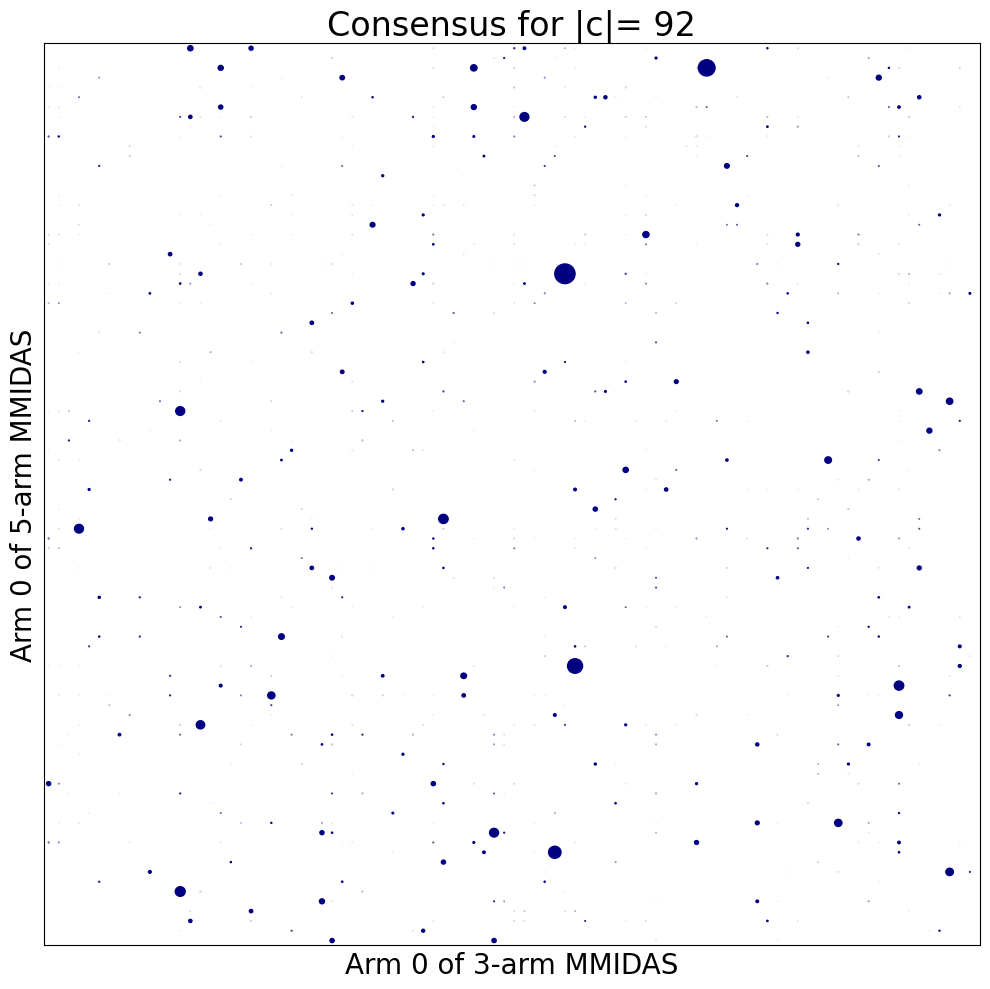

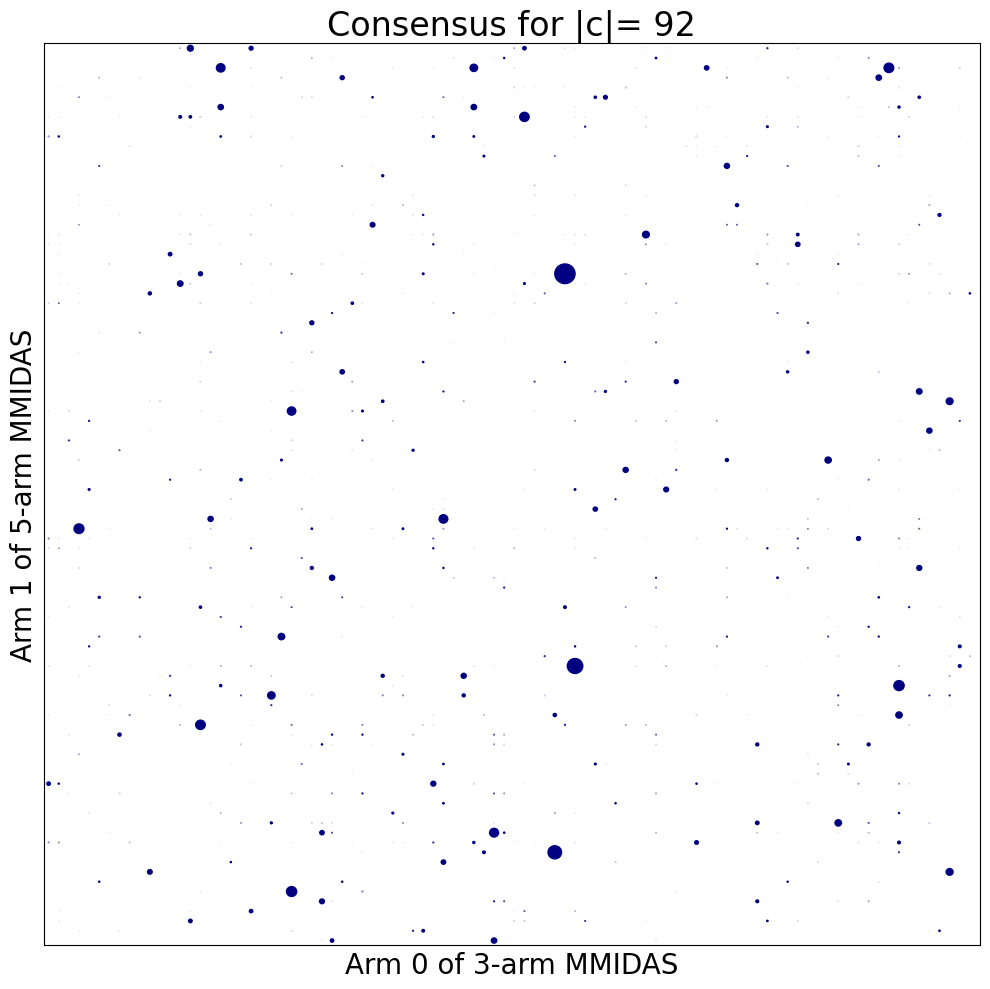

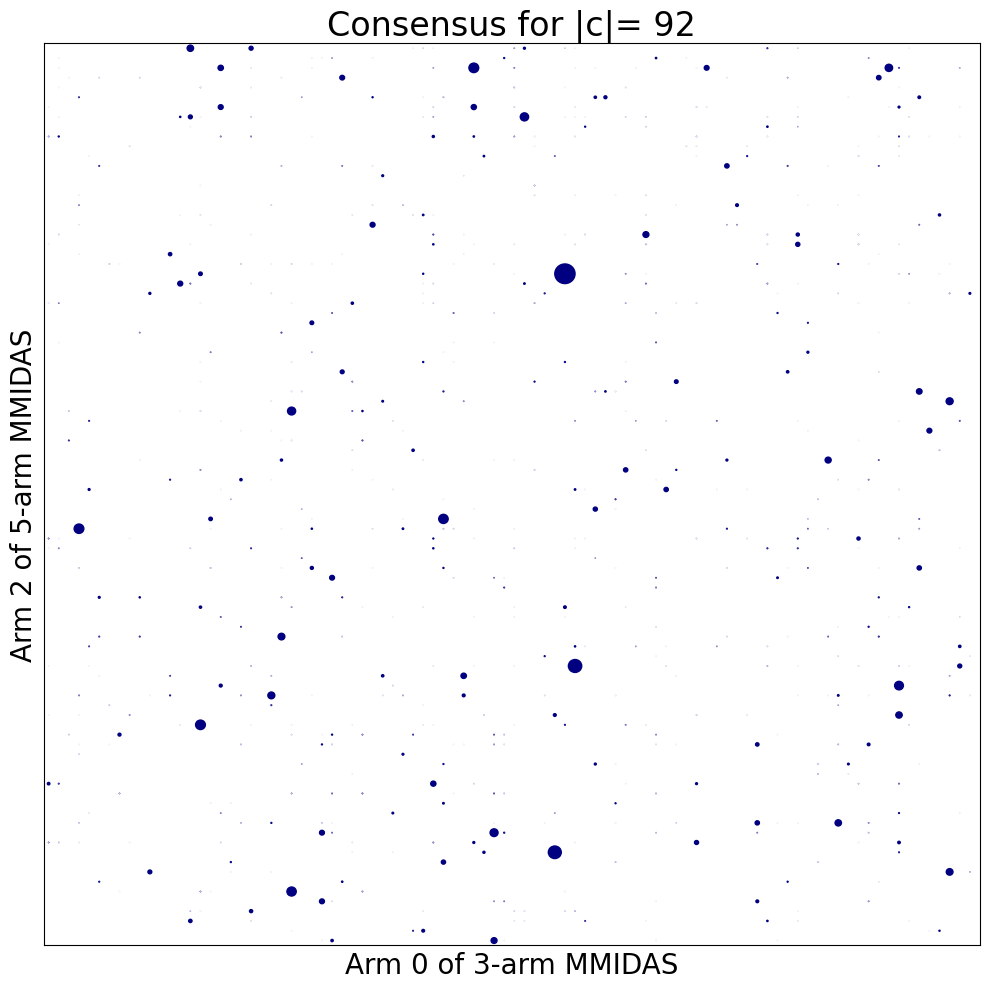

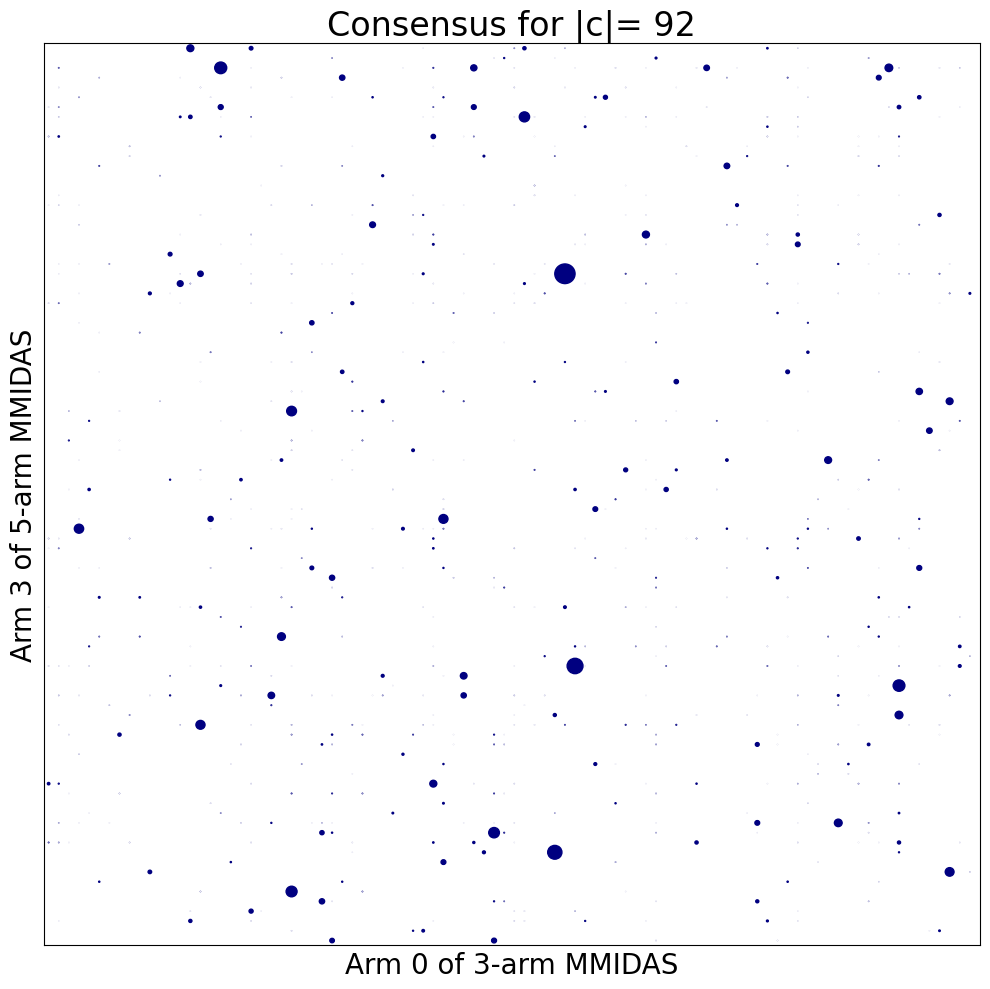

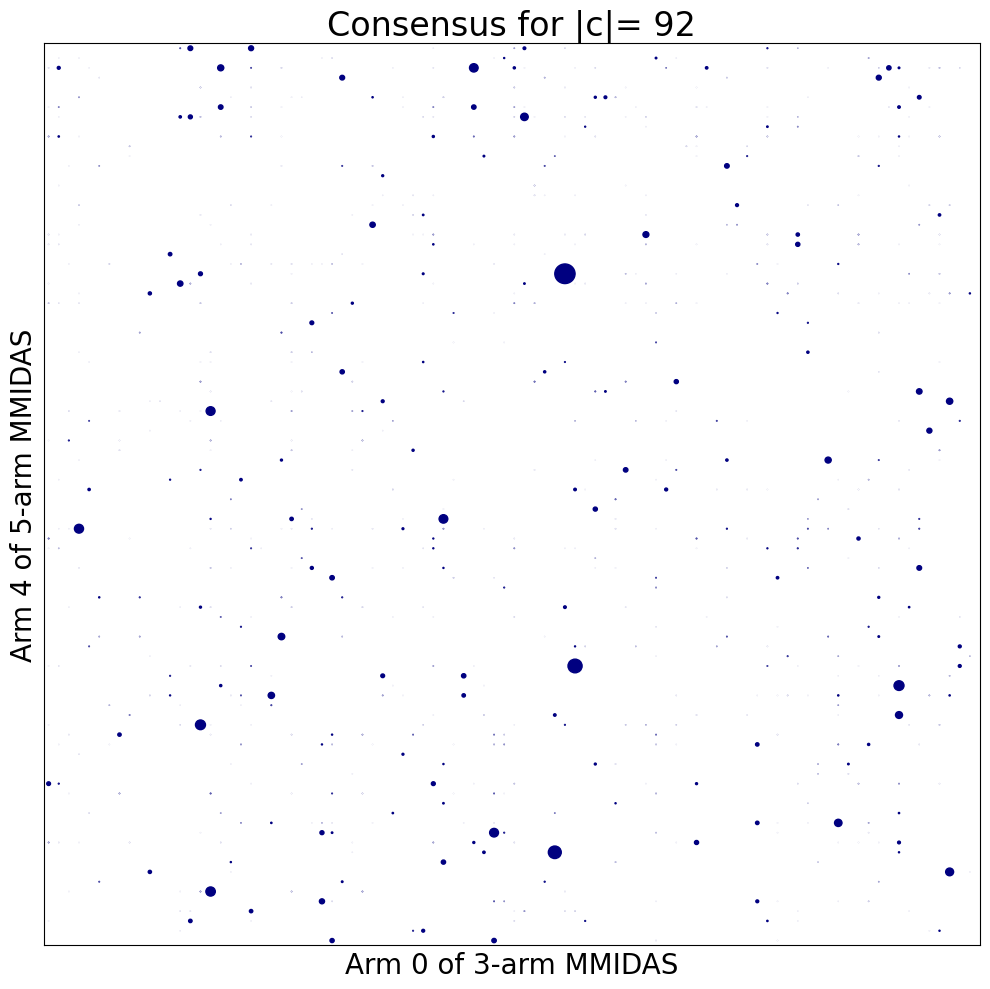

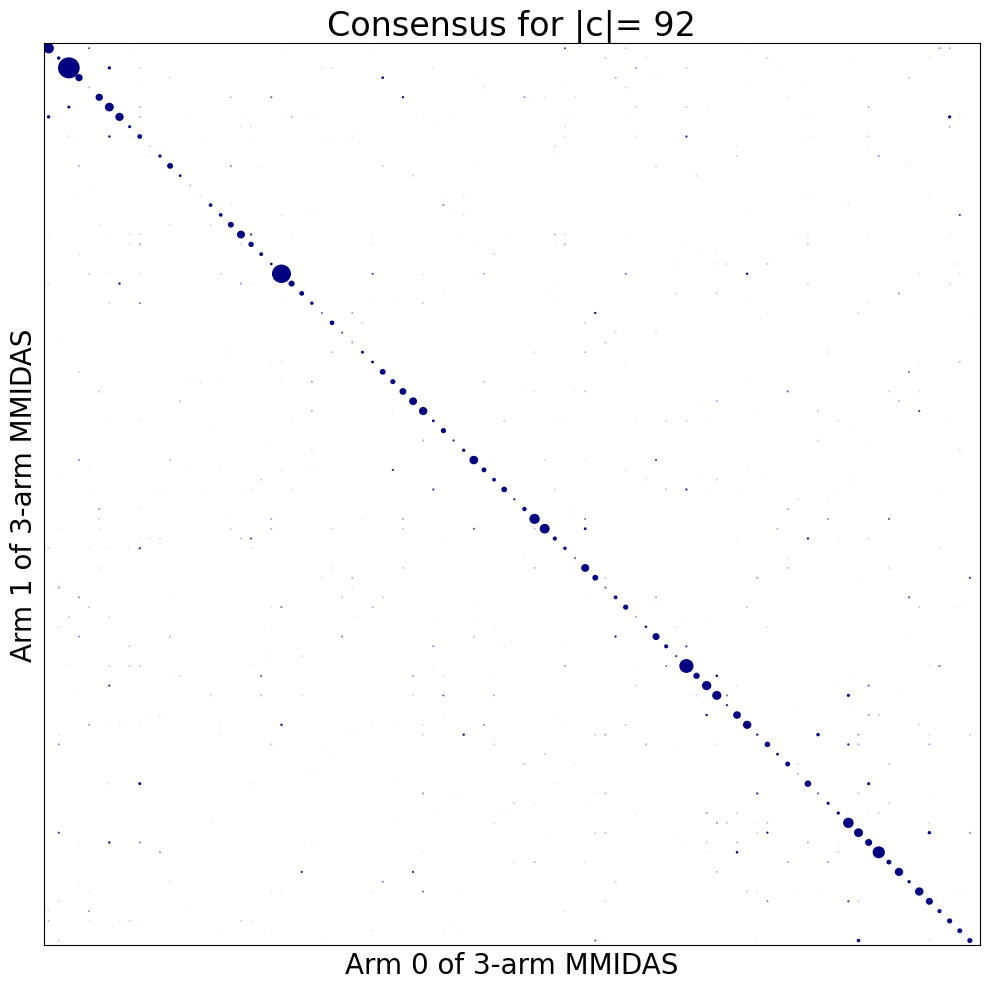

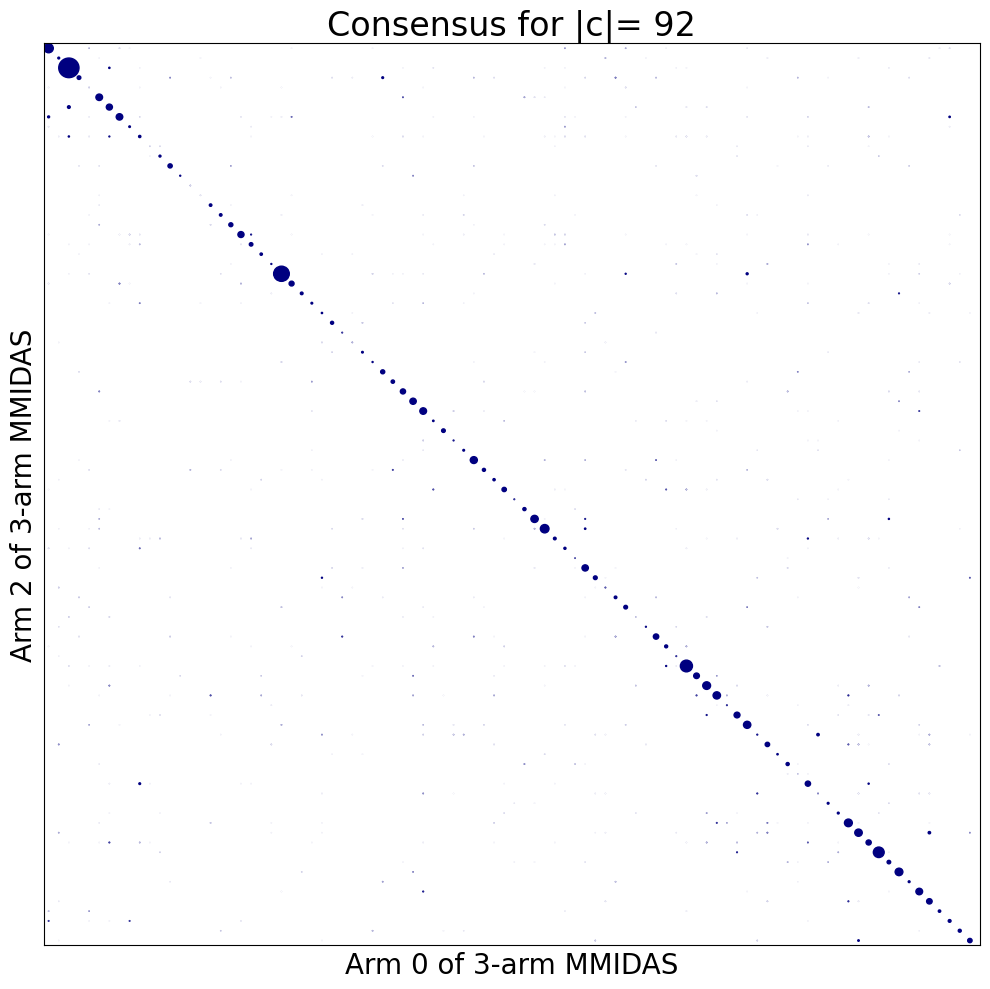

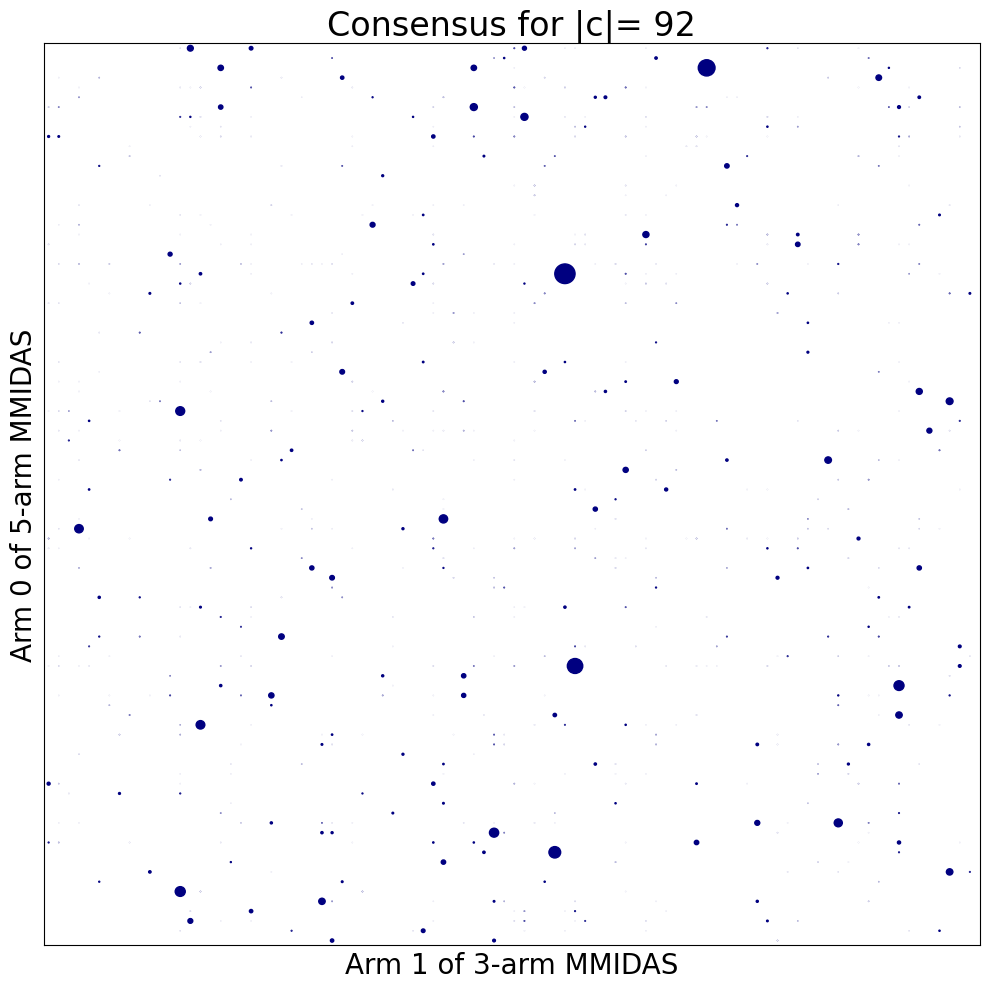

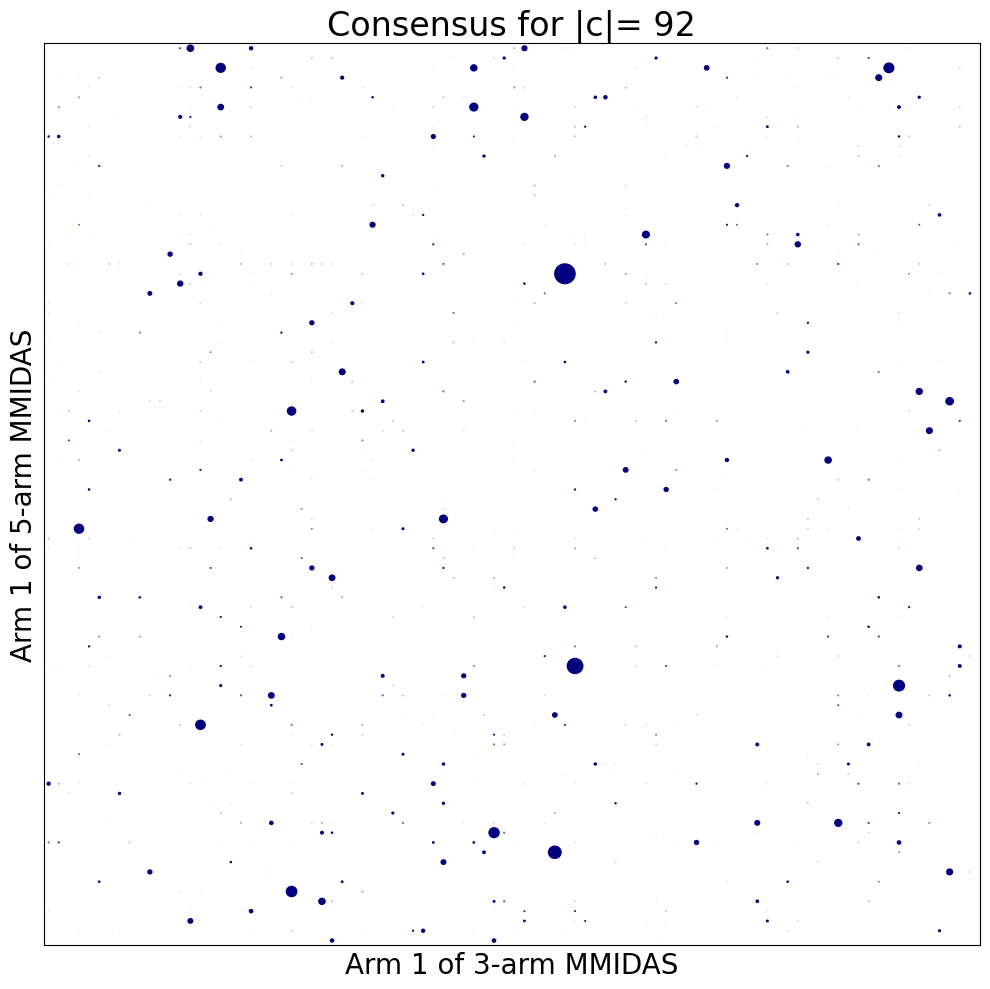

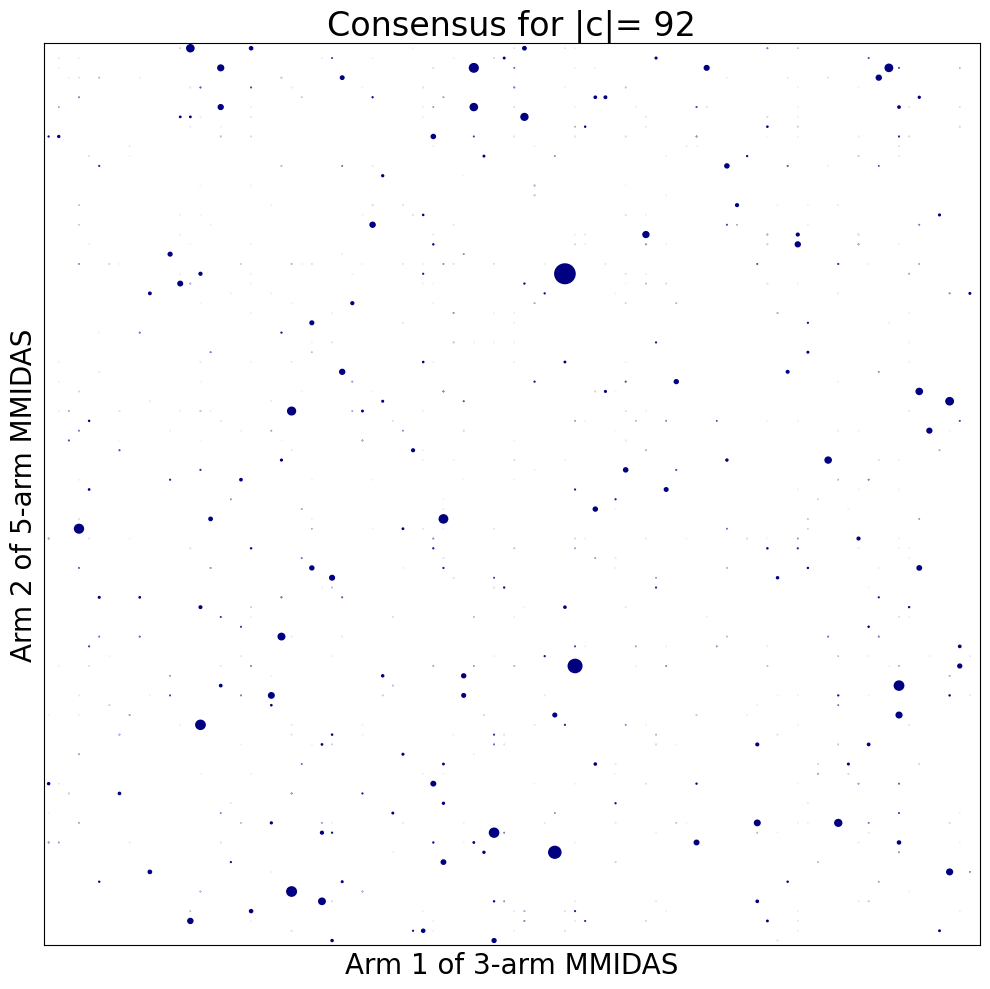

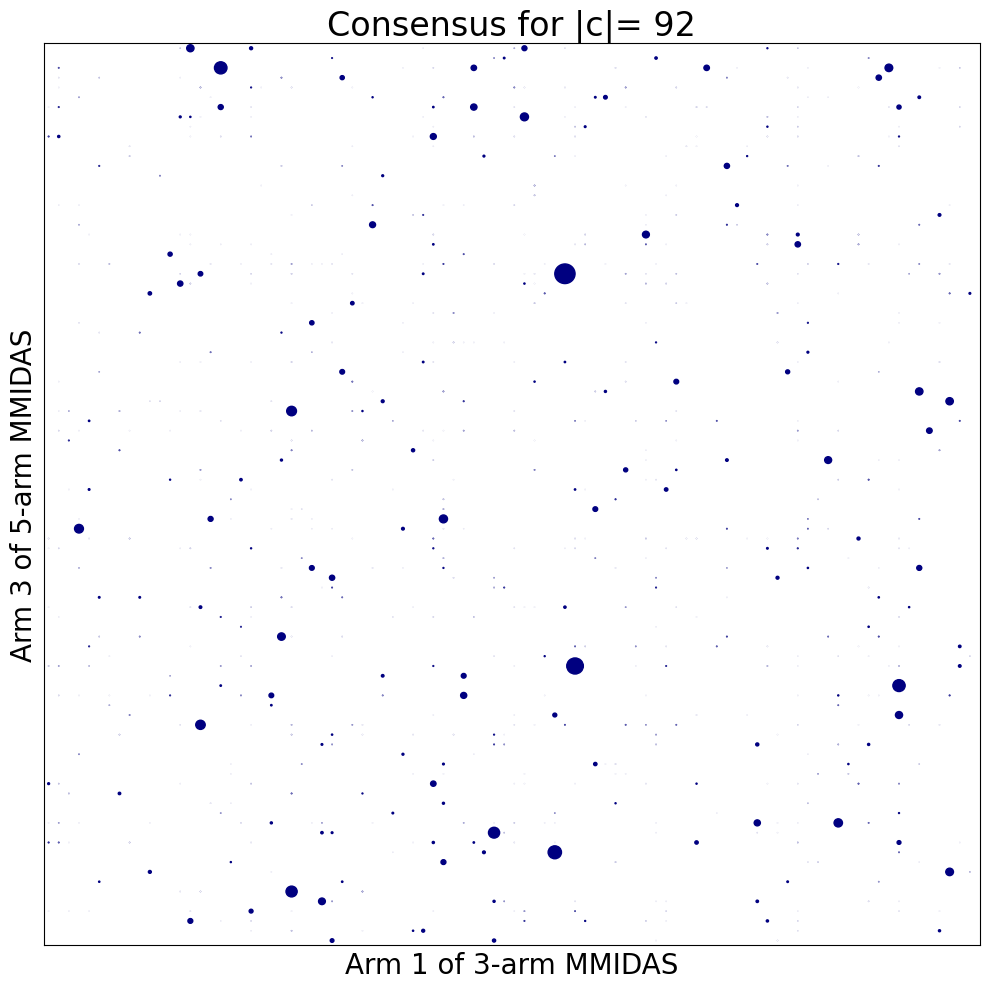

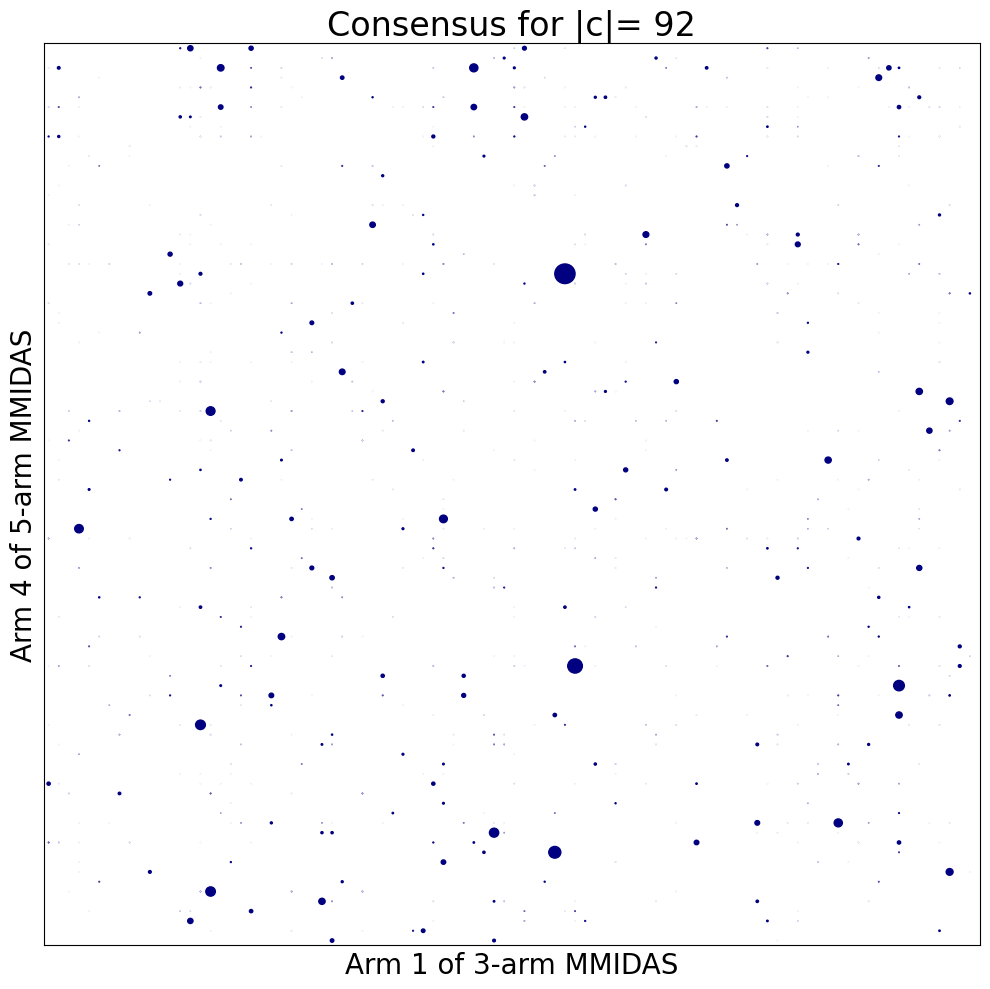

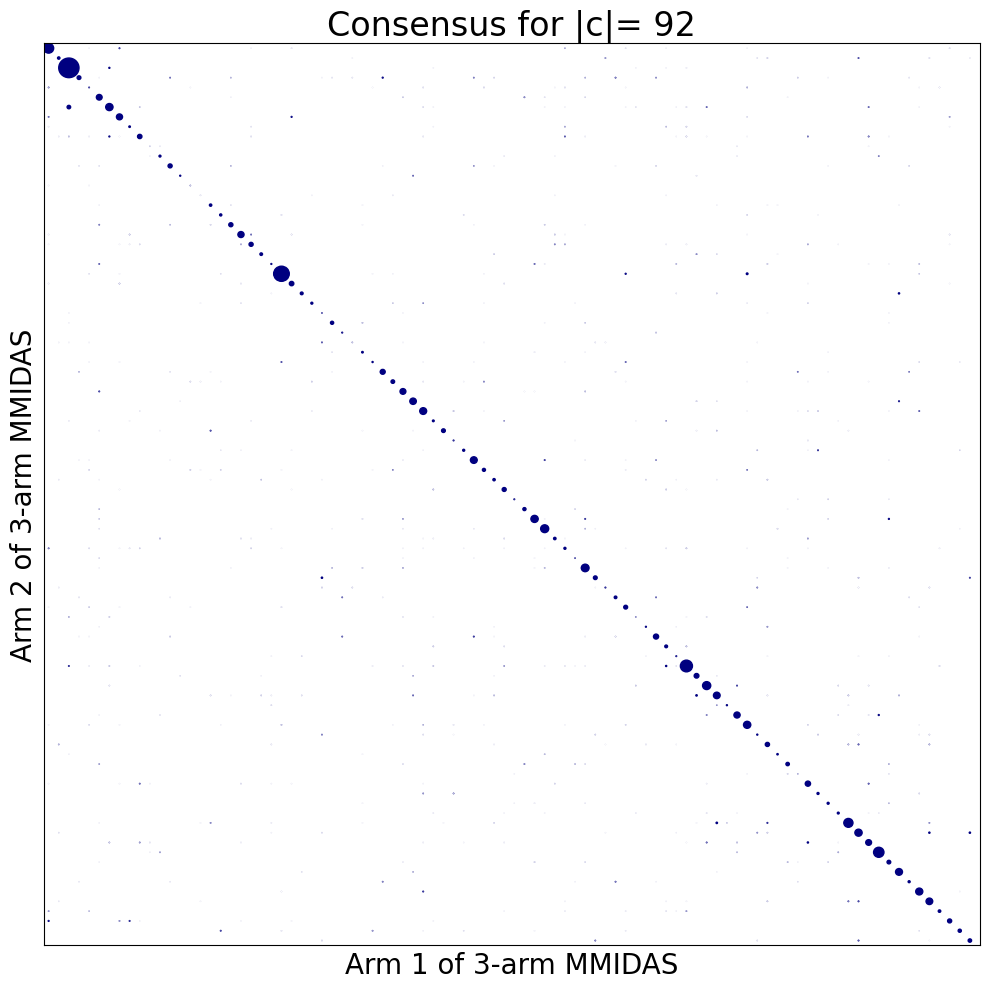

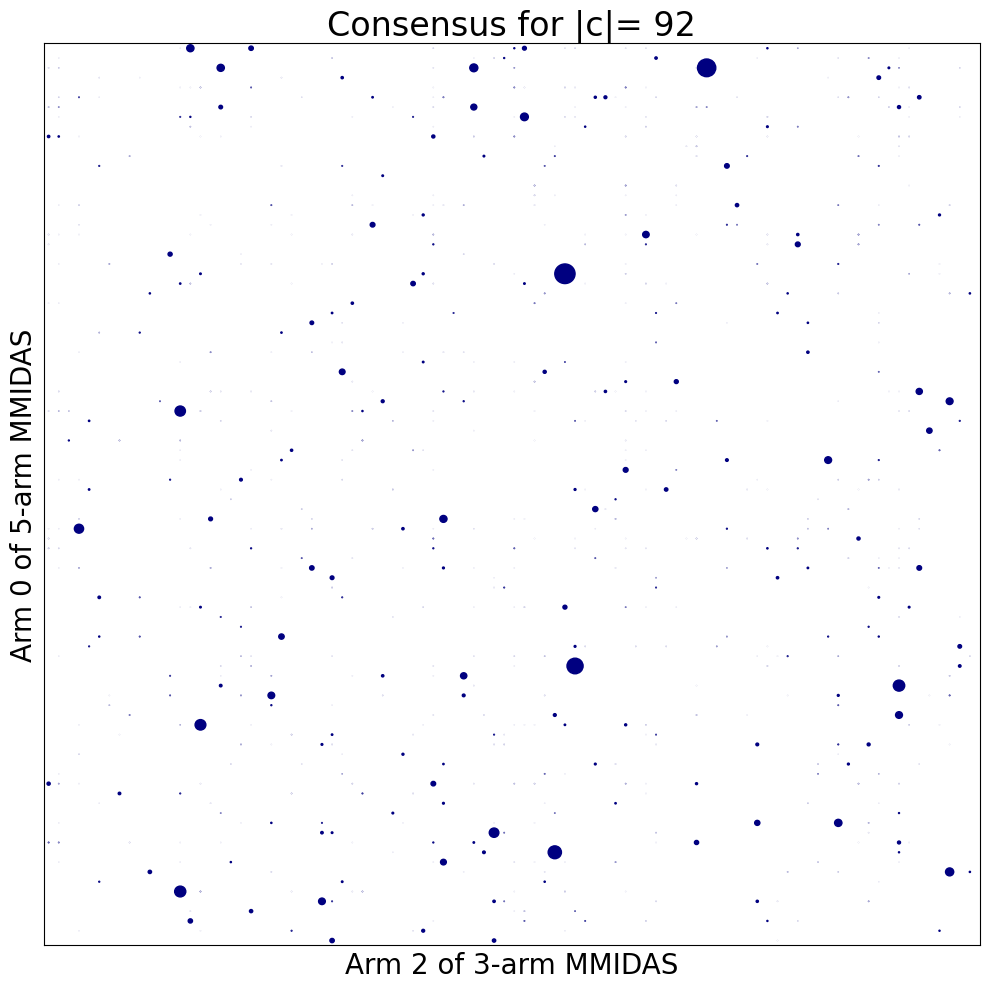

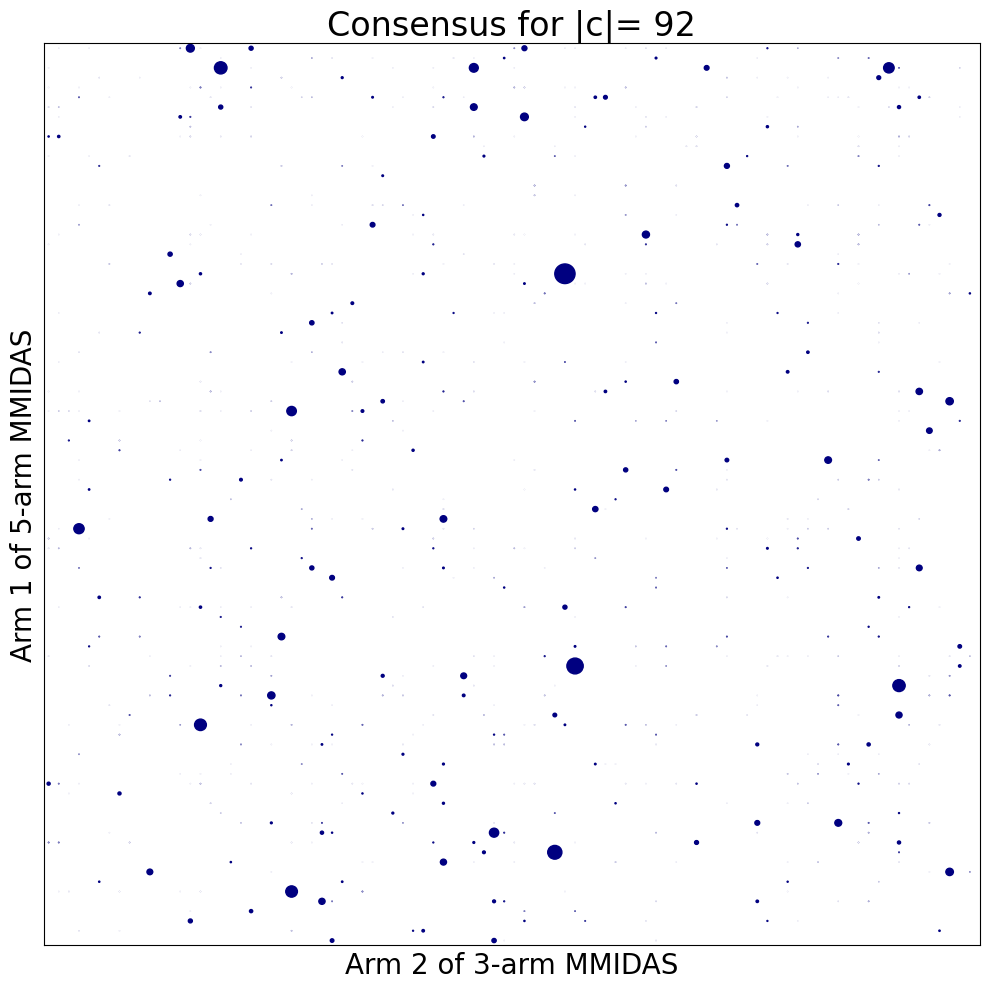

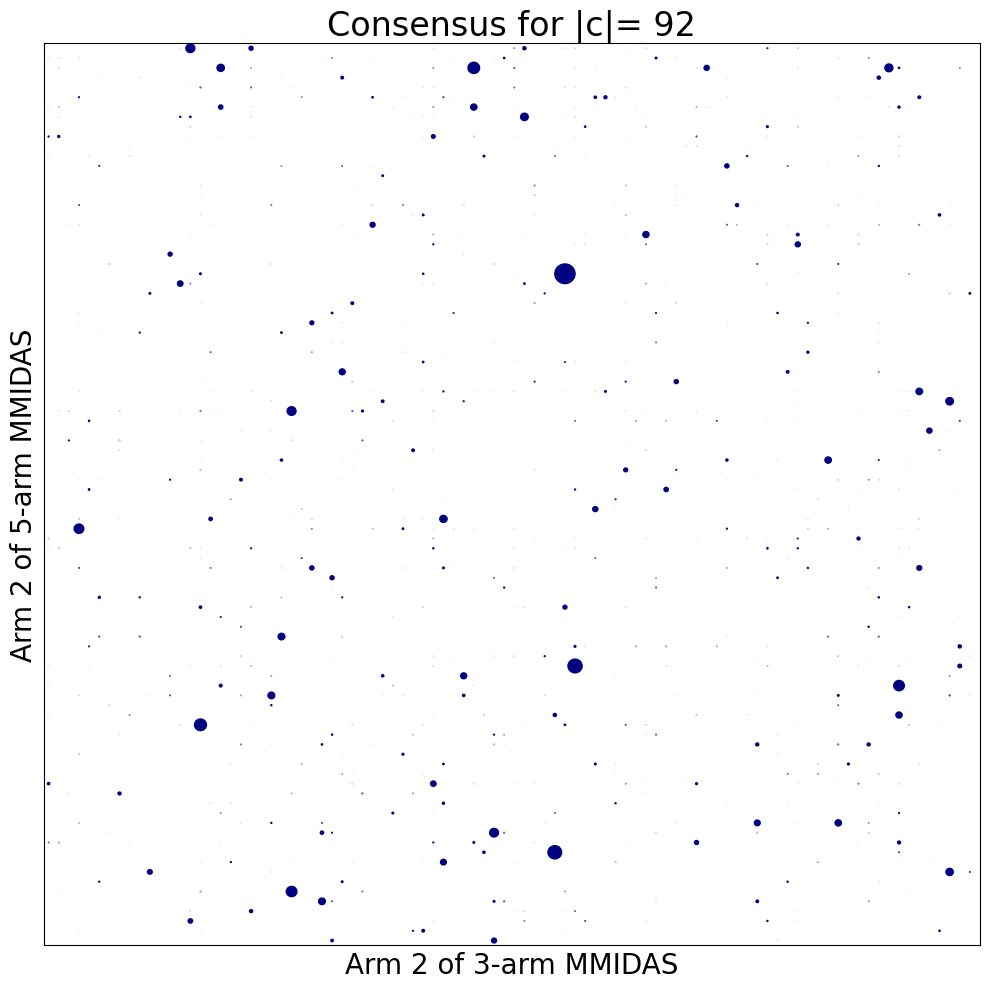

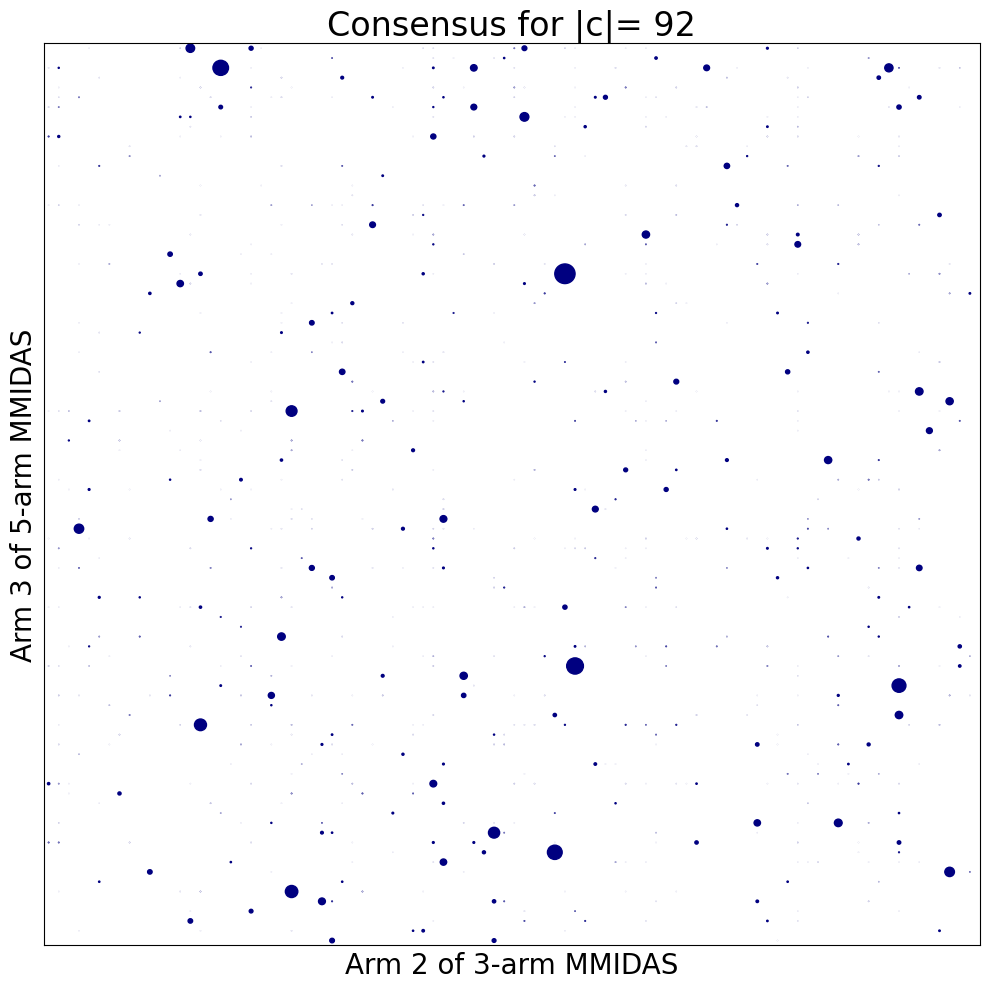

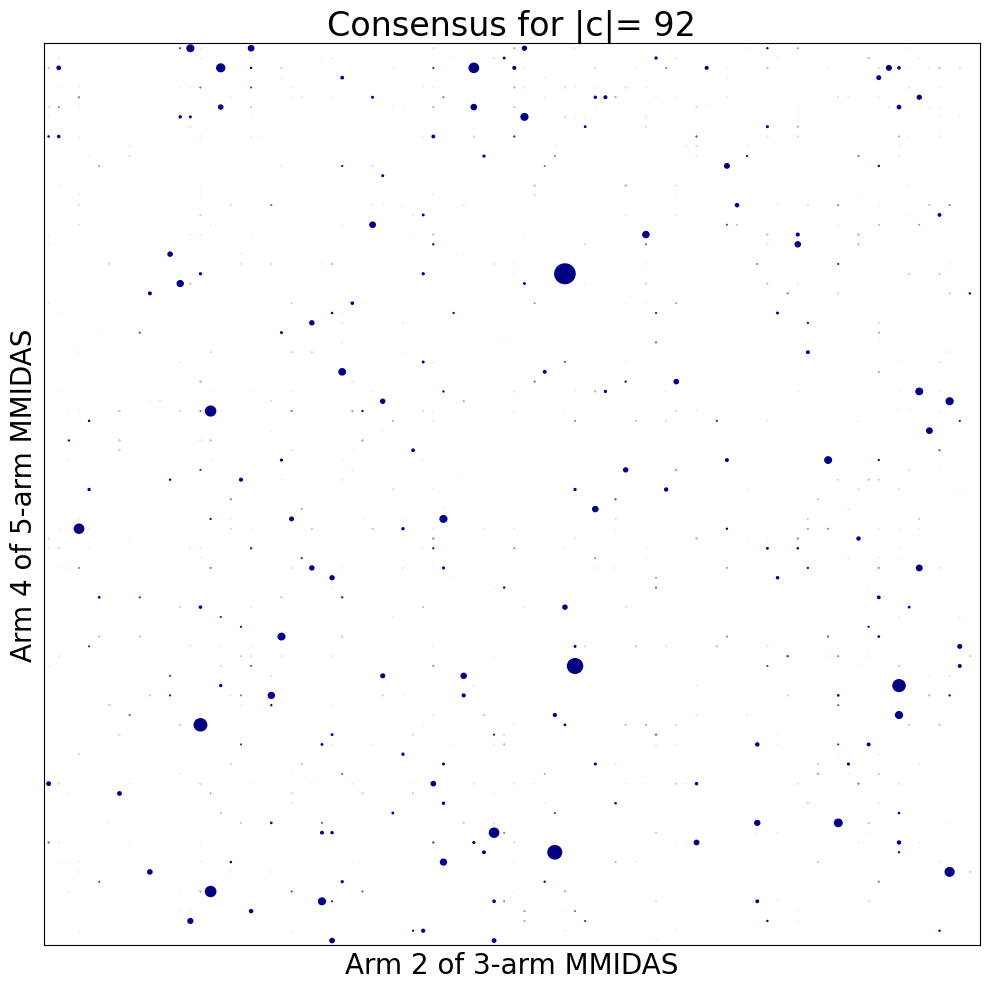

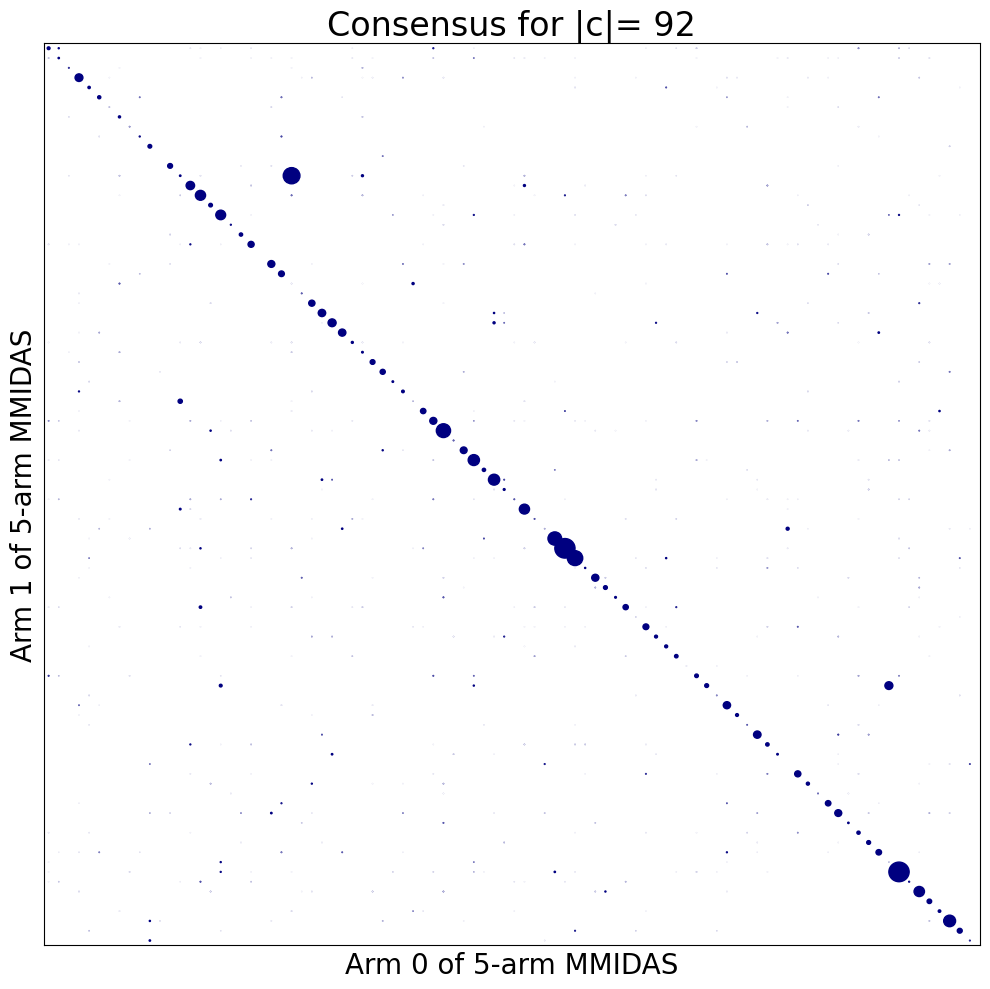

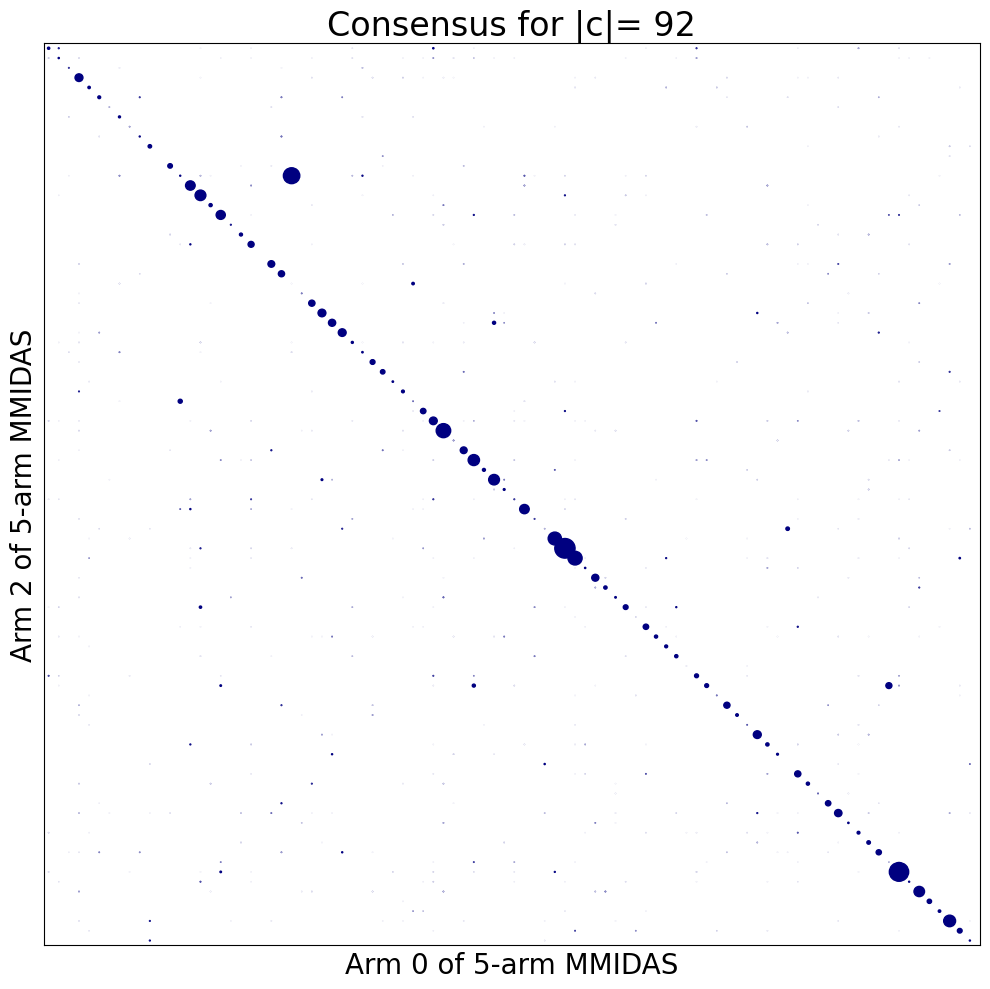

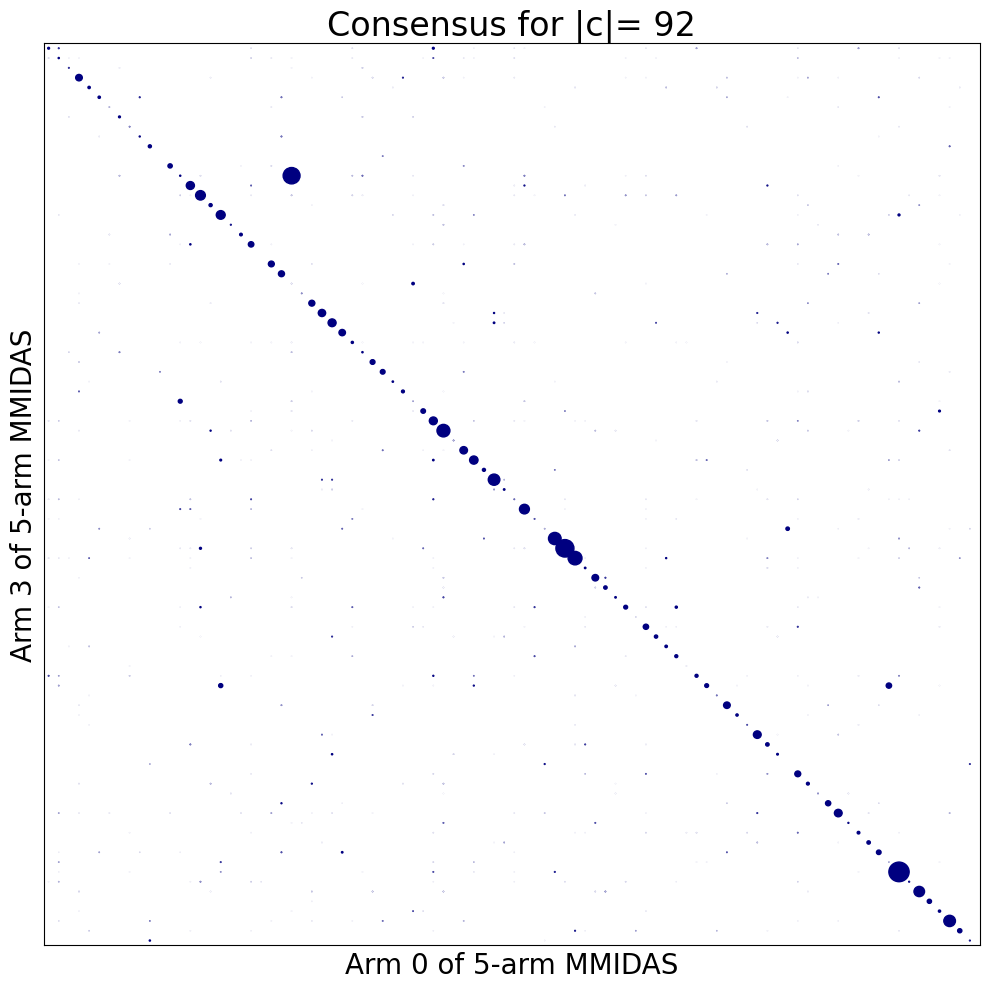

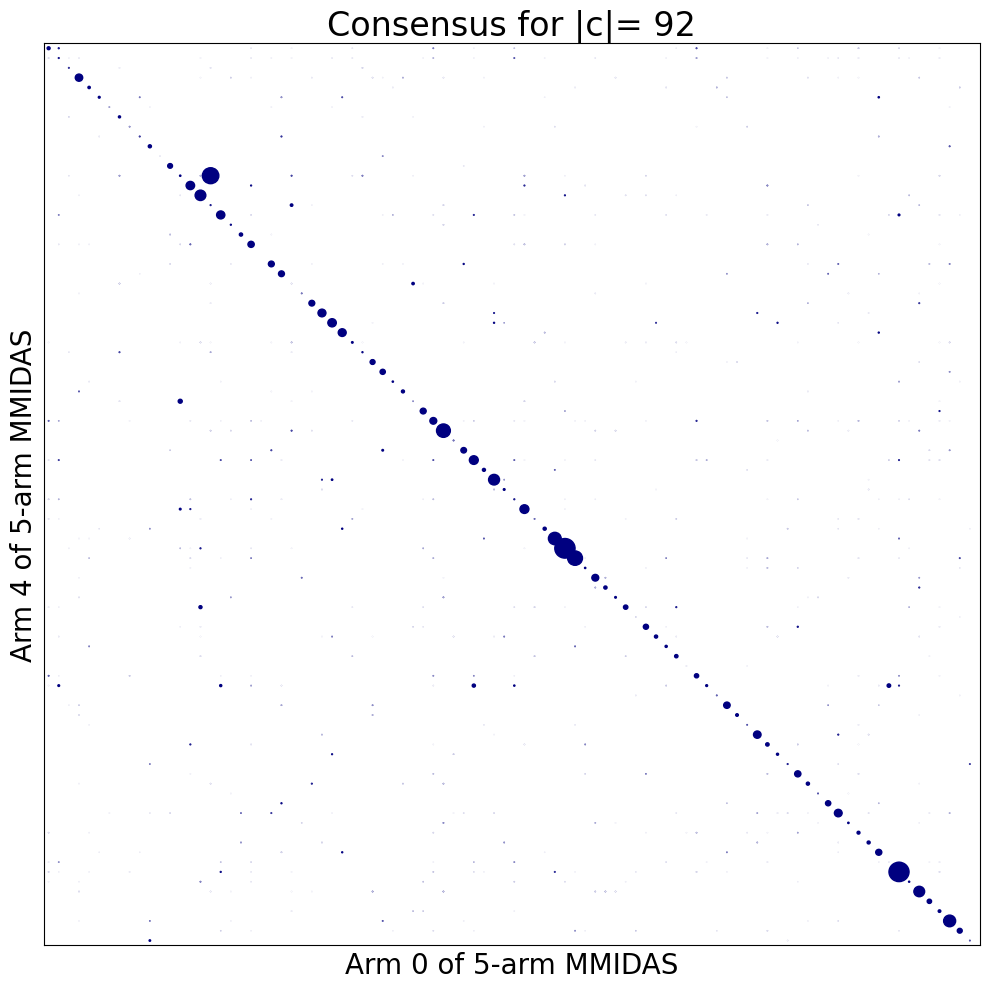

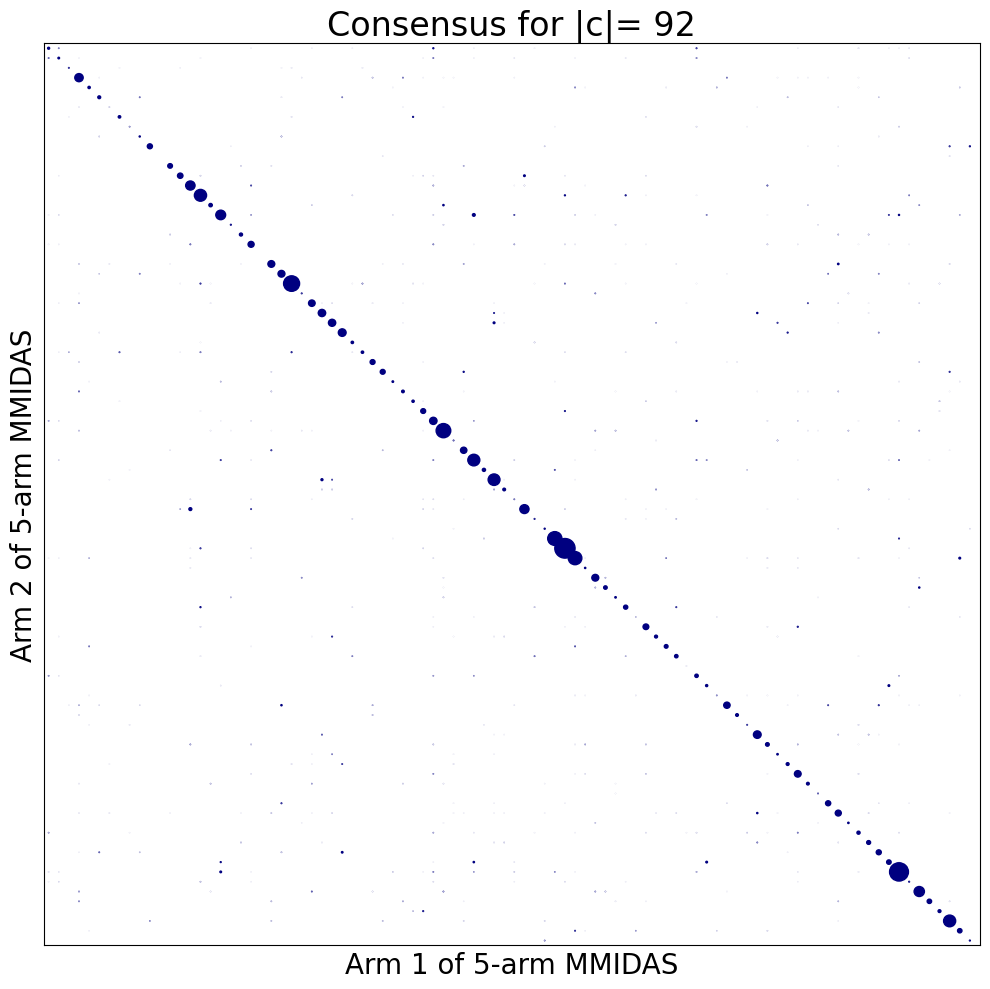

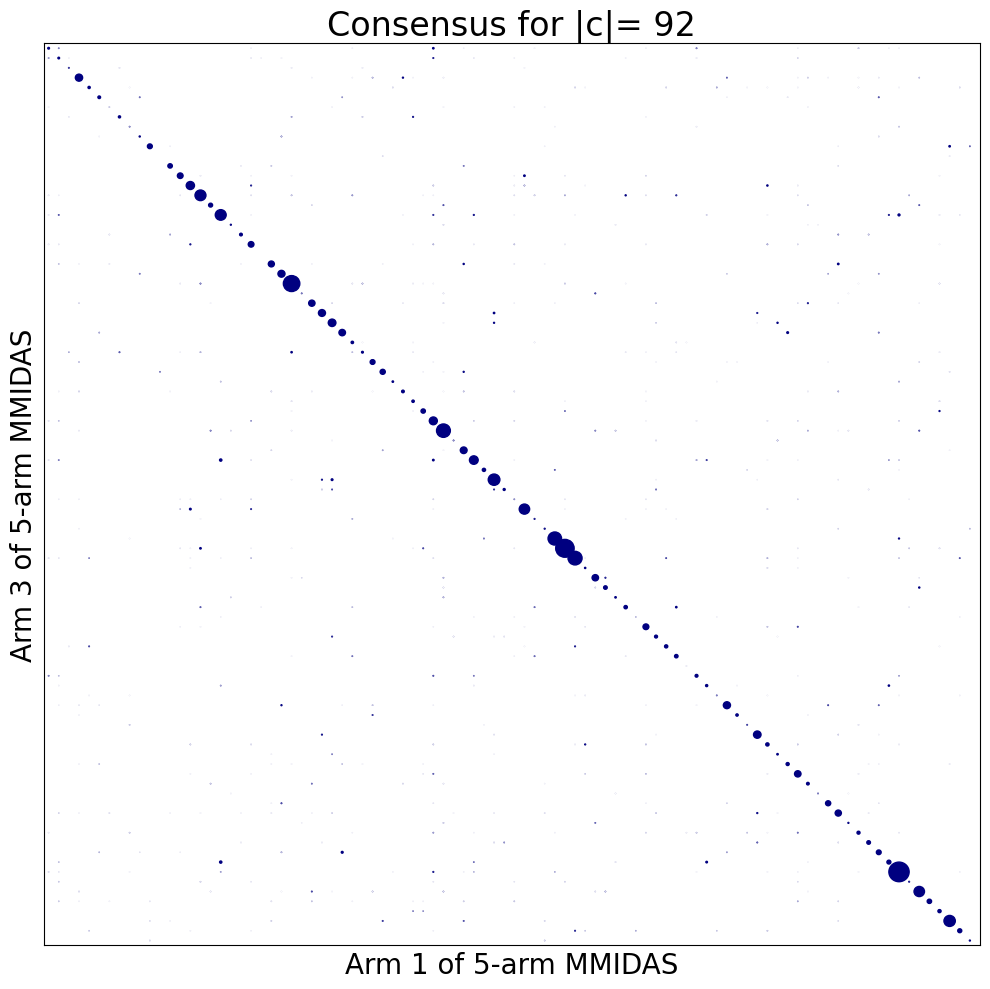

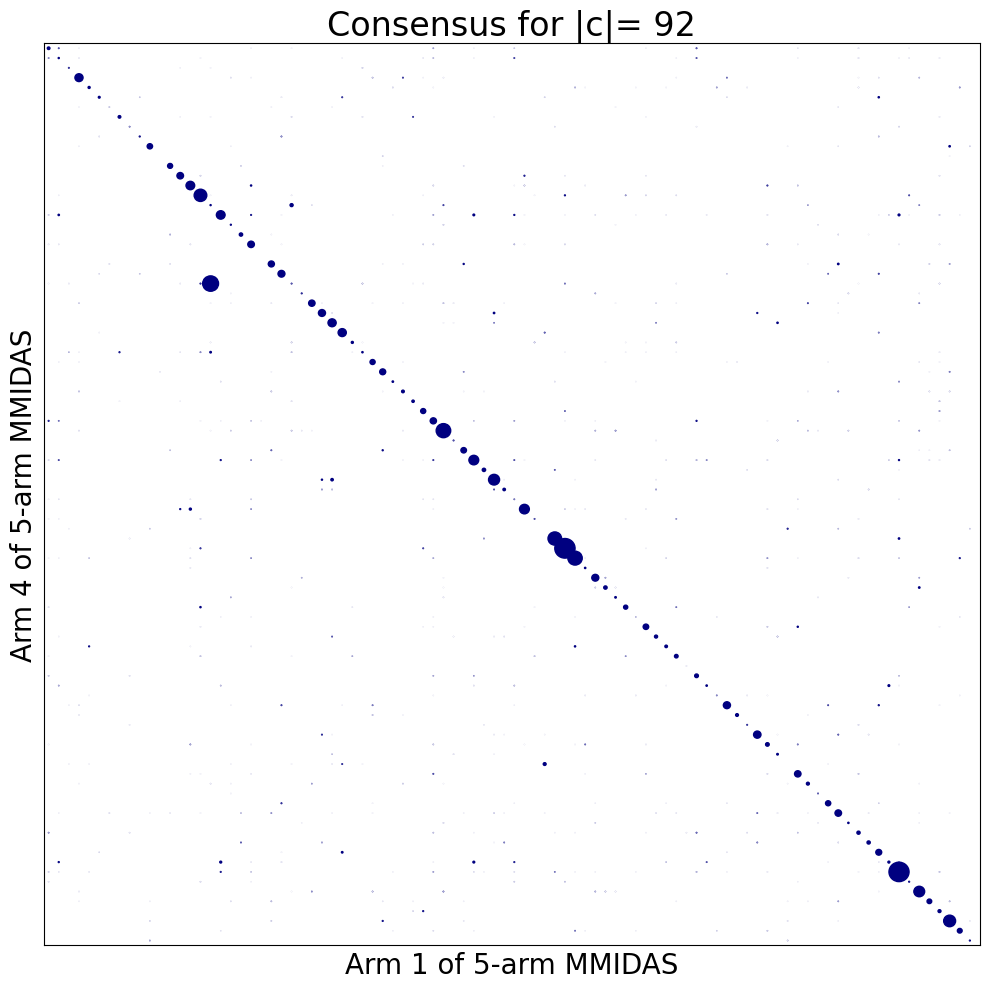

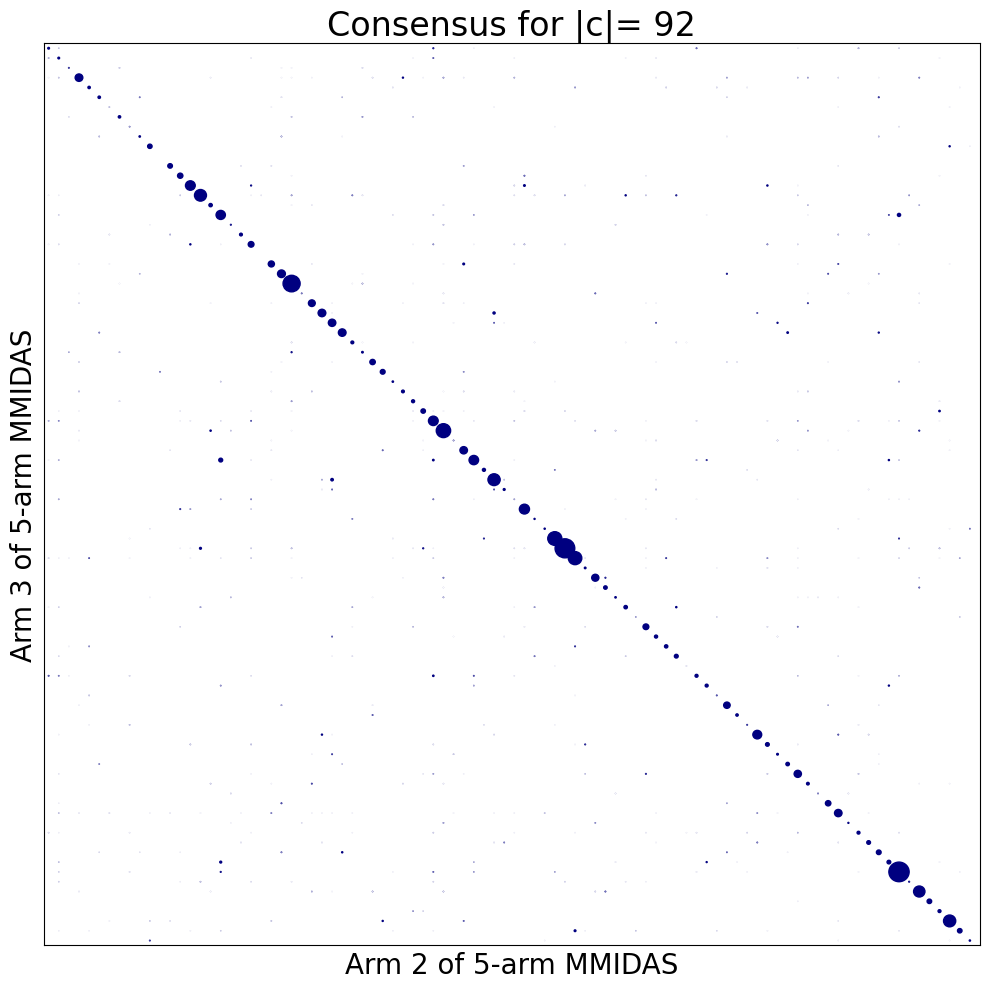

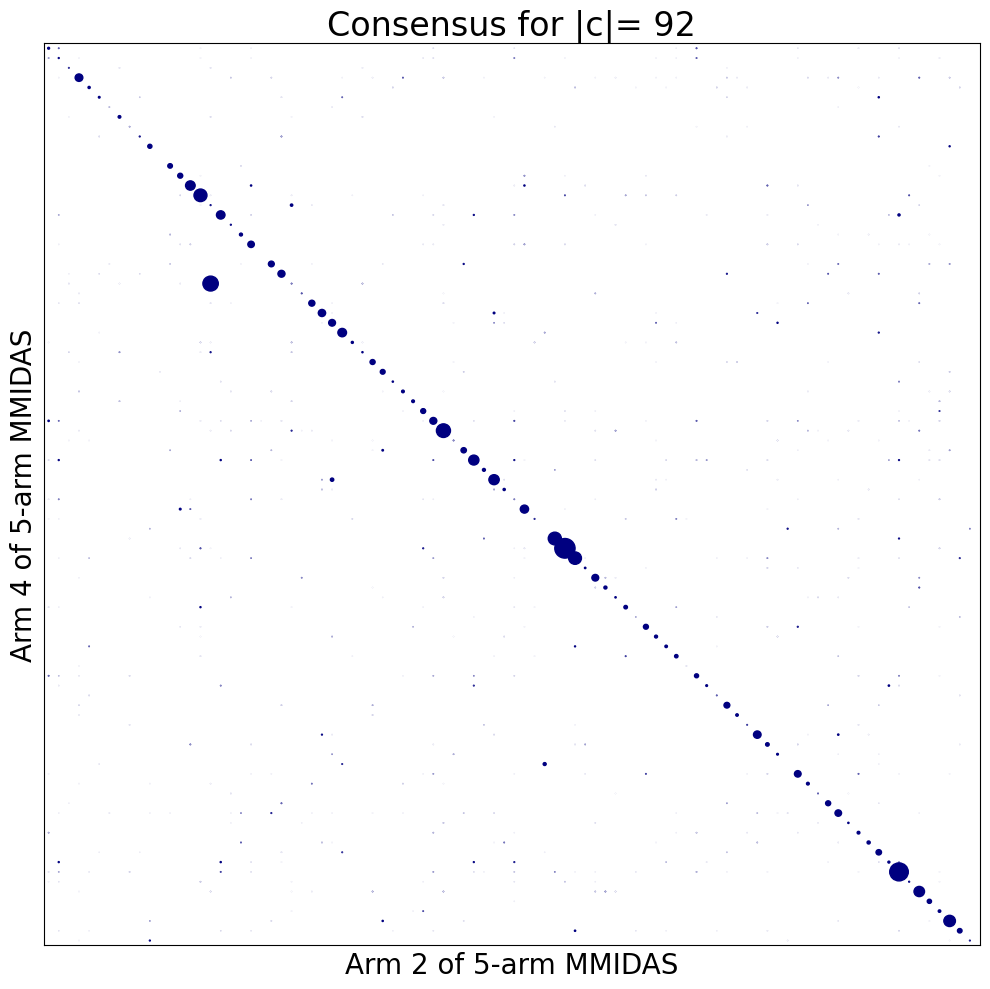

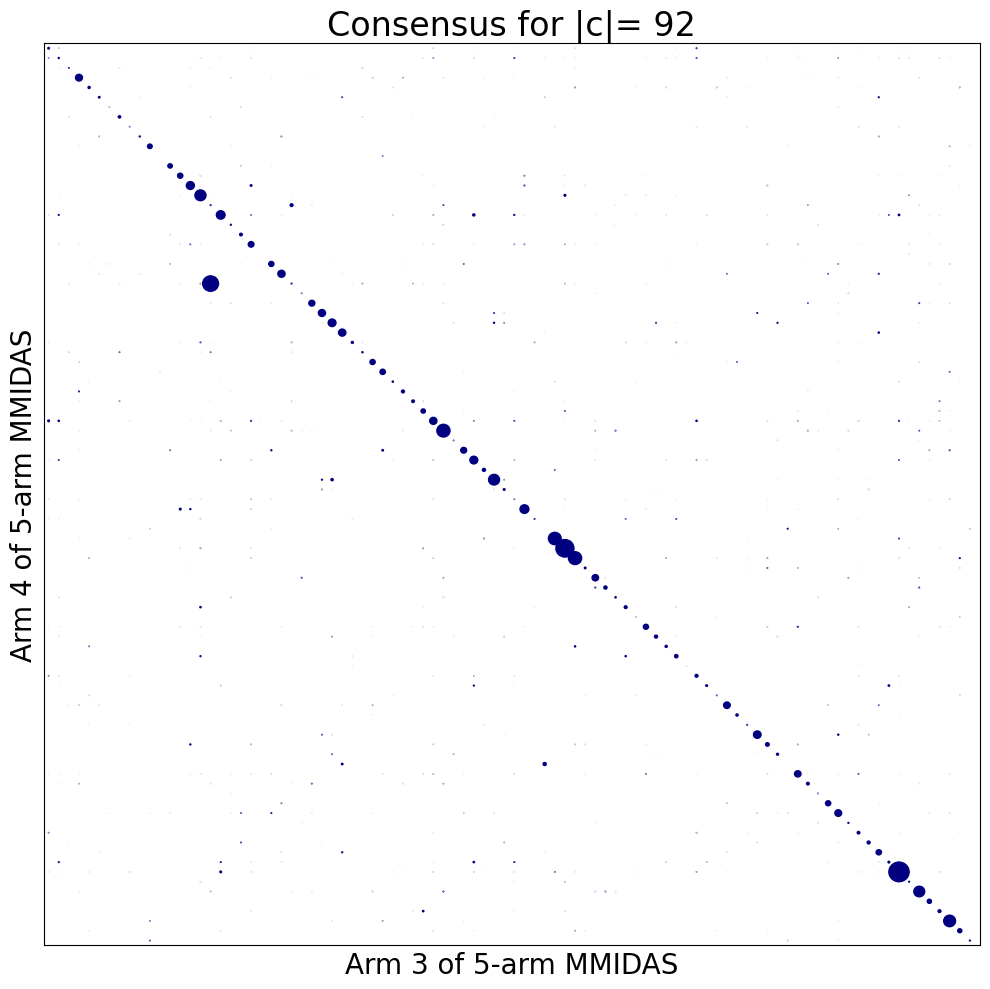

In [8]:
def get_axis(axes: tuple[Arm, Arms, Optional[Run]]) -> str:
    if axes[0] == 'ttypes' and axes[1] == 'ttypes':
        return 'Ttypes classification'
    elif axes[2]:
        return f'Arm {axes[0]} of {axes[1]}-arm MMIDAS, run {axes[2]}'
    else:
        return f'Arm {axes[0]} of {axes[1]}-arm MMIDAS'
    
def get_axis_save(axes: tuple[Arm, Arms, Optional[Run]]) -> str:
    if axes[0] == 'ttypes' and axes[1] == 'ttypes':
        return 'tt'
    elif axes[2]:
        return f'{axes[0]}{axes[1]}{axes[2]}'
    else:
        return f'{axes[0]}{axes[1]}'

def plot_consensus_circ(a_vs_b: np.ndarray, axes: tuple[tuple[Arms, Arm, Optional[Run]], tuple[Arms, Arm, Optional[Run]]], savedir: Optional[str]) -> None:
    assert a_vs_b.shape[0] == a_vs_b.shape[1]

    mtx = a_vs_b / np.max(a_vs_b) 
    C = mtx.shape[0] # number of clusters

    fig, axs = plt.subplots(1, 1, figsize=(10,10))
    for l in trange(C):
        for col in range(C):
            axs.add_patch(plt.Circle(np.array([col, l]), radius=mtx[l, col], color='Navy'))
    axs.set_xlim([-.5, C])
    axs.set_ylim([-.5, C - .5])
    axs.invert_yaxis()
    axs.set_yticks([])
    axs.set_xticks([])
    axs.set_yticklabels([])
    axs.set_xticklabels([])
    plt.title('Consensus for |c|= ' + str(a_vs_b.shape[0]), fontsize=24)
    axs.set_xlabel(get_axis(axes[0]), fontsize=20)
    axs.set_ylabel(get_axis(axes[1]), fontsize=20)
    fig.tight_layout()
    if savedir:
        plt.savefig(savedir + f'/consensus_circ_{get_axis_save(axes[0])}_vs_{get_axis_save(axes[1])}_K{C}.png', dpi=600)

so_far = 0
so_far_a = 0
so_far_b = 0
for a in range(A):
    for b in range(B):
        plot_consensus_circ(ev['pm'][so_far], ((a, A, None), (b, B, None)), f'multiarm-results/{A}{B}')
        so_far += 1

    for b in range(a + 1, A):
        plot_consensus_circ(ev['pm_a'][so_far_a], ((a, A, None), (b, A, None)), f'multiarm-results/{A}{B}')
        so_far_a += 1

for a in range(B):
    for b in range(a + 1, B):
        plot_consensus_circ(ev['pm_b'][so_far_b], ((a, B, None), (b, B, None)), f'multiarm-results/{A}{B}')
        so_far_b += 1

avg consensus on test cells: 0.0005667980177853197
avg consensus on test cells: 0.0008427004212275304
avg consensus on test cells: 0.0002825620019109319
avg consensus on test cells: 0.0005998030396365143
avg consensus on test cells: 0.00028298851811100307
avg consensus on test cells: 0.68114642926107
avg consensus on test cells: 0.6892397606318034
avg consensus on test cells: 0.0006175399993882111
avg consensus on test cells: 0.001115178618814219
avg consensus on test cells: 0.0004273452921804647
avg consensus on test cells: 0.0007807855092856406
avg consensus on test cells: 0.0002347712143058212
avg consensus on test cells: 0.6892250156863714
avg consensus on test cells: 0.0007366713762696794
avg consensus on test cells: 0.0015406221192603138
avg consensus on test cells: 0.0009725045105874899
avg consensus on test cells: 0.0012813683069130633
avg consensus on test cells: 0.0006362048705424344
avg consensus on test cells: 0.6256207085029561
avg consensus on test cells: 0.64147920980126

/tmp/ipykernel_85449/3742250029.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=[10,10])


avg consensus on test cells: 0.6146377942599142
avg consensus on test cells: 0.6327771373212991
avg consensus on test cells: 0.6913494684093769
avg consensus on test cells: 0.661812446054163
avg consensus on test cells: 0.636478413387159
avg consensus on test cells: 0.6760009778089376
avg consensus on test cells: 0.6471094723160761
avg consensus on test cells: 0.6281596364858695


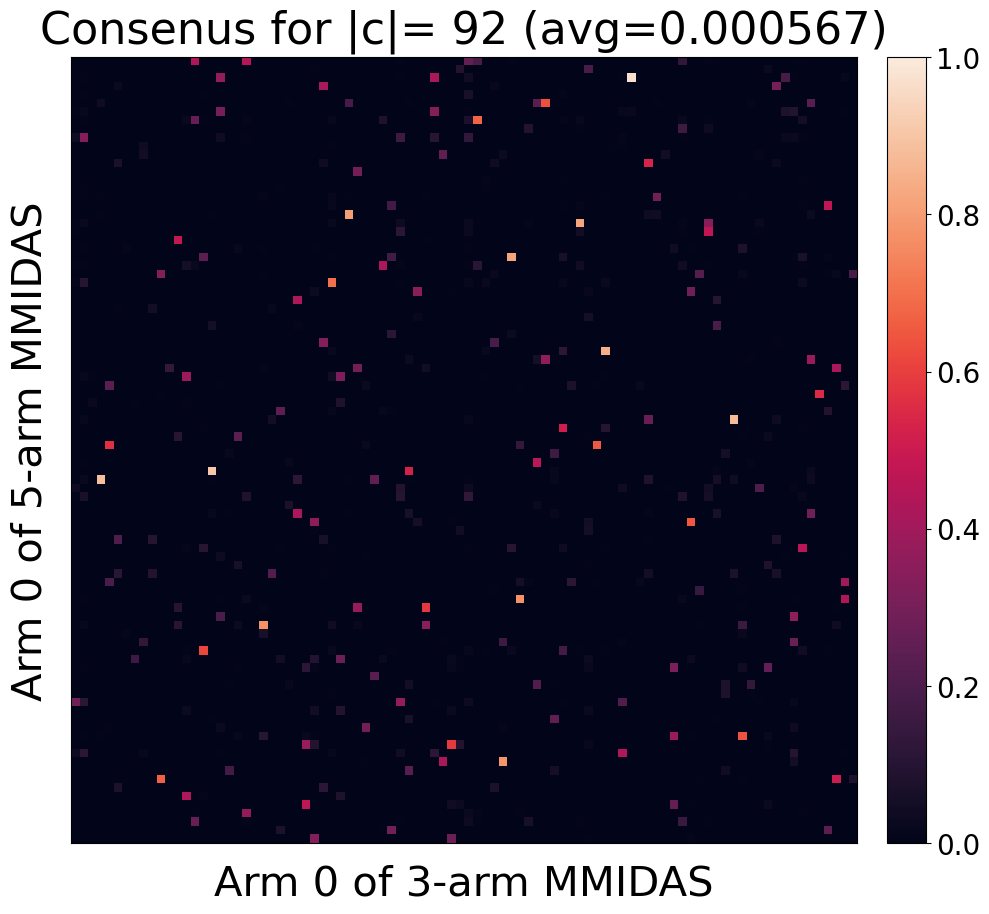

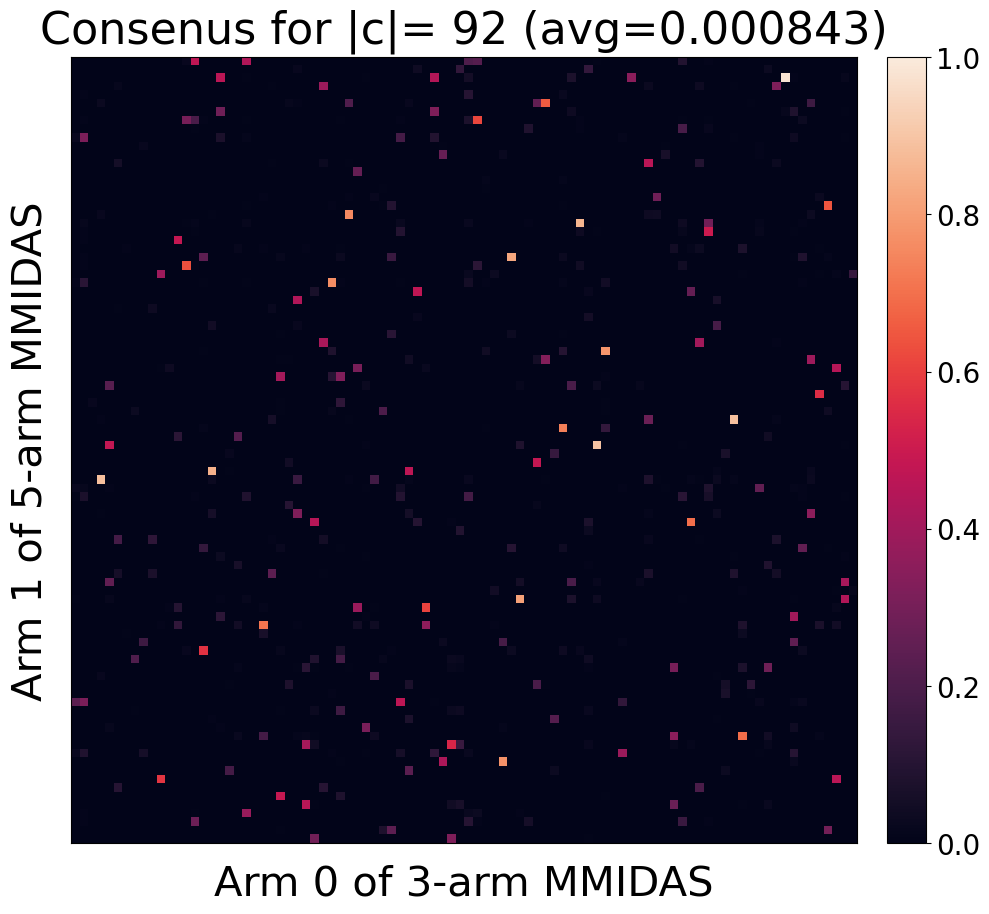

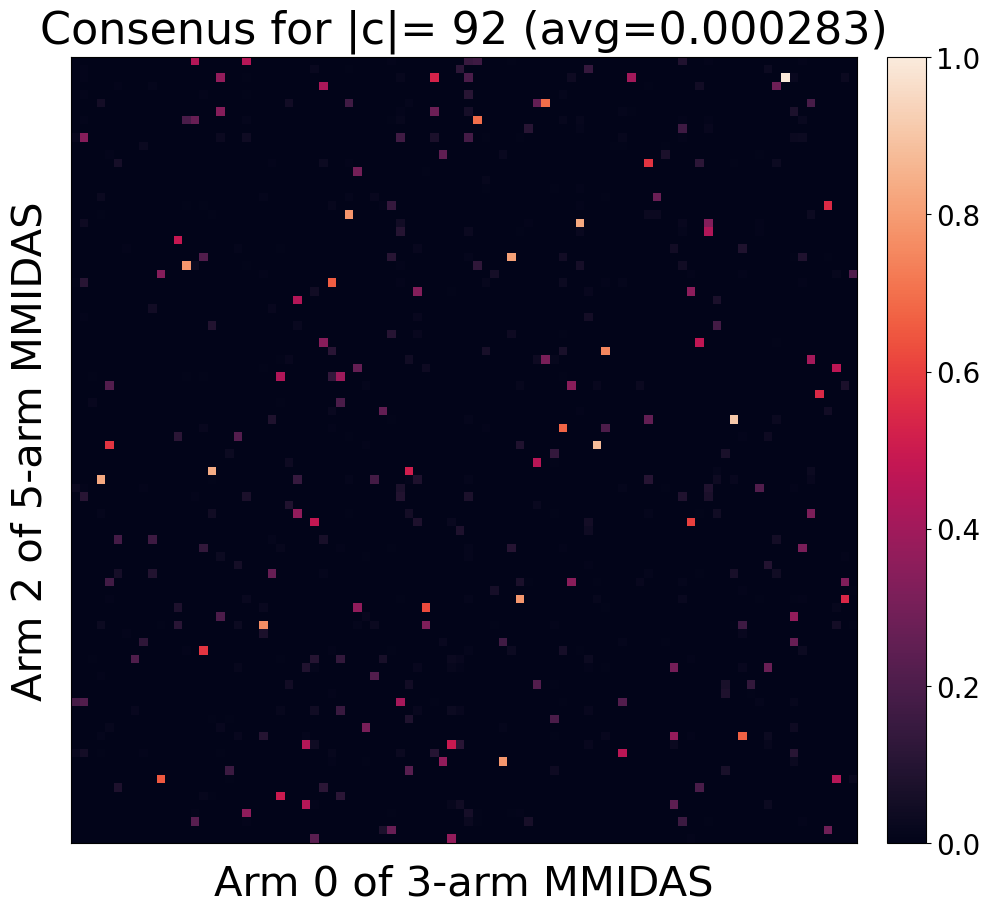

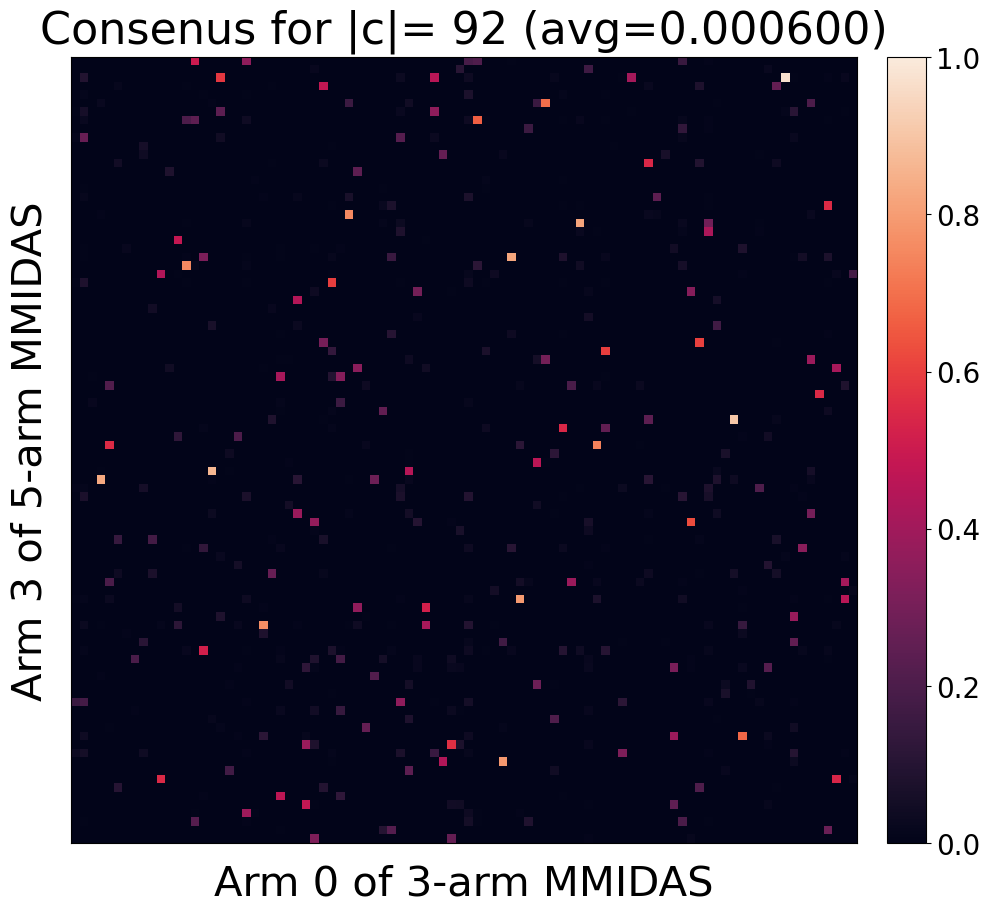

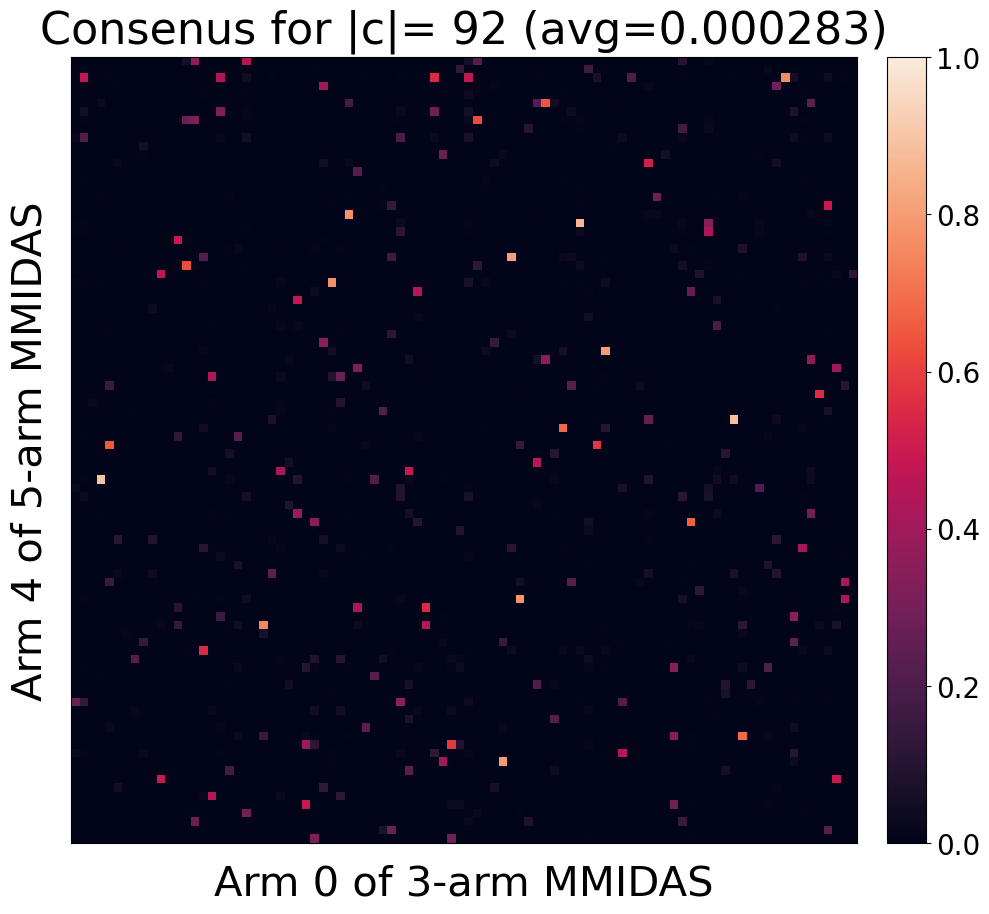

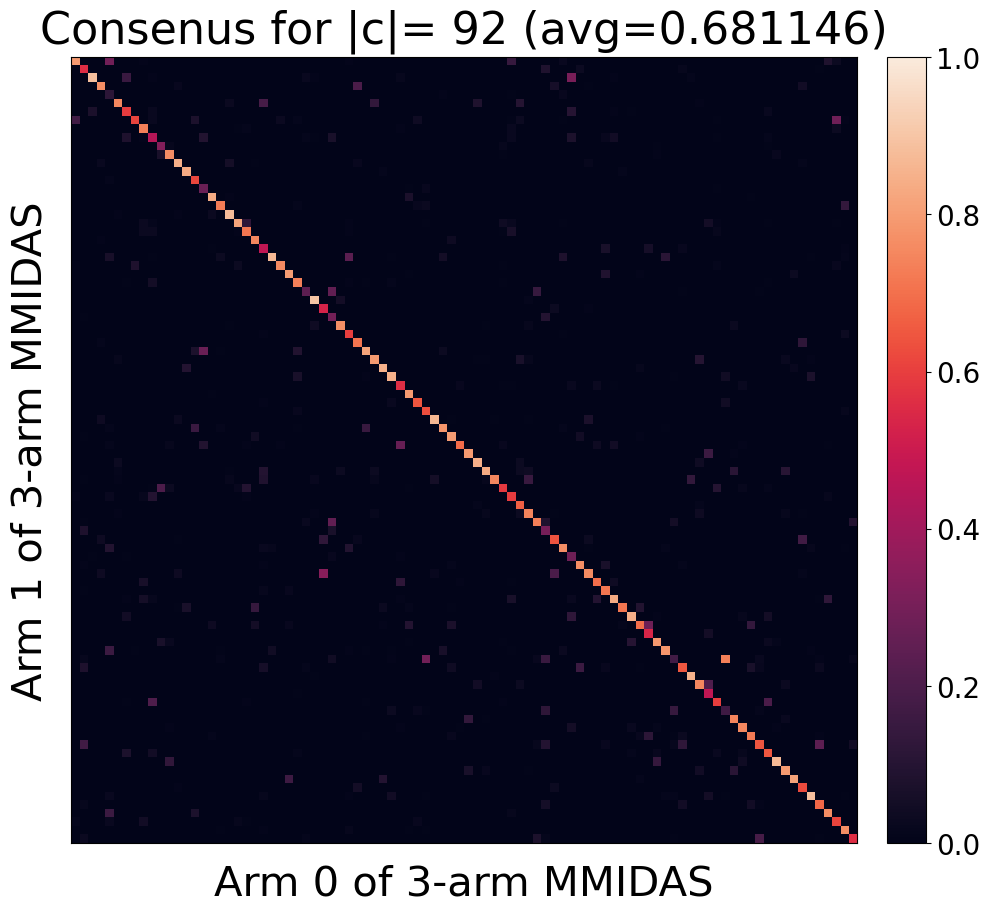

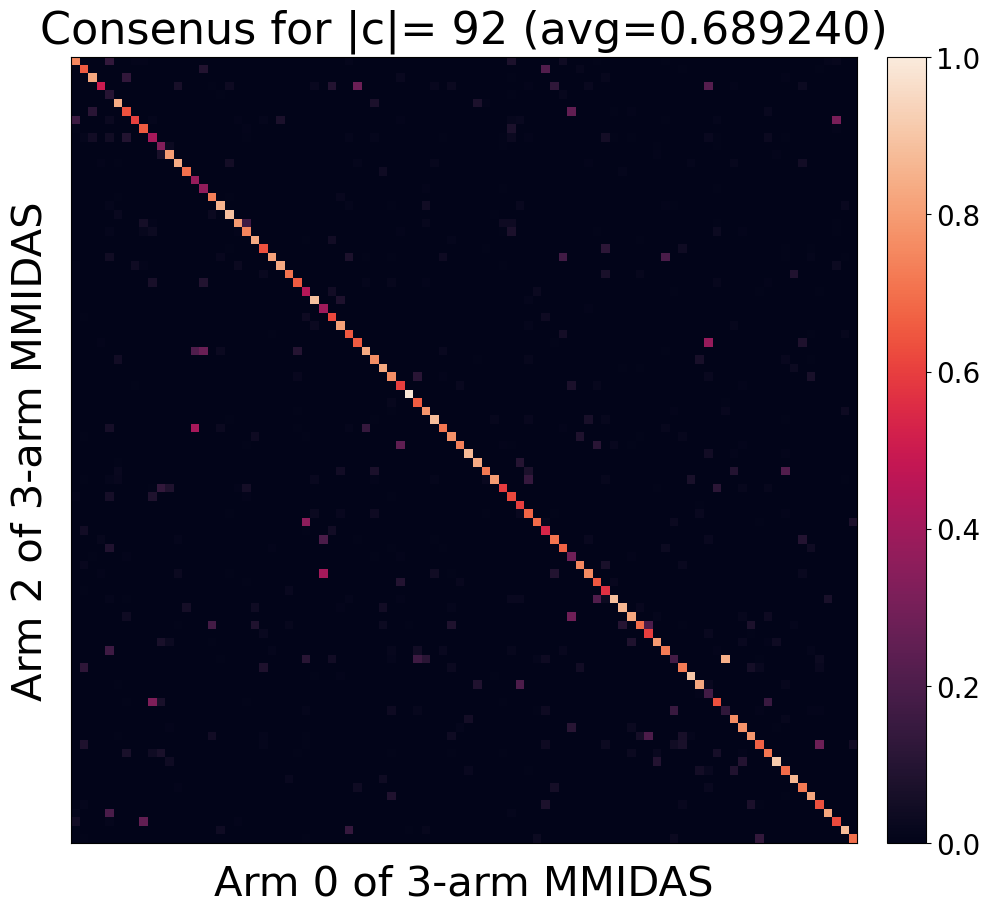

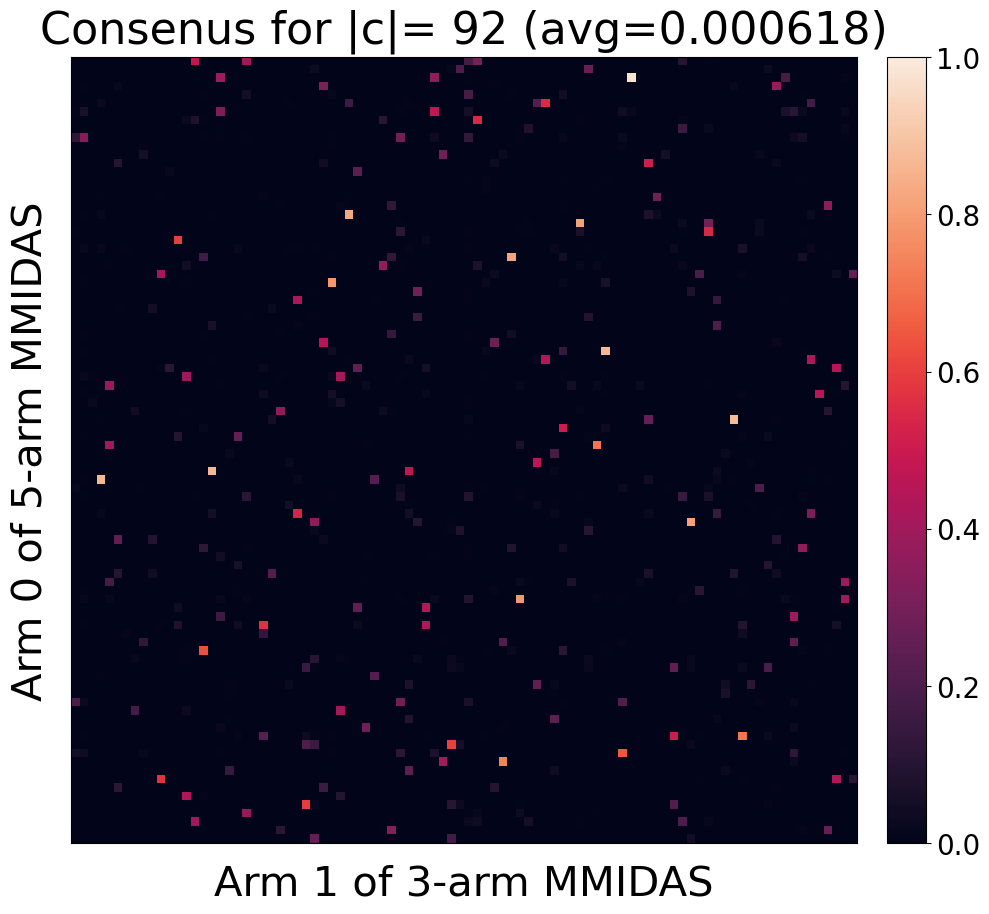

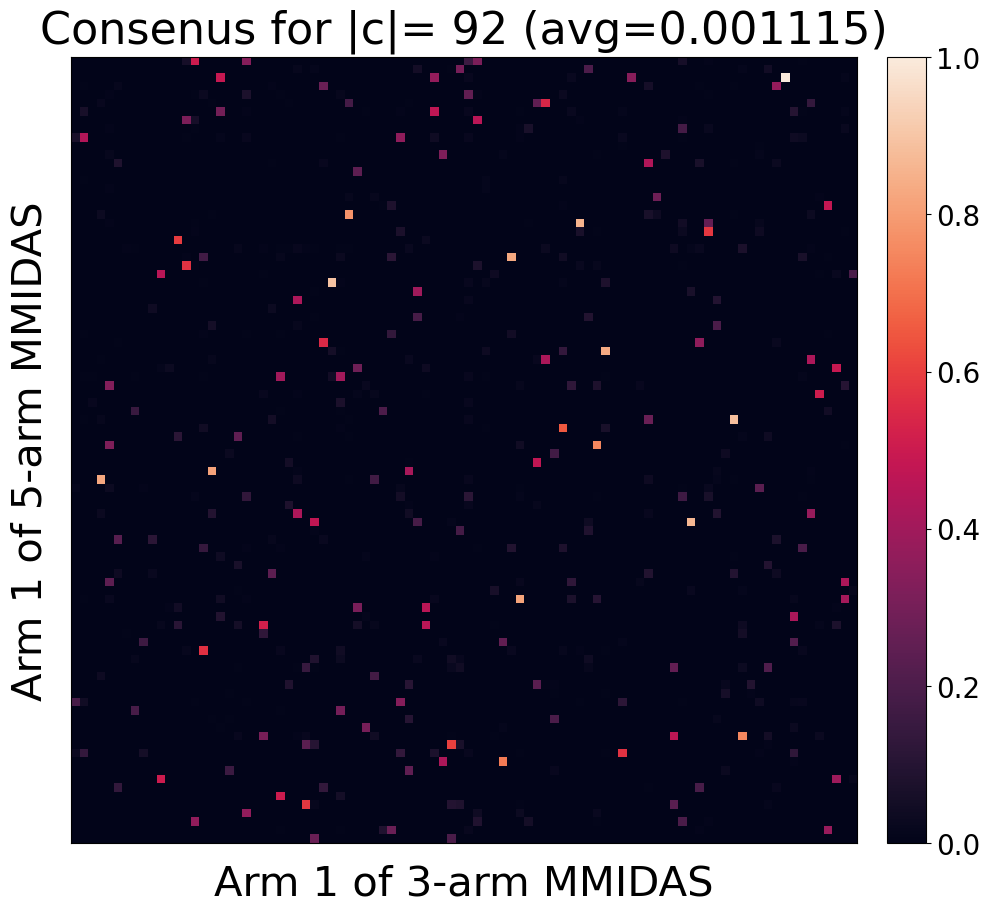

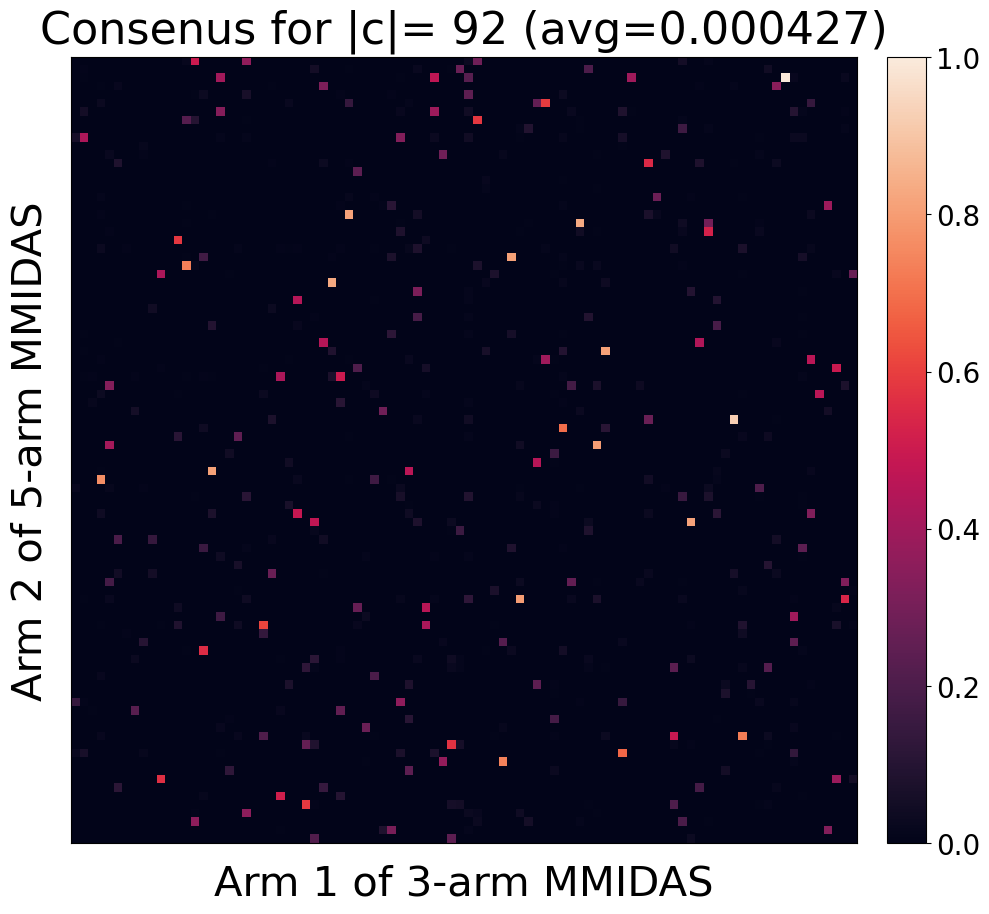

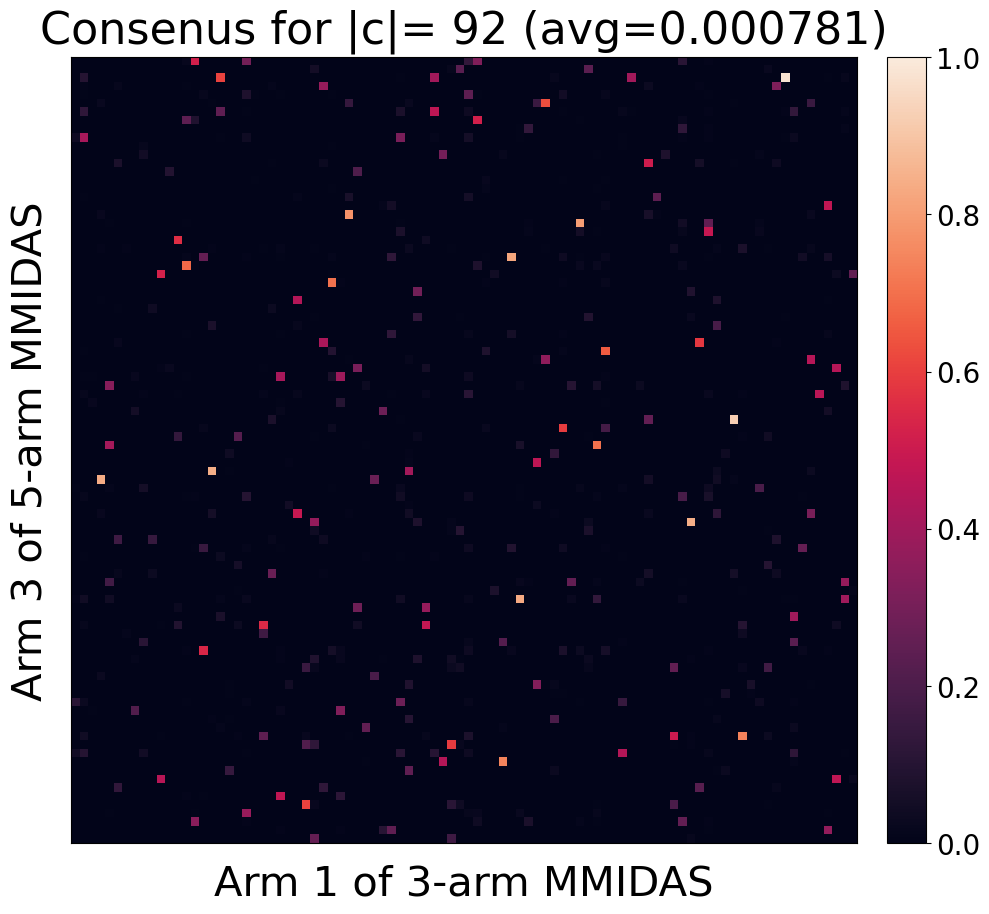

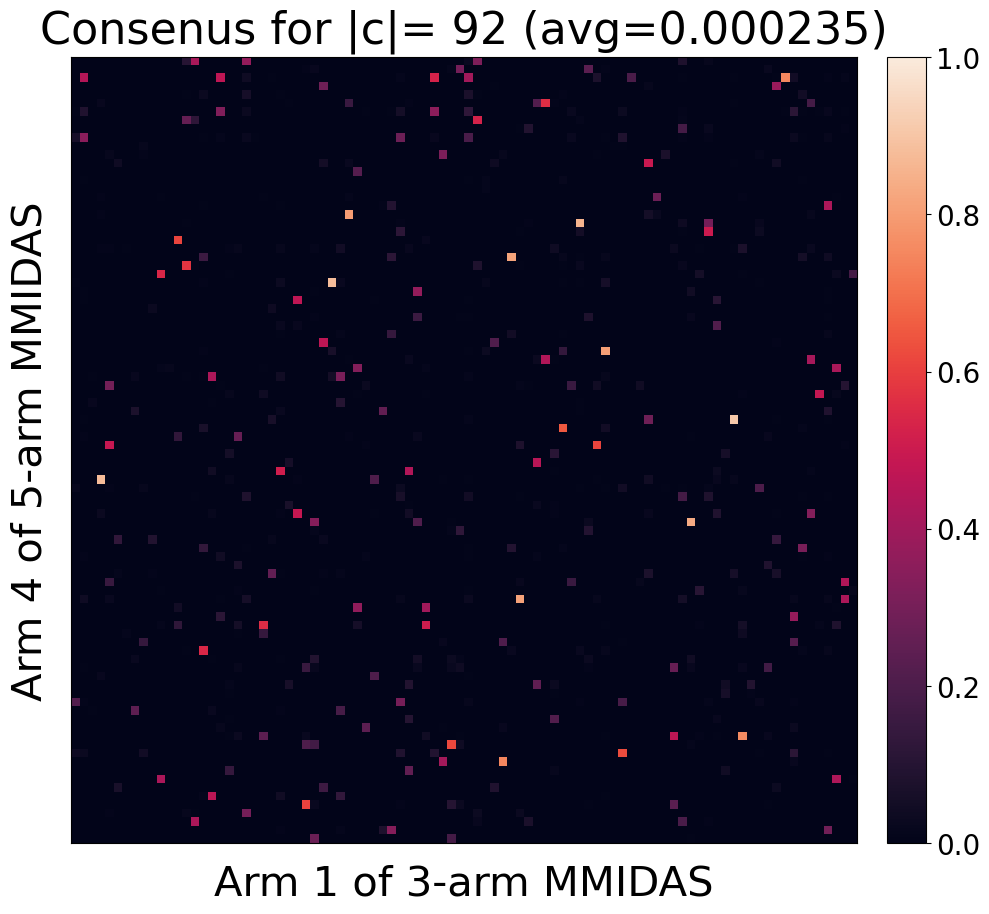

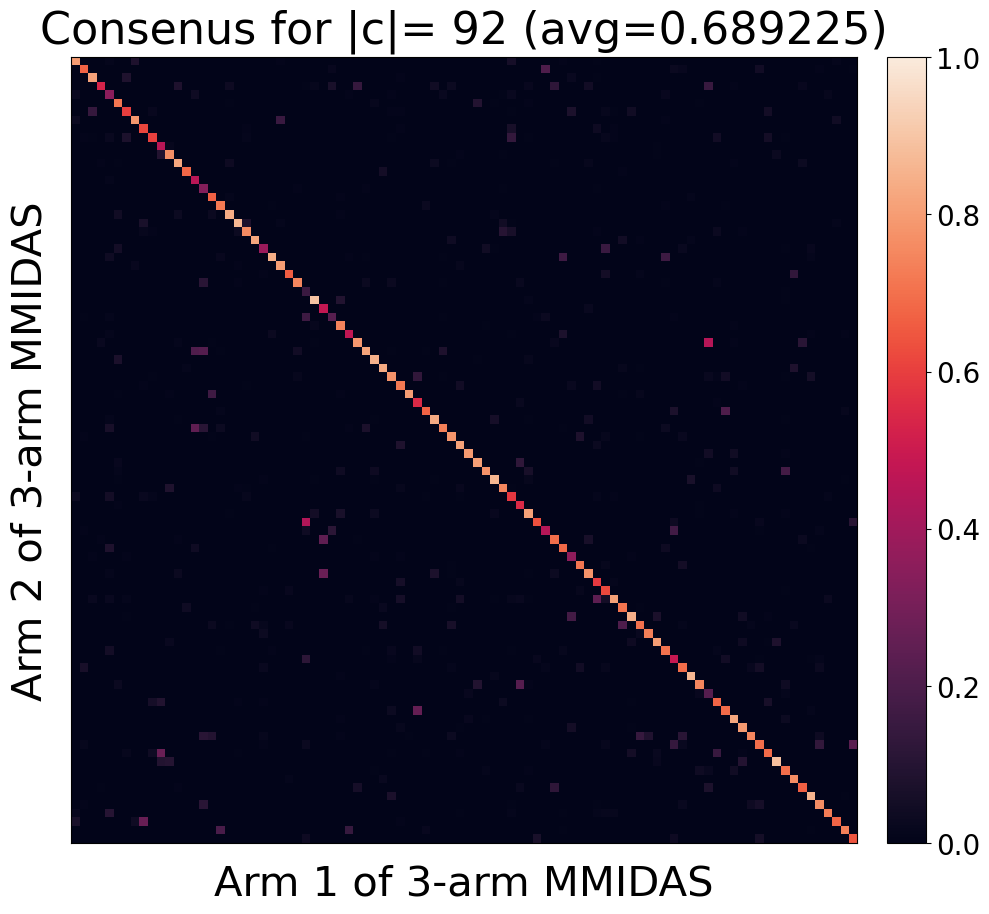

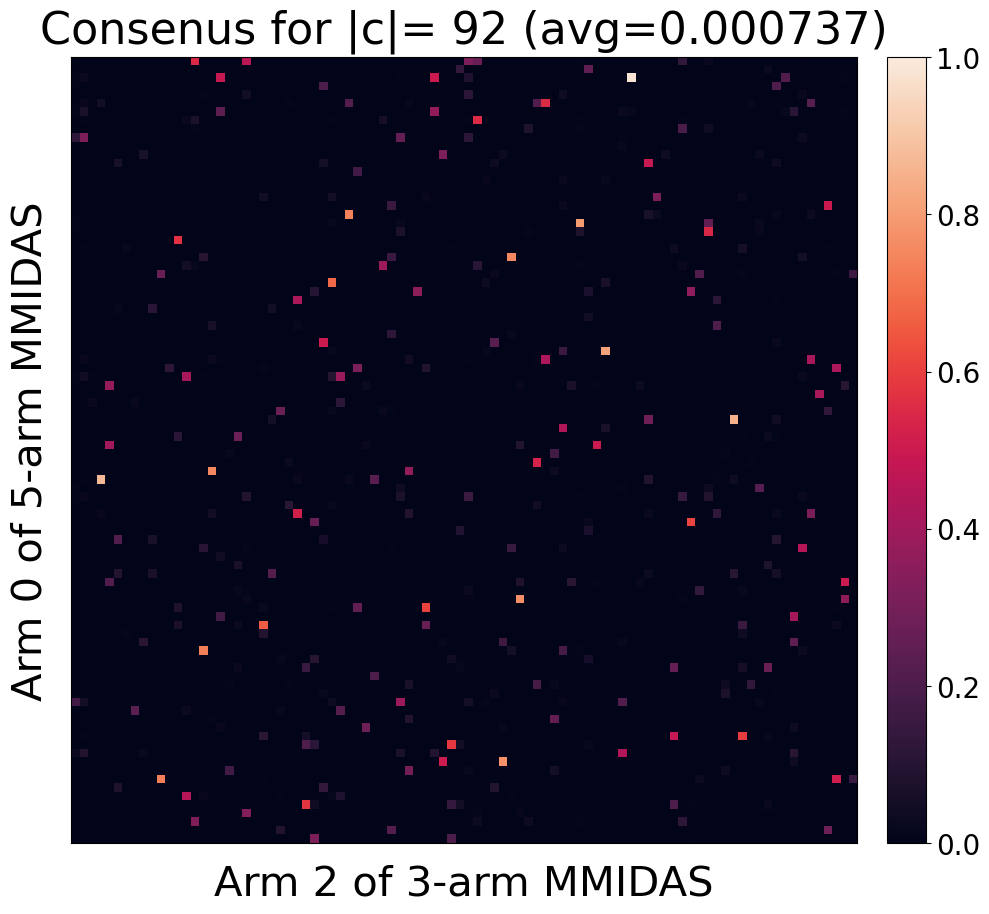

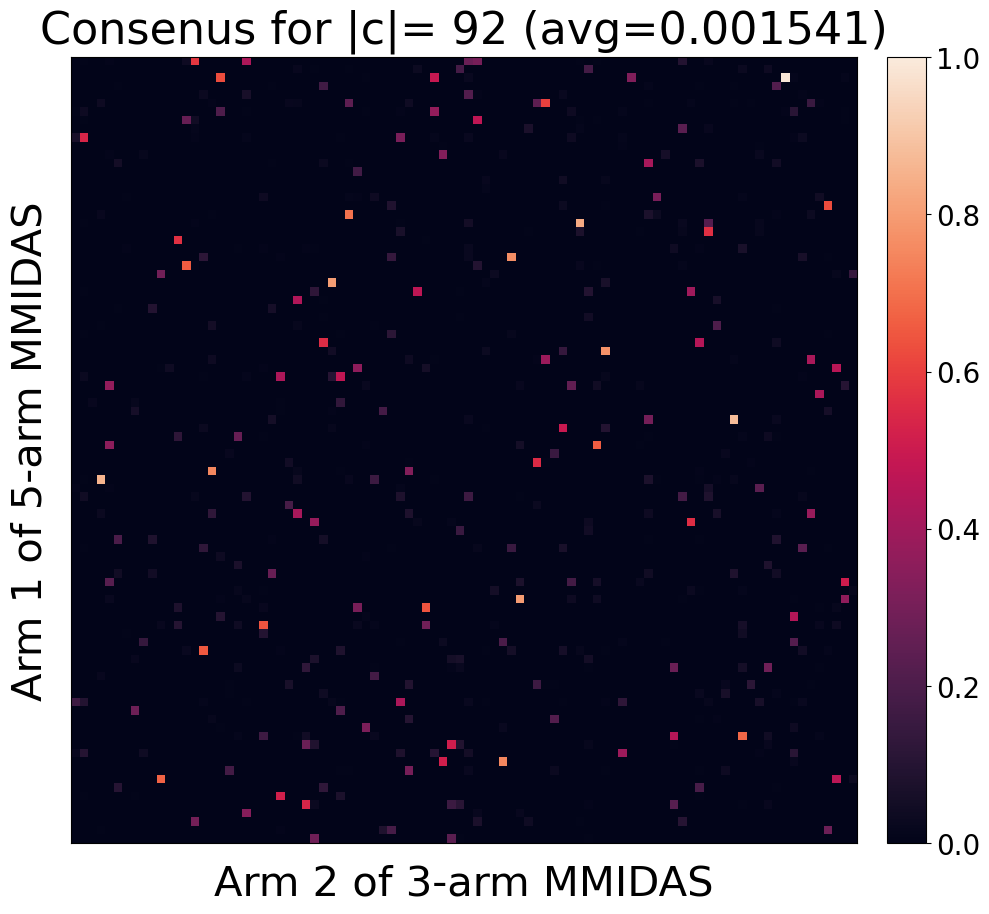

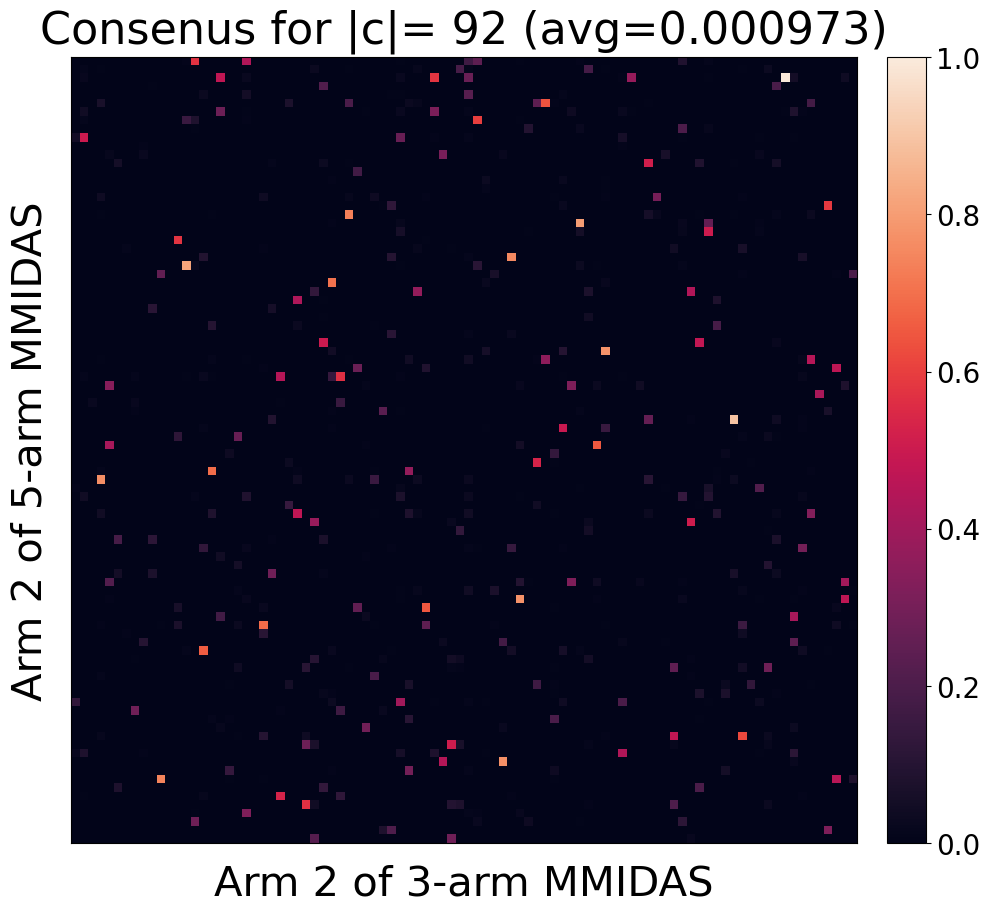

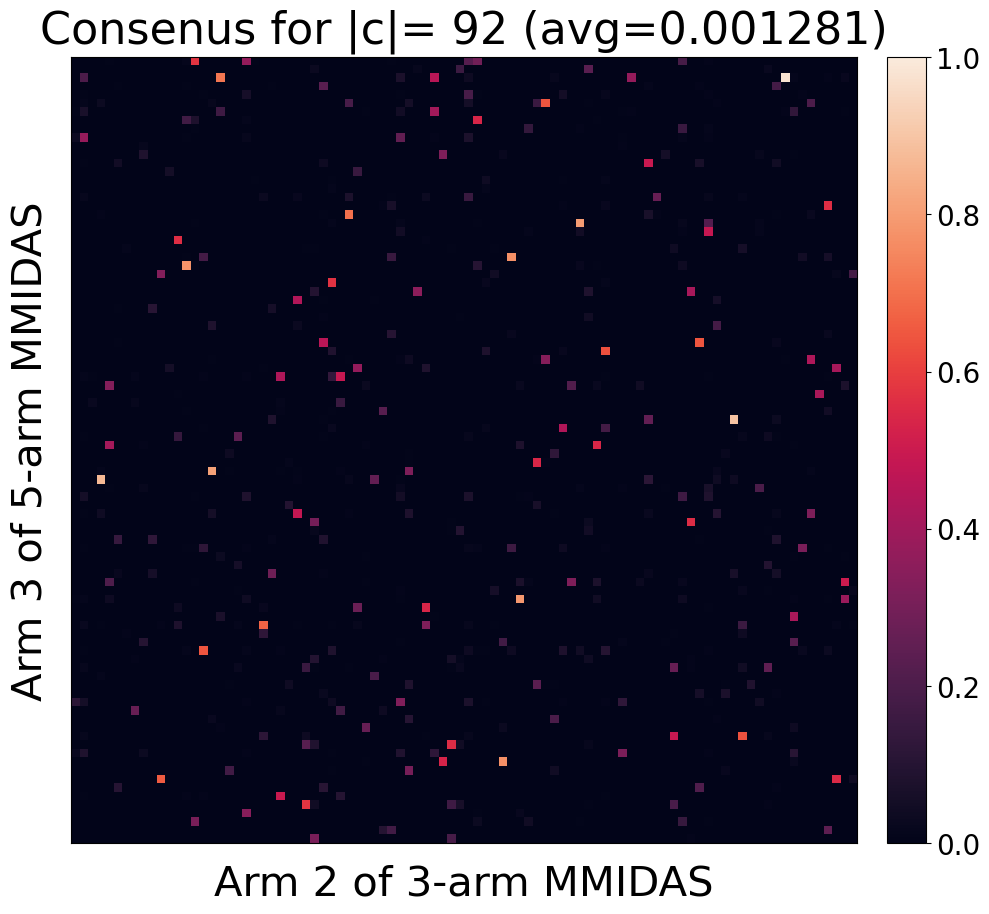

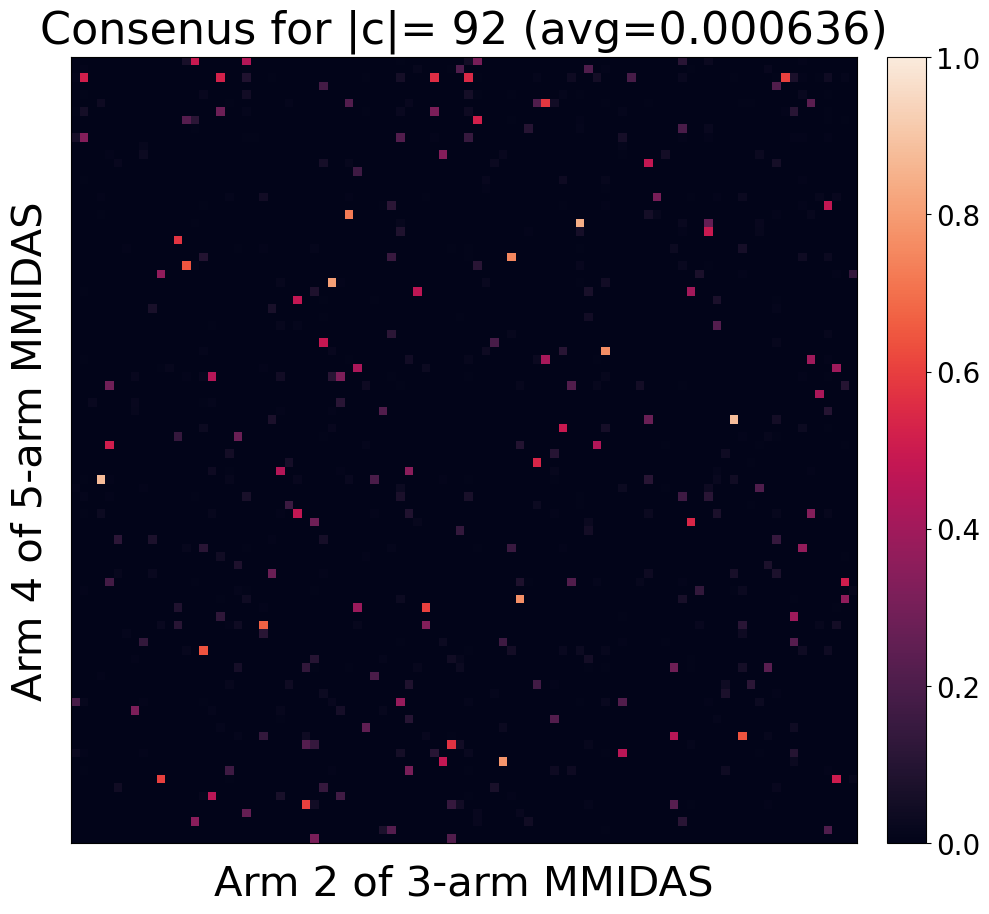

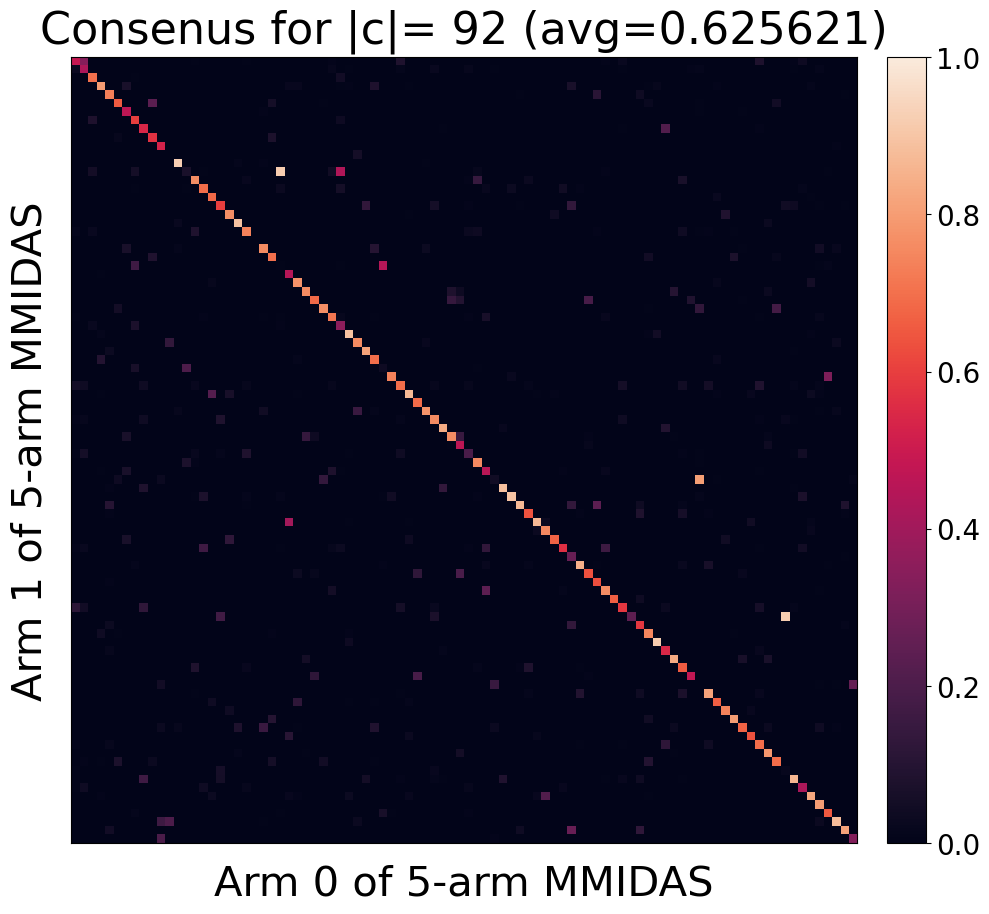

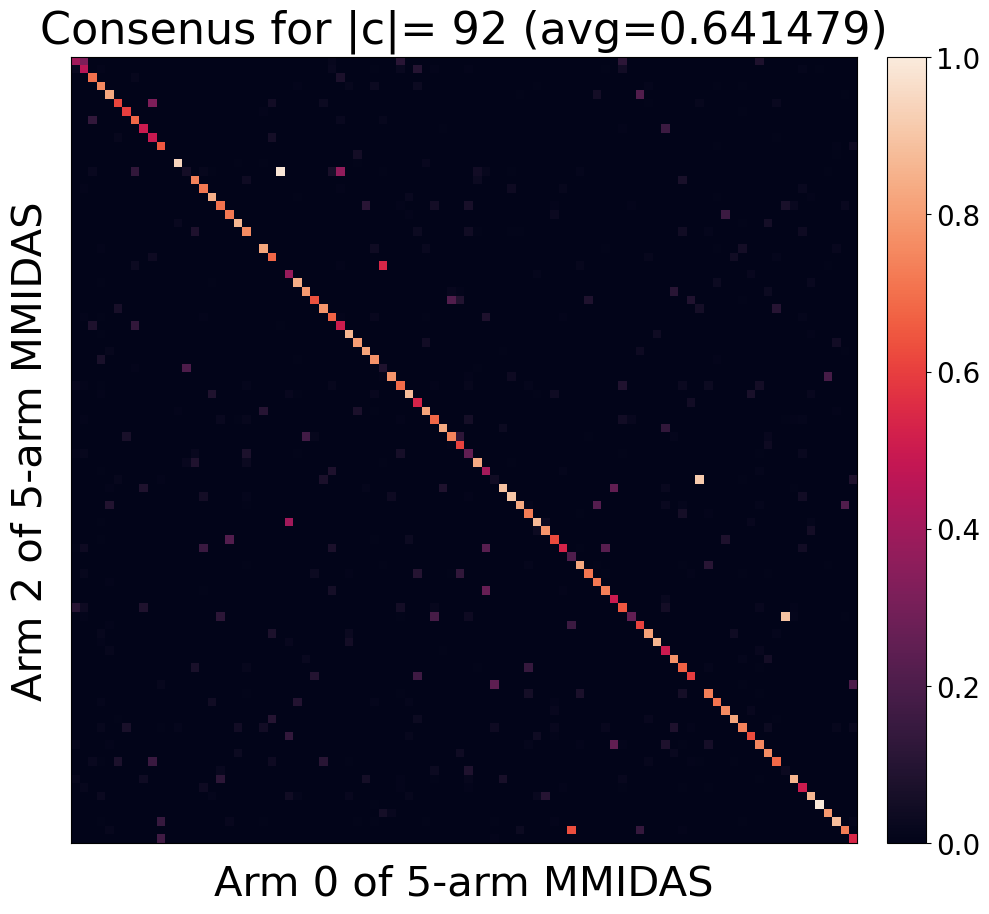

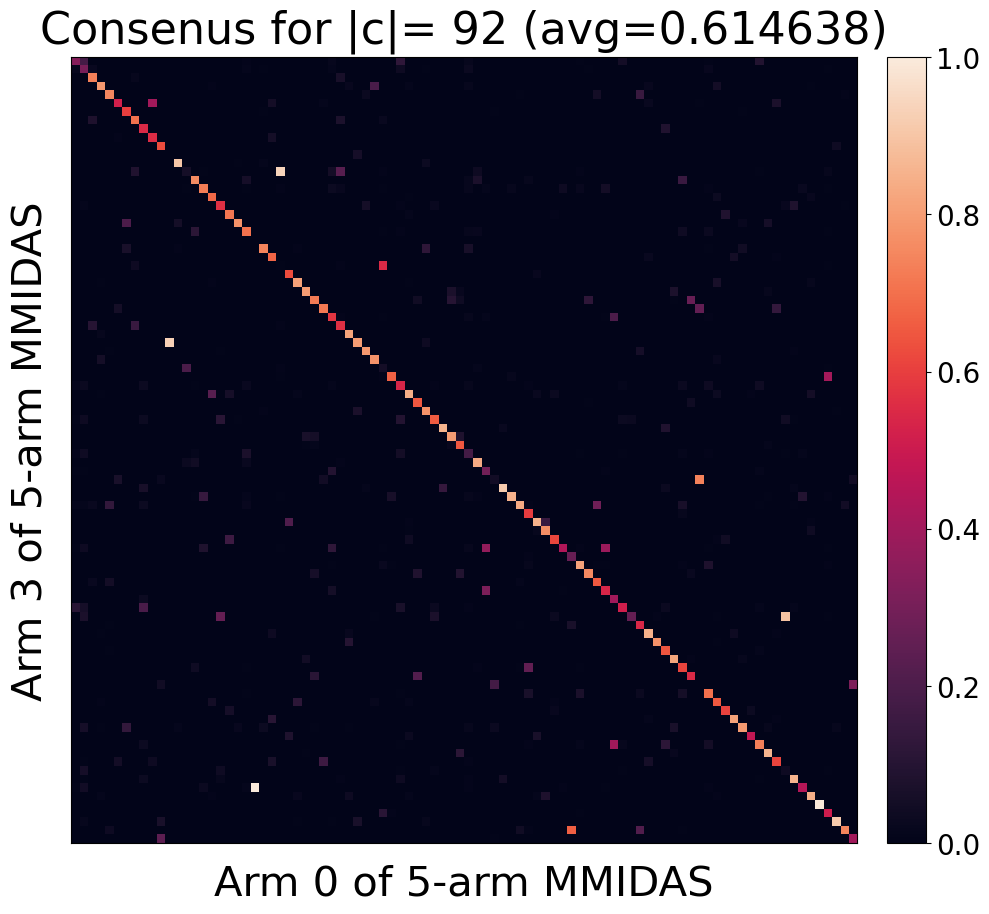

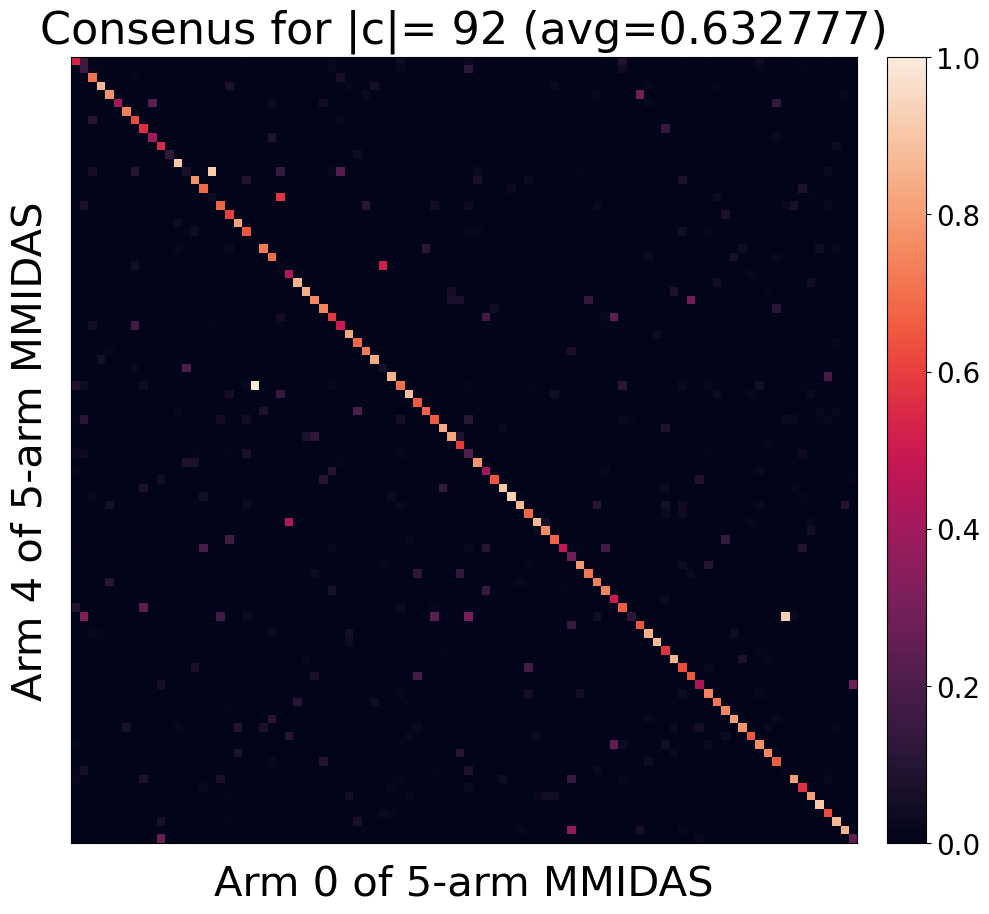

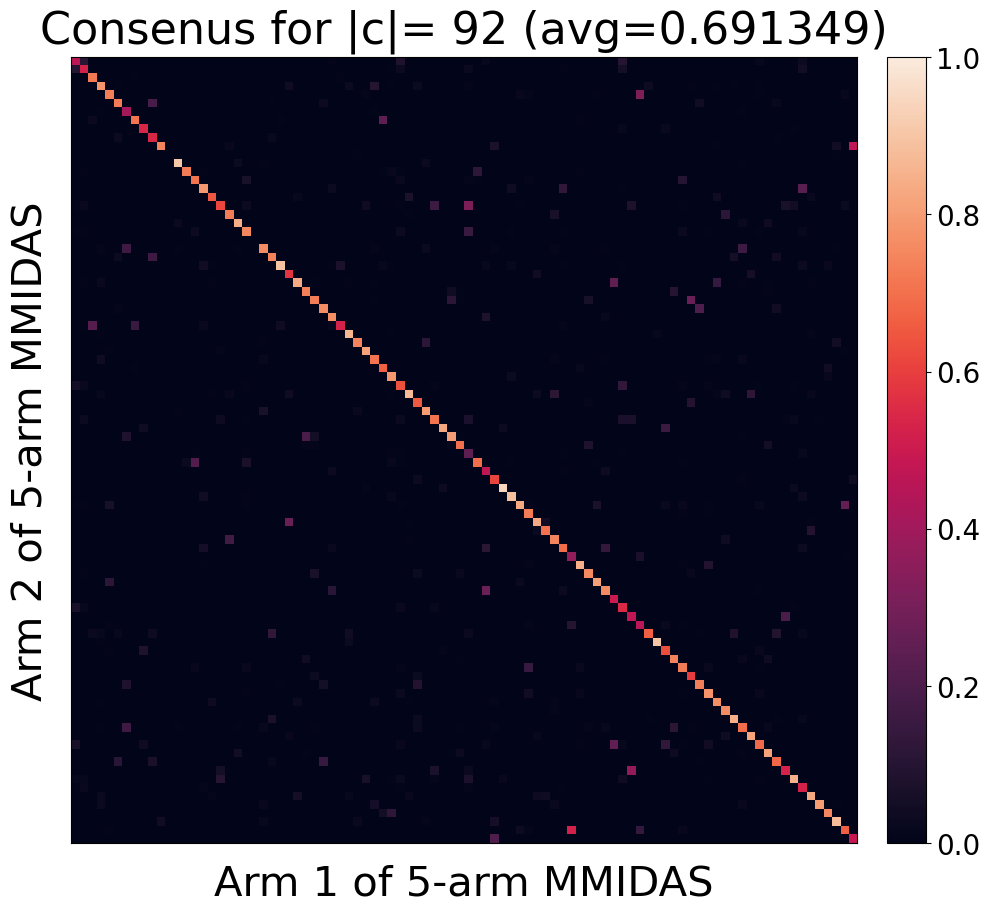

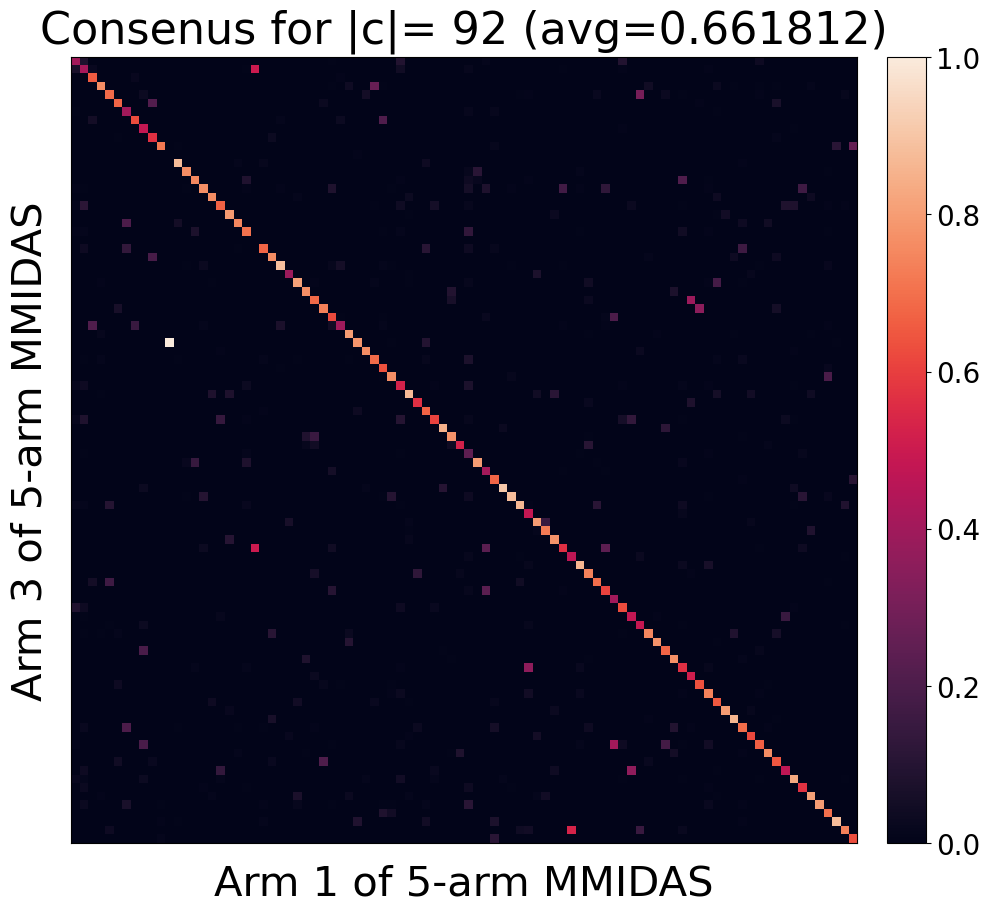

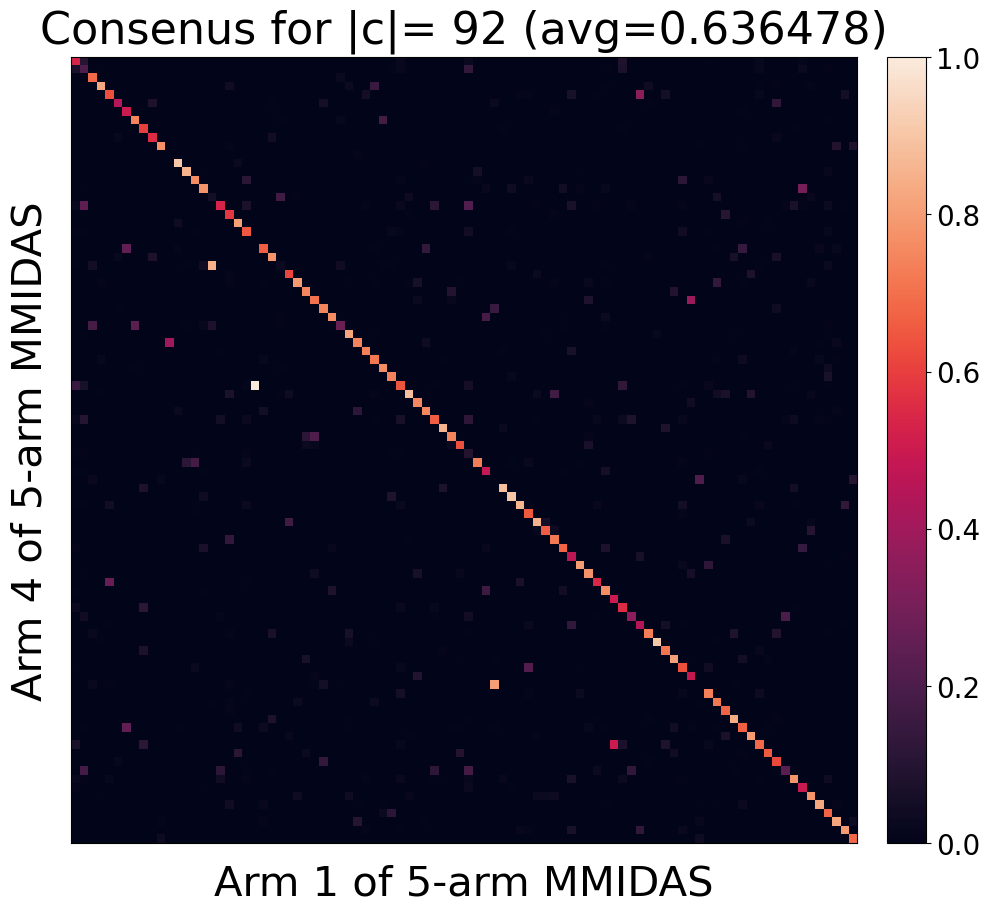

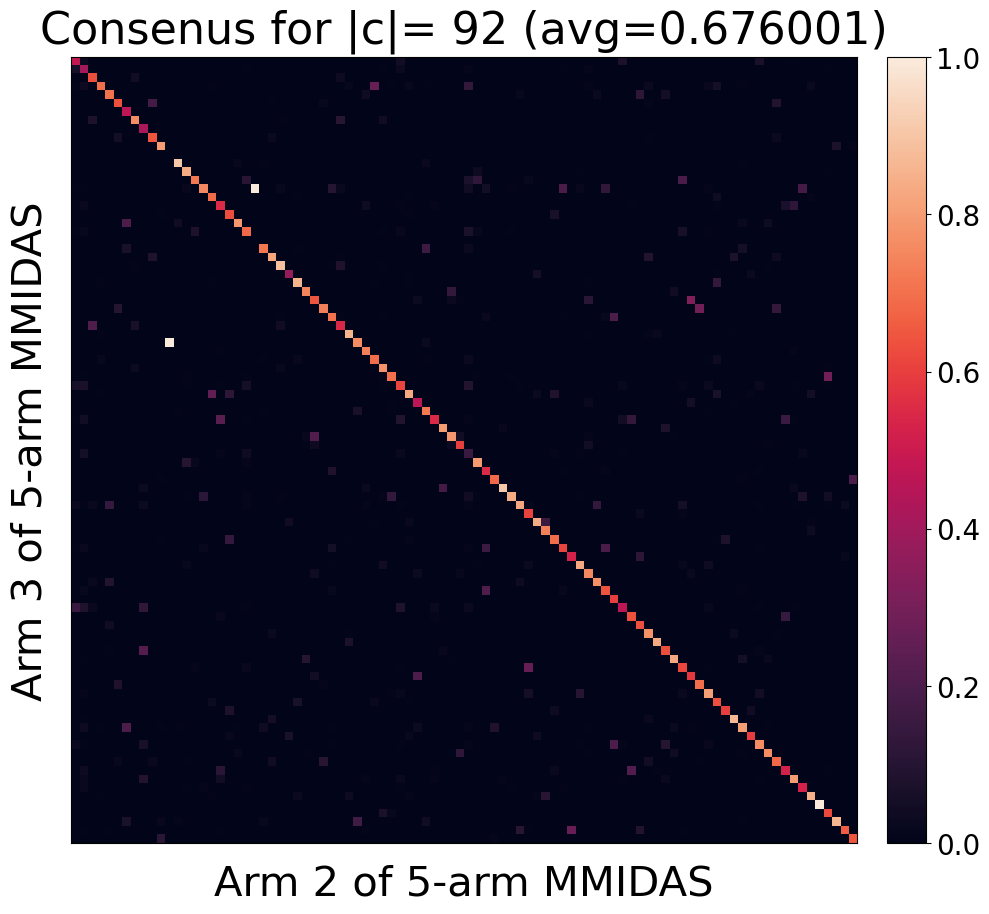

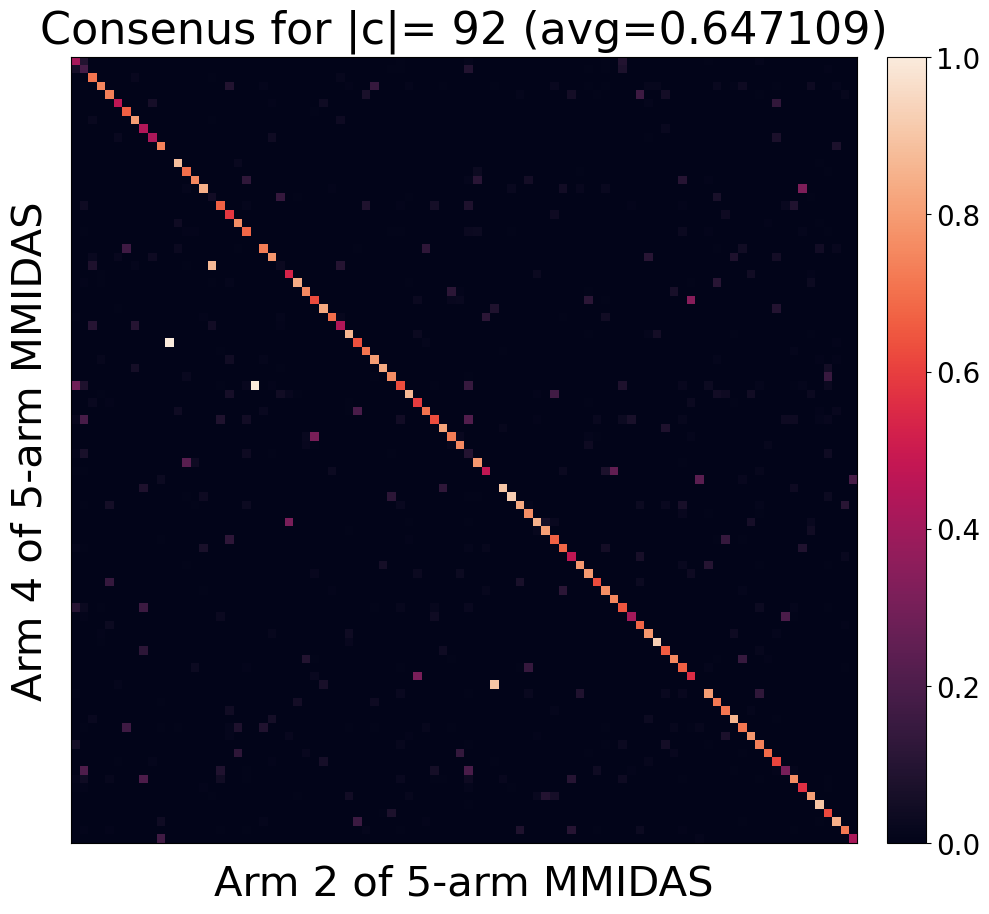

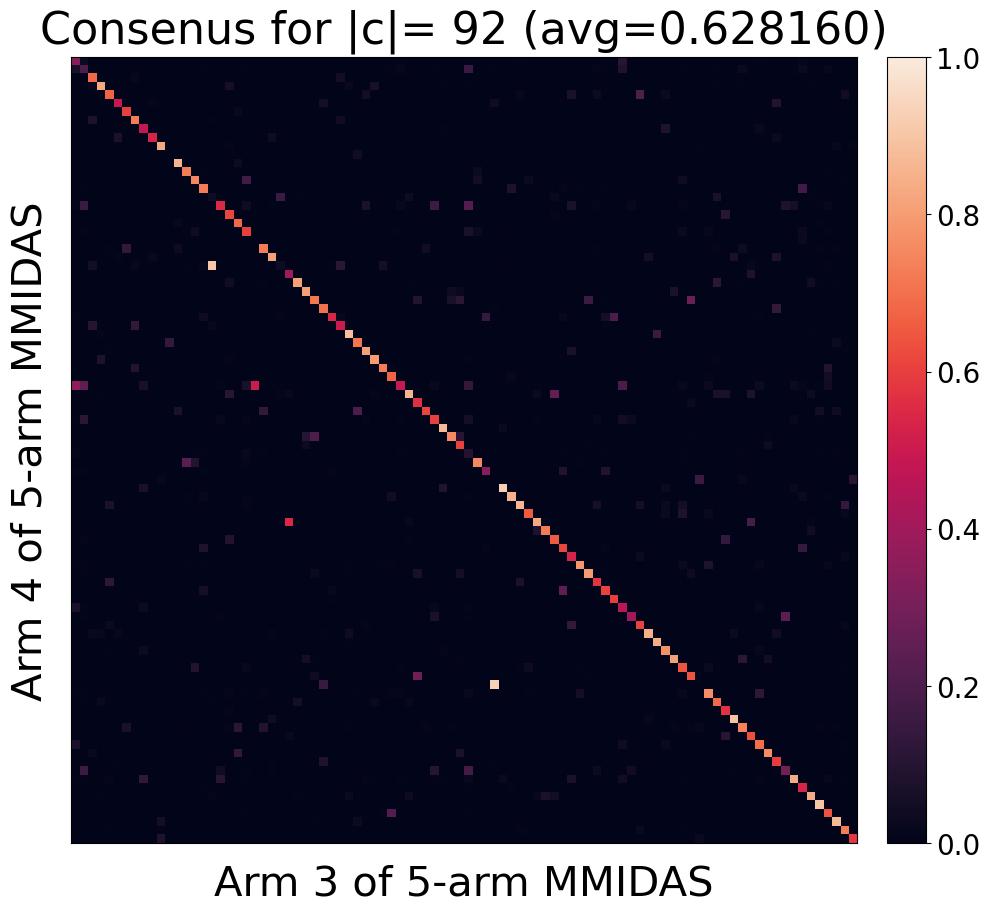

In [9]:
ConsensusMatrix = np.ndarray

def plot_consensus_heatmap(cm: ConsensusMatrix, axes: tuple[tuple[Arm, Arms, Optional[Run]], tuple[Arm, Arms, Optional[Run]]], savedir: Optional[str]) -> None:
     plt.figure(figsize=[10,10])
     ax = plt.gca()
     im = ax.imshow(cm, cmap='rocket', vmin=0, vmax=1)
     plt.xlabel(get_axis(axes[0]), fontsize=30, labelpad=15)     
     plt.ylabel(get_axis(axes[1]), fontsize=30, labelpad=15)
     plt.xticks([])
     plt.yticks([])
     plt.title(f'Consenus for |c|= {str(cm.shape[0])} (avg={np.mean(np.diag(cm)):.6f})', fontsize=32, pad=10)
     divider = make_axes_locatable(ax)
     cax = divider.append_axes("right", size="5%", pad=0.3)
     cbar = plt.colorbar(im, cax=cax)
     for t in cbar.ax.get_yticklabels():
          t.set_fontsize(20)

     plt.tight_layout()
     if savedir:
          plt.savefig(savedir + f'/consensus_heat_{get_axis_save(axes[0])}_vs_{get_axis_save(axes[1])}_K{cm.shape[0]}.png', dpi=600)
     print(f'avg consensus on test cells: {np.mean(np.diag(cm))}')

so_far = 0
so_far_a = 0
so_far_b = 0
for a in range(A):
     for b in range(B):
          plot_consensus_heatmap(ev['consensus'][so_far], ((a, A, None), (b, B, None)), f'multiarm-results/{A}{B}')
          so_far += 1

     for b in range(a + 1, A):
          plot_consensus_heatmap(ev['consensus_a'][so_far_a], ((a, A, None), (b, A, None)), f'multiarm-results/{A}{B}')
          so_far_a += 1

for a in range(B):
     for b in range(a + 1, B):
          plot_consensus_heatmap(ev['consensus_b'][so_far_b], ((a, B, None), (b, B, None)), f'multiarm-results/{A}{B}')
          so_far_b += 1
        
# maybe check images the model got wrong to see what features got wrong
# how much noise to give?

#### Evaluating the model results against a taxonomy
It necessitate access to a taxonomy for the dataset. Some of the subsequent steps depend on this taxonomy.

/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/utils/analysis_cells_tree.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  htree_df['isleaf'].fillna(False,inplace=True)
/allen/programs/celltypes/workgroups/mousecelltypes/Hilal/distributed-vae/mmidas/utils/analysis_cells_tree.py:72: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `p

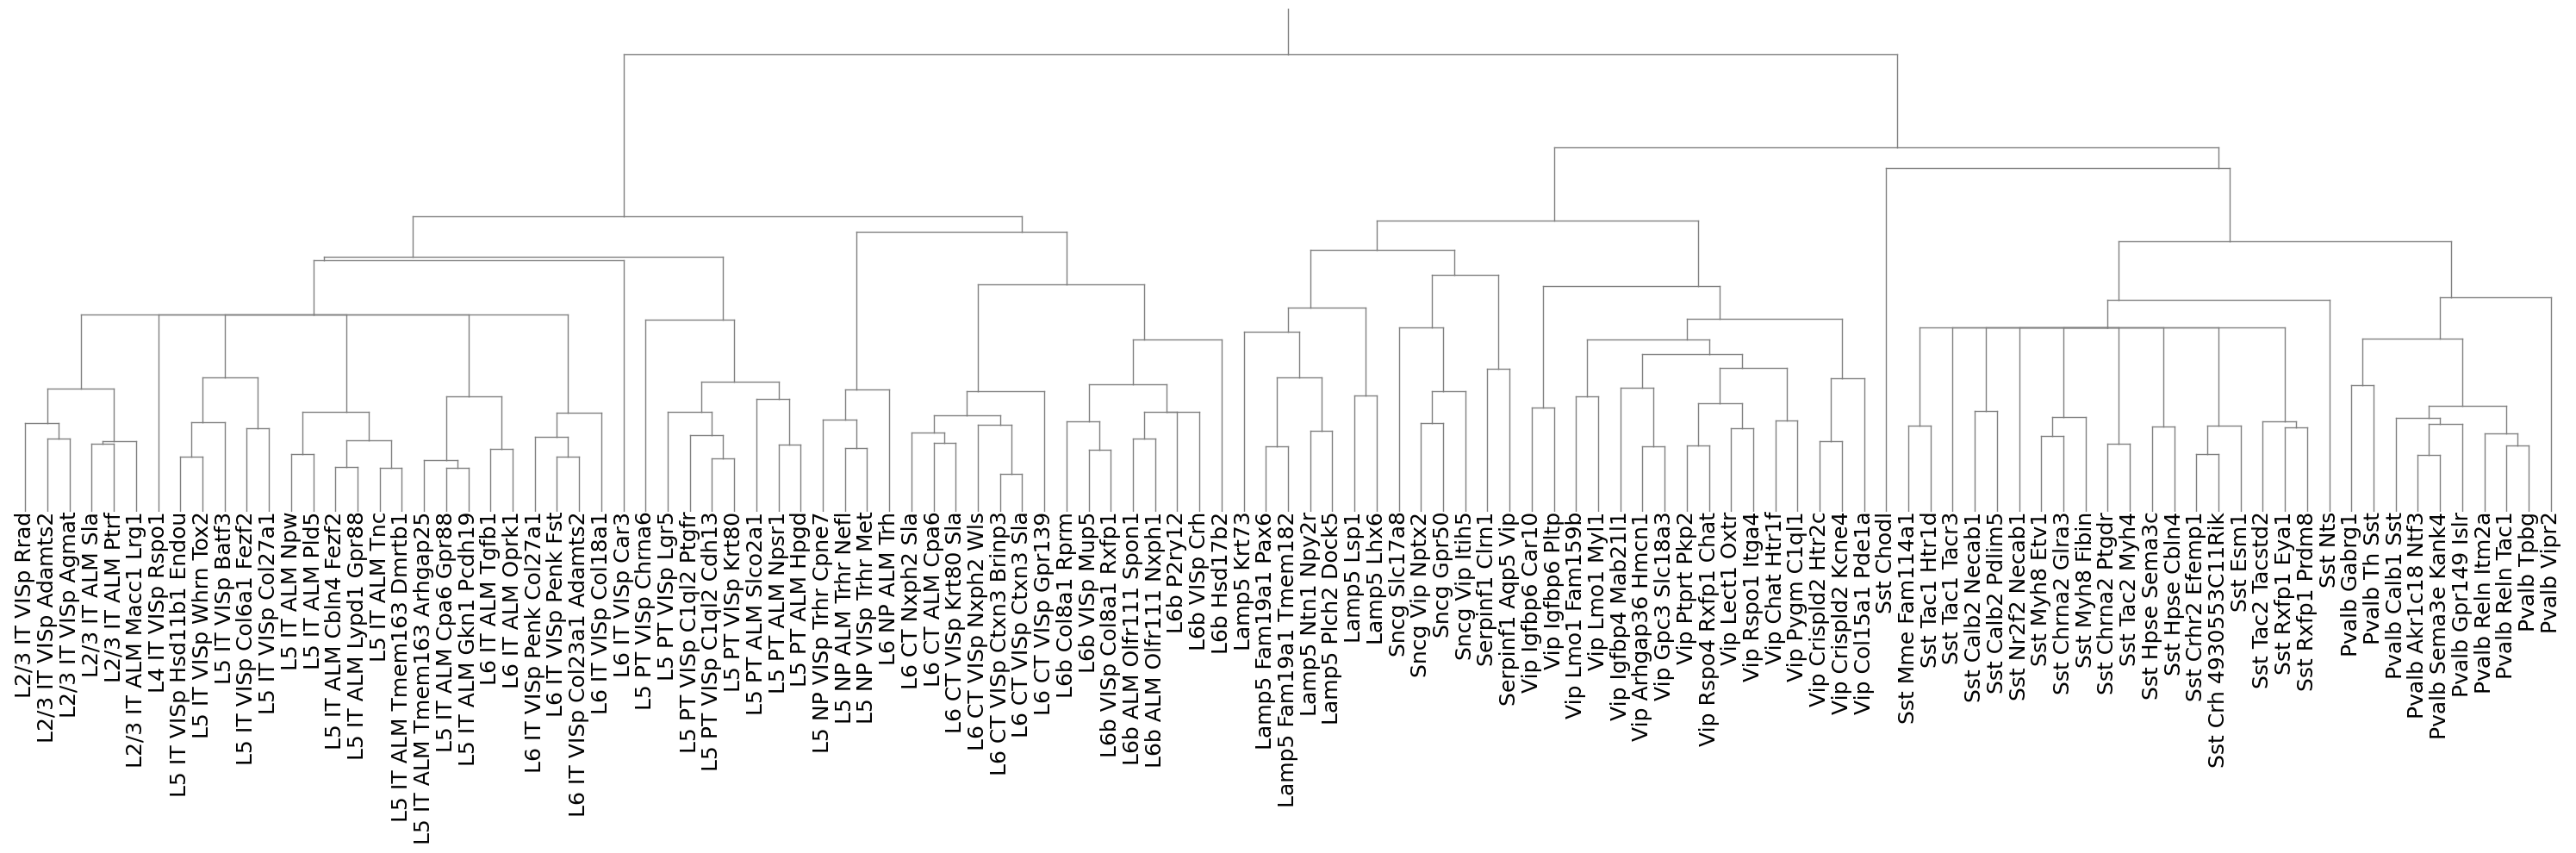

In [10]:
# Loading the taxonomy tree and ordering the clusters according to the tree
htree_file = config[dataset]['data_path'] / config[dataset]['htree_file']
data['cluster'] = np.array([c.strip() for c in data['cluster']])
cats_ttypes = np.unique(data['cluster'])
C_ttypes = len(cats_ttypes)
merged_cells_labels, treeobj, _ = get_merged_types(htree_file=htree_file, cells_labels=data['cluster'], num_classes=1)

cluster_ids = []
for i, s in enumerate(treeobj.child):
    s = s.strip()
    if (cats_ttypes == s).any():
        cluster_id = list(cats_ttypes).index(s)
        cluster_ids.append(cluster_id)
        
cats_ttypes_sorted = cats_ttypes[cluster_ids]

inds_ttypes_sorted = []
for s in cats_ttypes_sorted:
    inds_ttypes_sorted.append(list(cats_ttypes).index(s))
inds_ttypes_sorted = np.array(inds_ttypes_sorted)

# Plotting the taxonomy tree
treeobj.plot(figsize=[30,10], txtleafonly=True, skeletononly=False, fontsize=18, skeletoncol='gray')

In [13]:
# Assign colors to each cell type according to the taxonomy
color_ord_T = treeobj.col[treeobj.isleaf]
color_T = treeobj.col[treeobj.isleaf]
data['cluster_color'] = np.array([color_ord_T[0]]*len(data['cluster']))
for i_type, ttype in enumerate(cats_ttypes):
    idx1 = np.where(data['cluster'] == ttype)[0]
    idx2 = np.where(cats_ttypes_sorted == ttype)[0][0]
    data['cluster_color'][idx1] = color_ord_T[idx2]
    color_T[i_type] = color_ord_T[idx2]

In [ ]:
outcome = summarize_inference(cplMixVAE, selected_model, all_loader)
category_vs_class = np.zeros((n_arm, data['n_type'], n_categories))

for a in range(A):
    label_predict = []
    for d in range(len(data['cluster_id'])):
        z_cat = np.squeeze(outcome['c_prob'][a][d, :])
        category_vs_class[a, int(data['cluster_id'][d] - 1), np.argmax(z_cat)] += 1
cT_vs_cT = category_vs_class[:, :, outcome['nprune_indx']]

#### t-types vs. MMIDAS categories

In [ ]:
PerformanceMatrix = np.ndarray
ConsensusMatrix = np.ndarray

def rev(x: np.ndarray) -> np.ndarray:
    return x[::-1]

@unstable
def compute_consensus(pm: np.ndarray, target_dim: int) -> ConsensusMatrix:
    C = pm.shape[-1]

    cat_inds = linear_sum_assignment(-pm)[1]
    sort_idx = np.vstack([rev(np.argsort(pm[c_t])) for c_t in range(target_dim)]).astype(int)
    max_c_ind = -1 * np.ones(C)
    if C > target_dim:
        for c in filter(lambda c: c not in sort_idx[:,0], range(C)):
            col = np.argmax(pm[:, c].astype(int))
            find_indx = np.where(sort_idx[col, 0] == sort_idx[:,0])[0][0]
            max_c_ind[find_indx+1] = c
        max_c_ind[max_c_ind == -1] = sort_idx[:,0]
        cat_inds = max_c_ind.astype(int)
    return pm[:, cat_inds], cat_inds

def normalize_consensus(pm: np.ndarray) -> ConsensusMatrix:
    return pm / np.max(pm) / 2

@unstable
def plot_consensus(cm: np.ndarray, xticks, yticks, colors, axes: tuple[tuple[Arm, Arms, Optional[Run]], tuple[Arm, Arms, Optional[Run]]], savedir: Optional[str]) -> None:
    C_targets = cm.shape[0]
    C = cm.shape[1]

    fig, axs = plt.subplots(1, 1, figsize=(12, 15), dpi=100)
    for c_t in trange(C_targets):
        for c in range(C):
            axs.add_patch(plt.Circle(np.array([c, c_t]), radius=(cm[c_t, c]), color=colors[c_t]))
    axs.set_xlim([-.1, C + .1])
    axs.set_ylim([-.1, C_targets + 0.1])
    axs.invert_yaxis()
    axs.set_xlabel(f"Categories for {get_axis(axes[0])}", fontsize=20)
    axs.set_xticks(np.arange(C))
    axs.set_xticklabels(xticks, fontsize=6, rotation=90)
    axs.set_yticks(np.arange(C_targets))
    axs.set_yticklabels(yticks, fontsize=8)
    fig.tight_layout()
    if savedir:
        plt.savefig(savedir + f'/Taxonomy_{get_axis_save(axes[0])}_vs_{get_axis_save(axes[1])}.png', dpi=300)
    plt.show()

for a in range(A):
    pm, cat_inds = compute_consensus(cT_vs_cT[a, inds_ttypes_sorted, :], len(cats_ttypes_sorted))
    plot_consensus(normalize_consensus(pm), _ev['inds_unpruned'][cat_inds], cats_ttypes_sorted, color_ord_T, ((a, A, None), ('ttypes', 'ttypes', None)), saving_folder)

#### Mutual Information between t-types and MMIDAS categories

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
  1%|          | 1/92 [00:00<01:09,  1.31it/s]

100%|██████████| 92/92 [01:09<00:00,  1.33it/s]


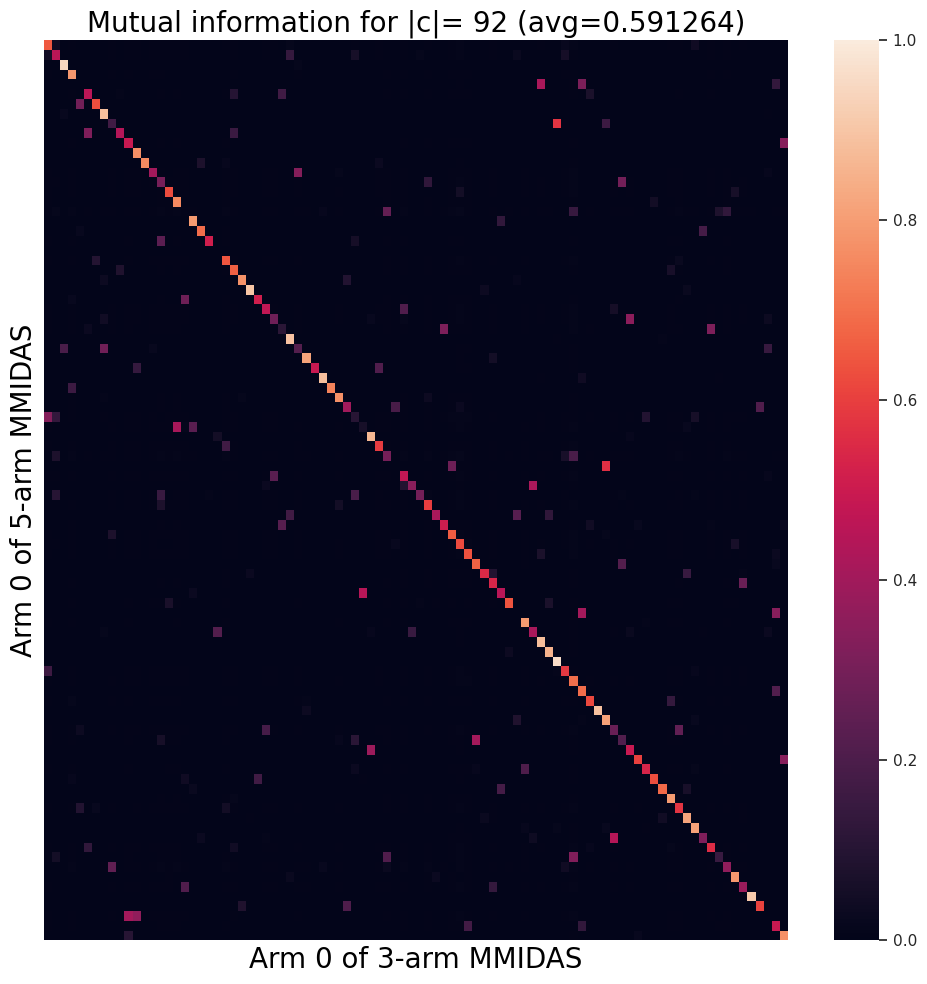

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:08<00:00,  1.34it/s]


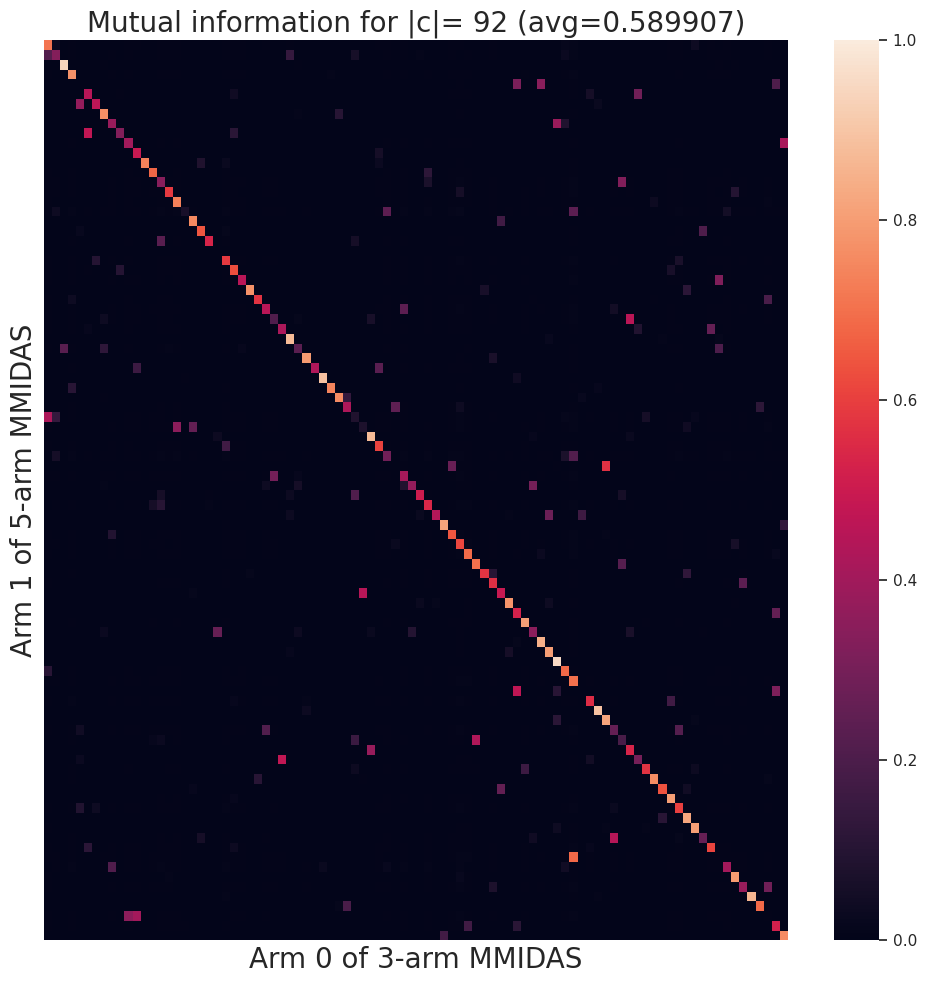

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:08<00:00,  1.35it/s]


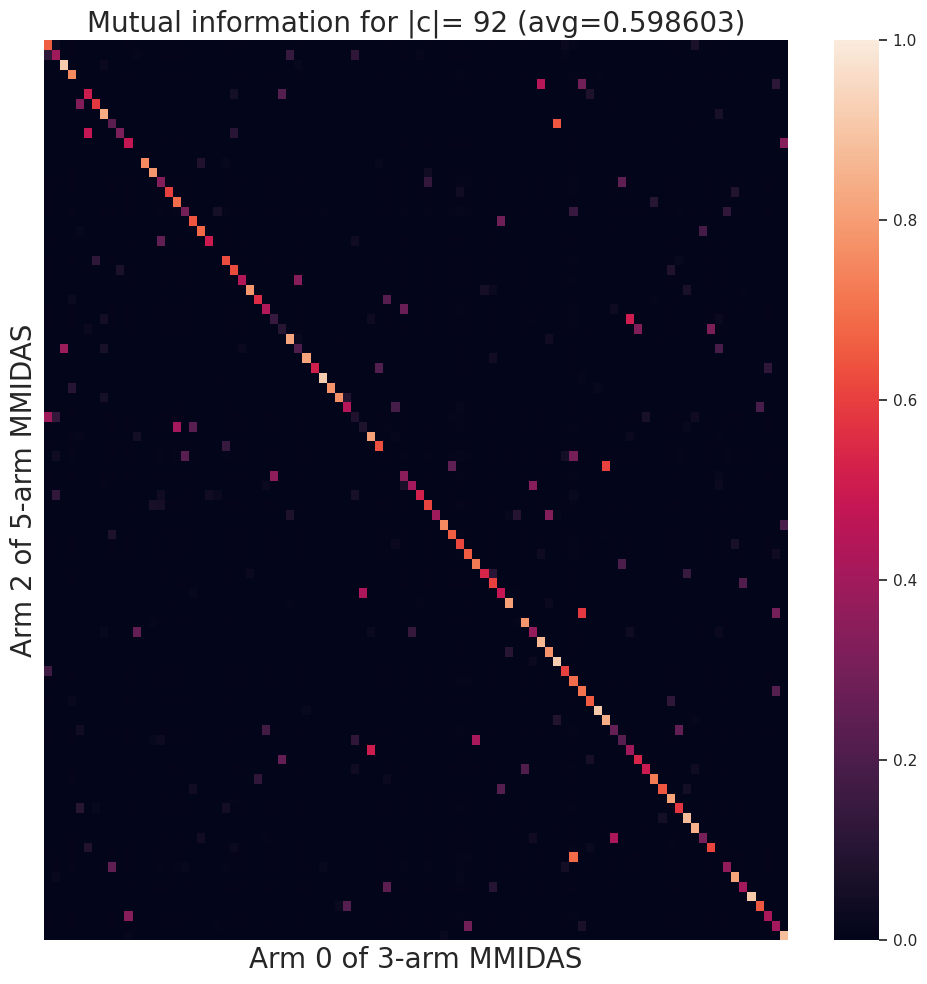

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:08<00:00,  1.34it/s]


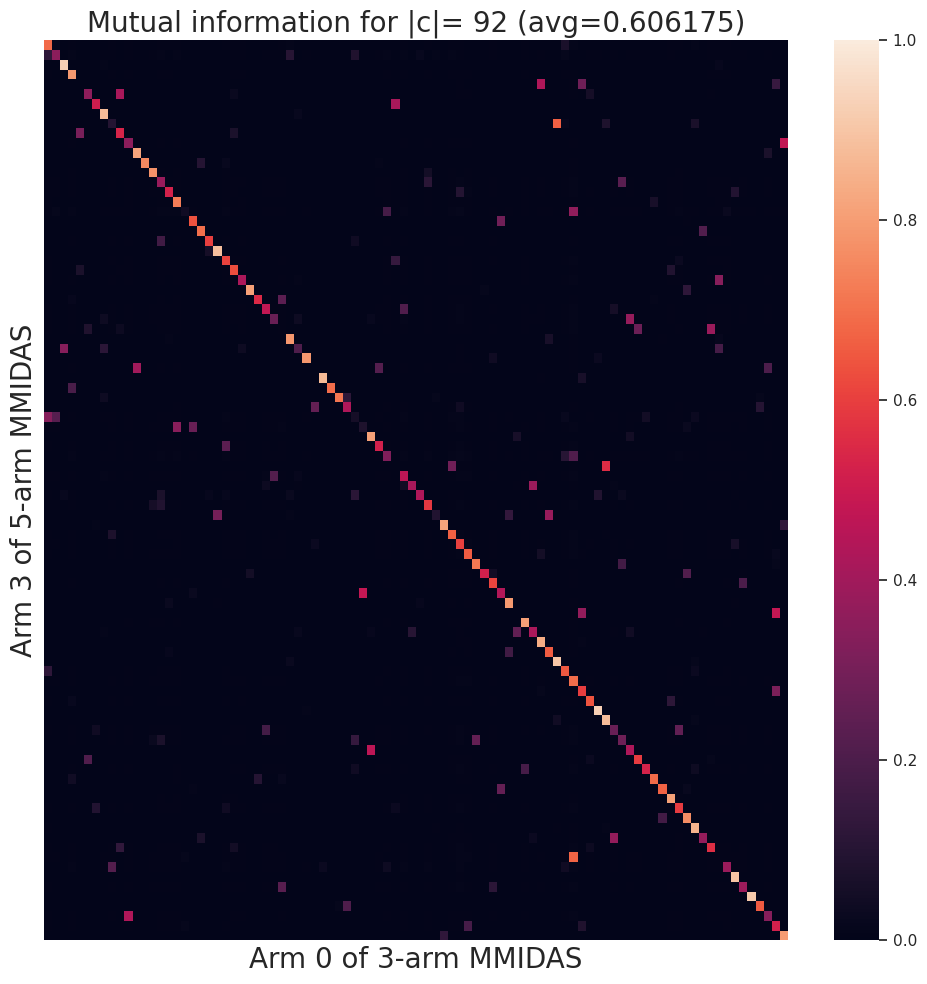

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:08<00:00,  1.35it/s]


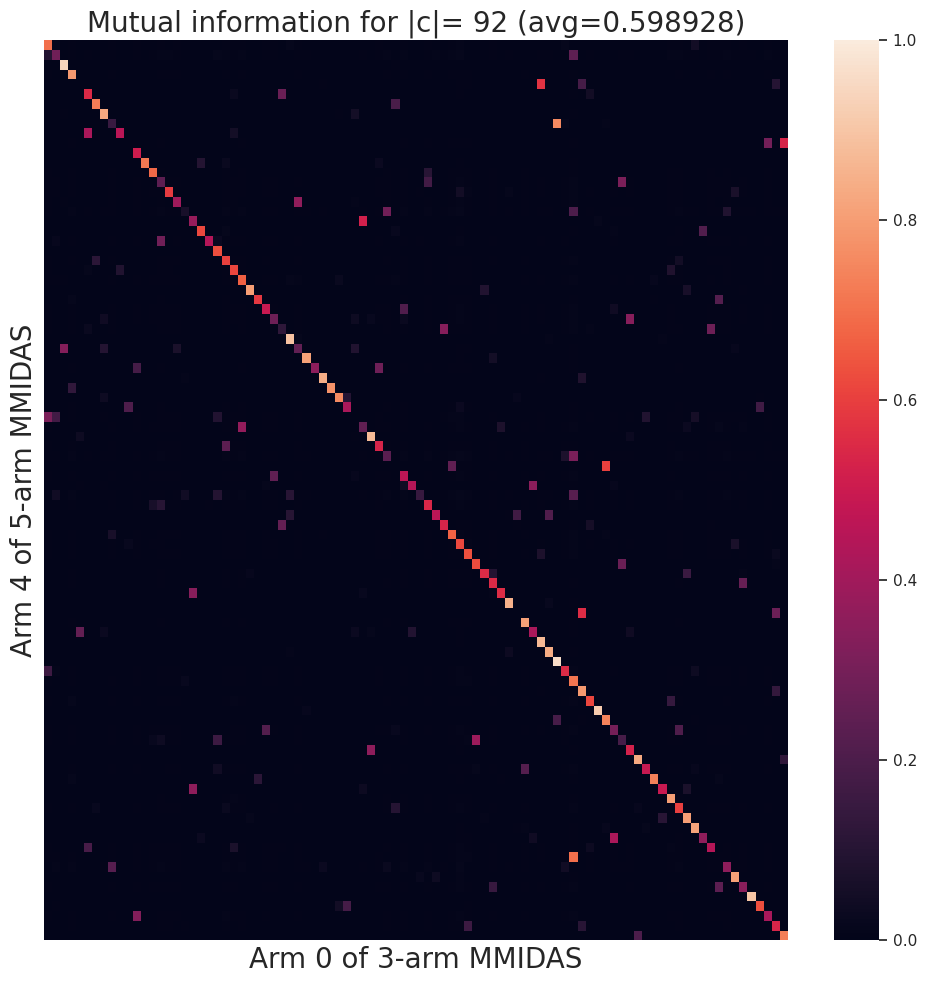

/tmp/ipykernel_85449/1143854957.py:53: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_a'][b]))
100%|██████████| 92/92 [01:10<00:00,  1.31it/s]


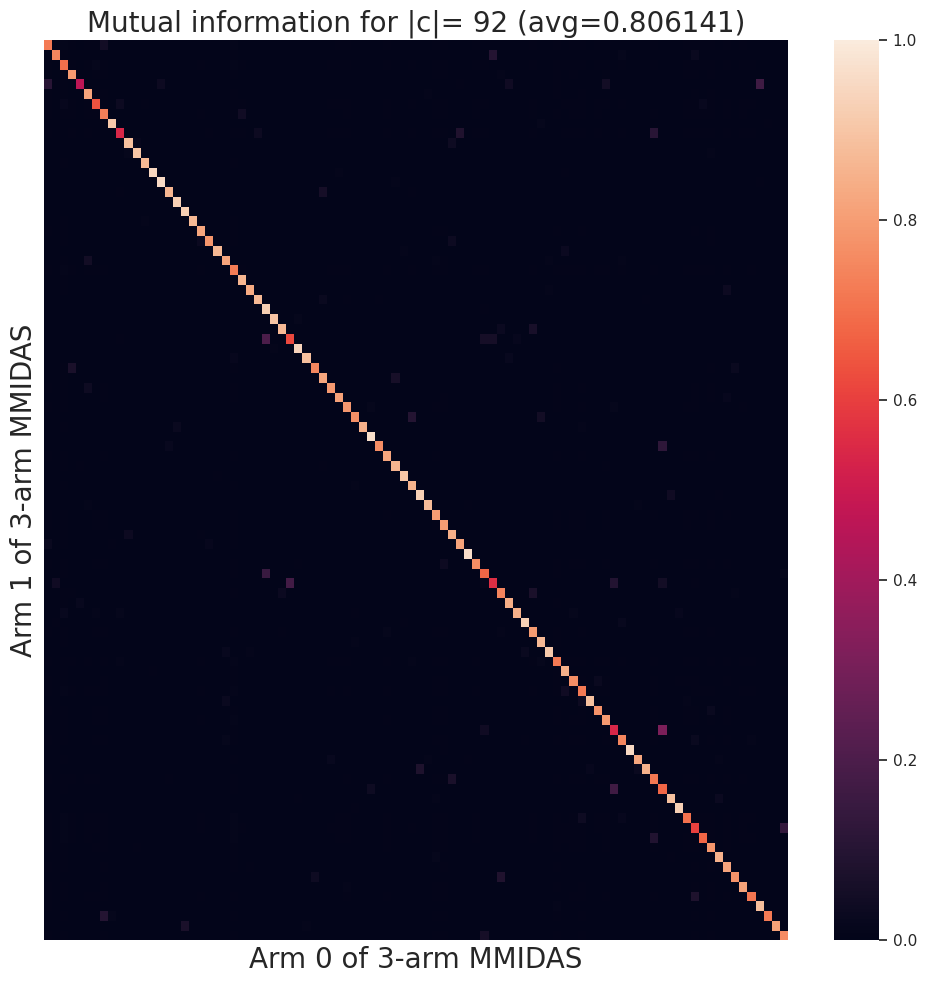

/tmp/ipykernel_85449/1143854957.py:53: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_a'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.32it/s]


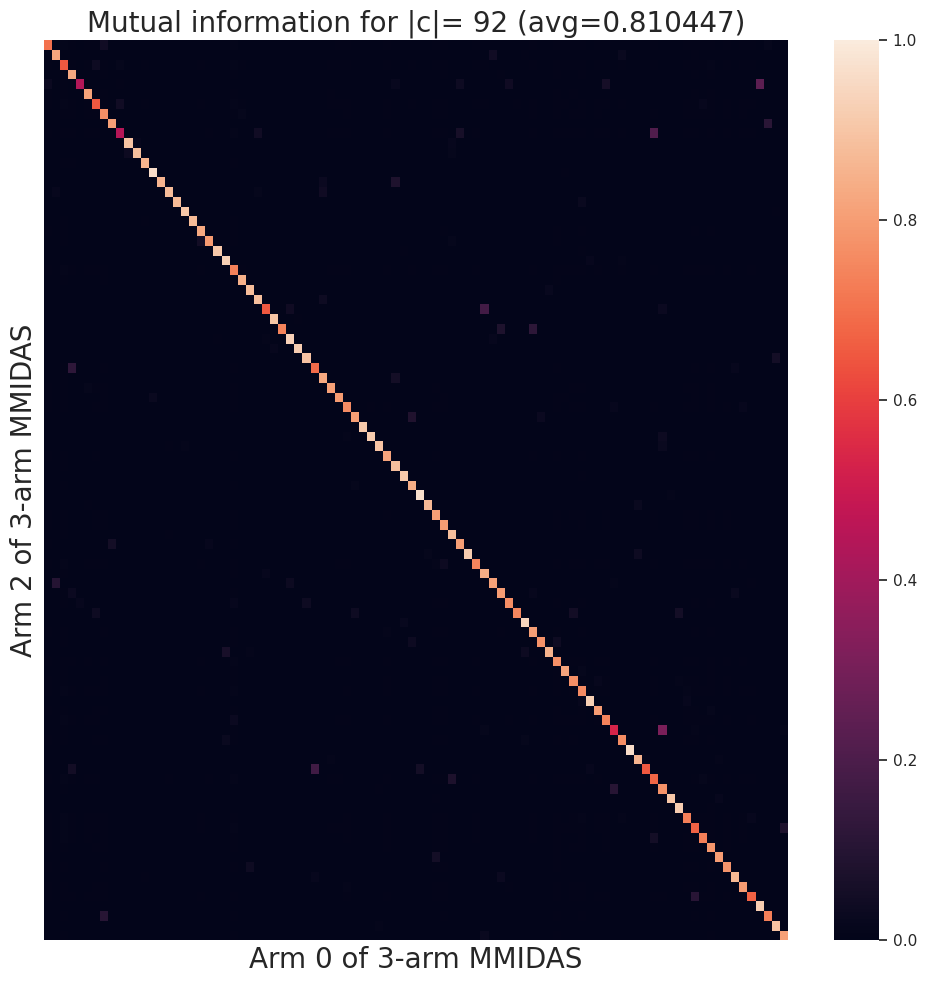

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.33it/s]


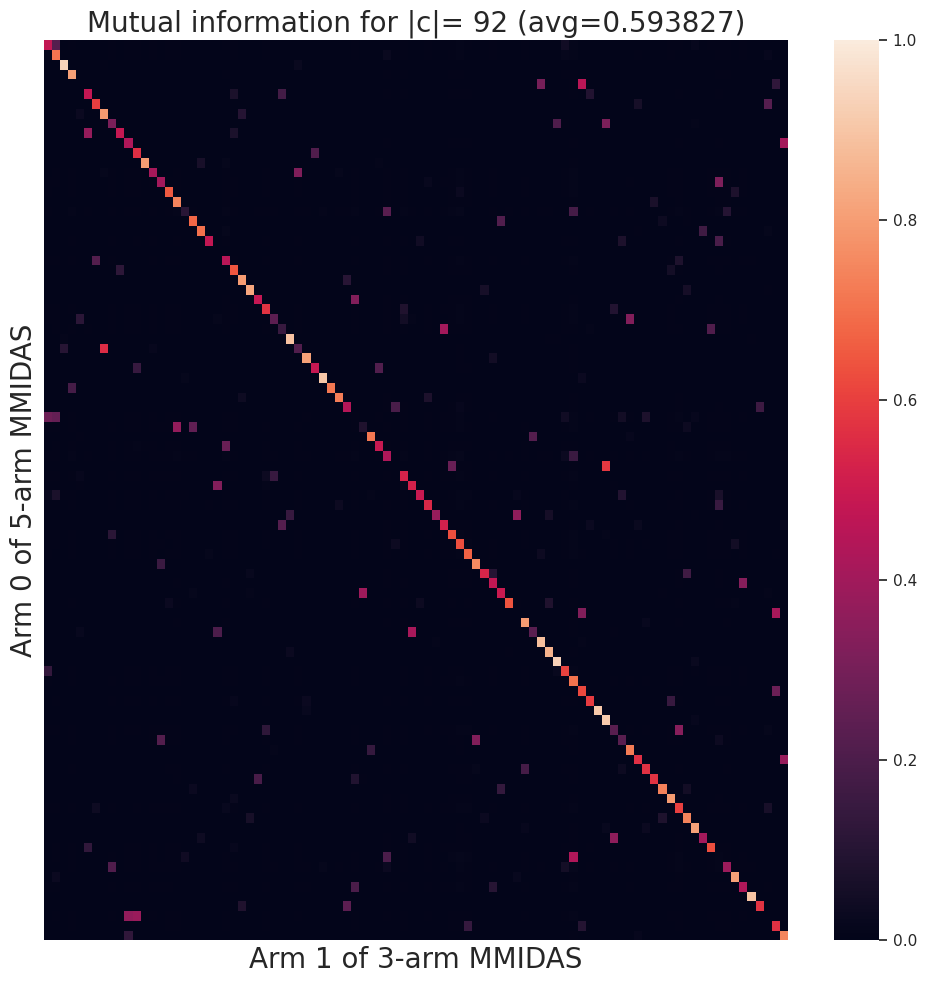

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.33it/s]


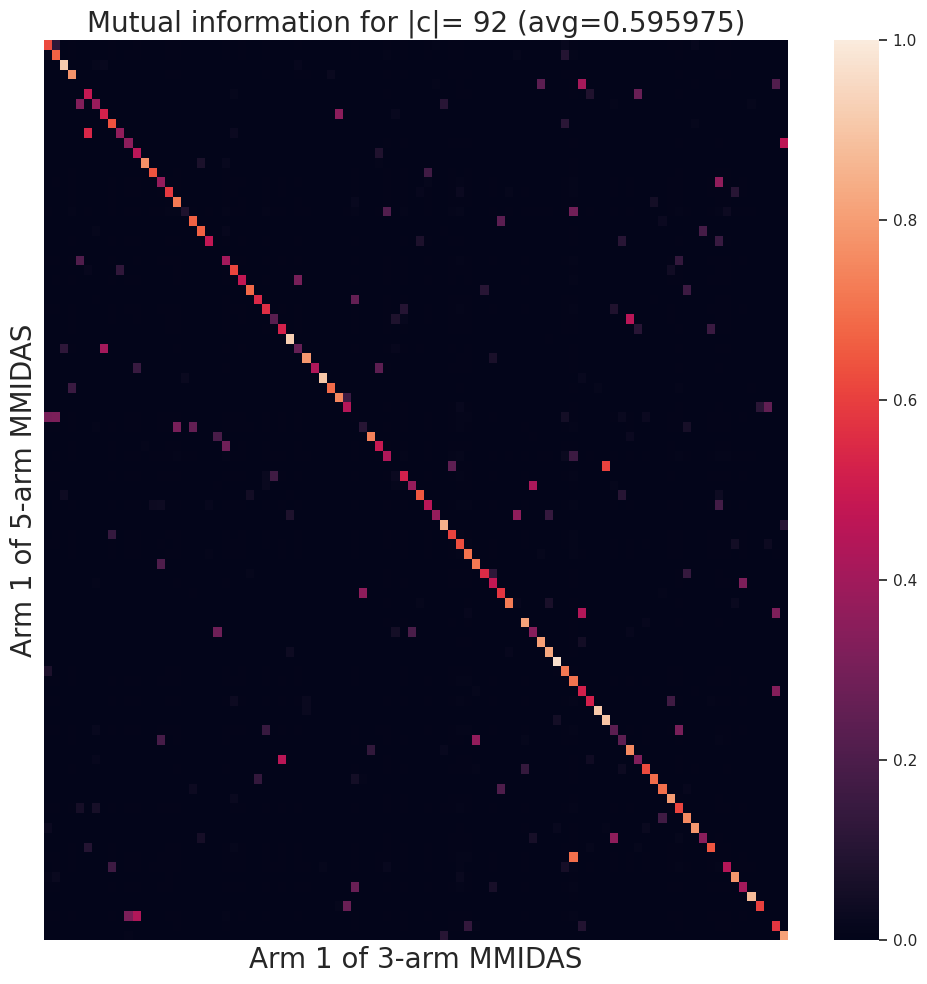

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.33it/s]


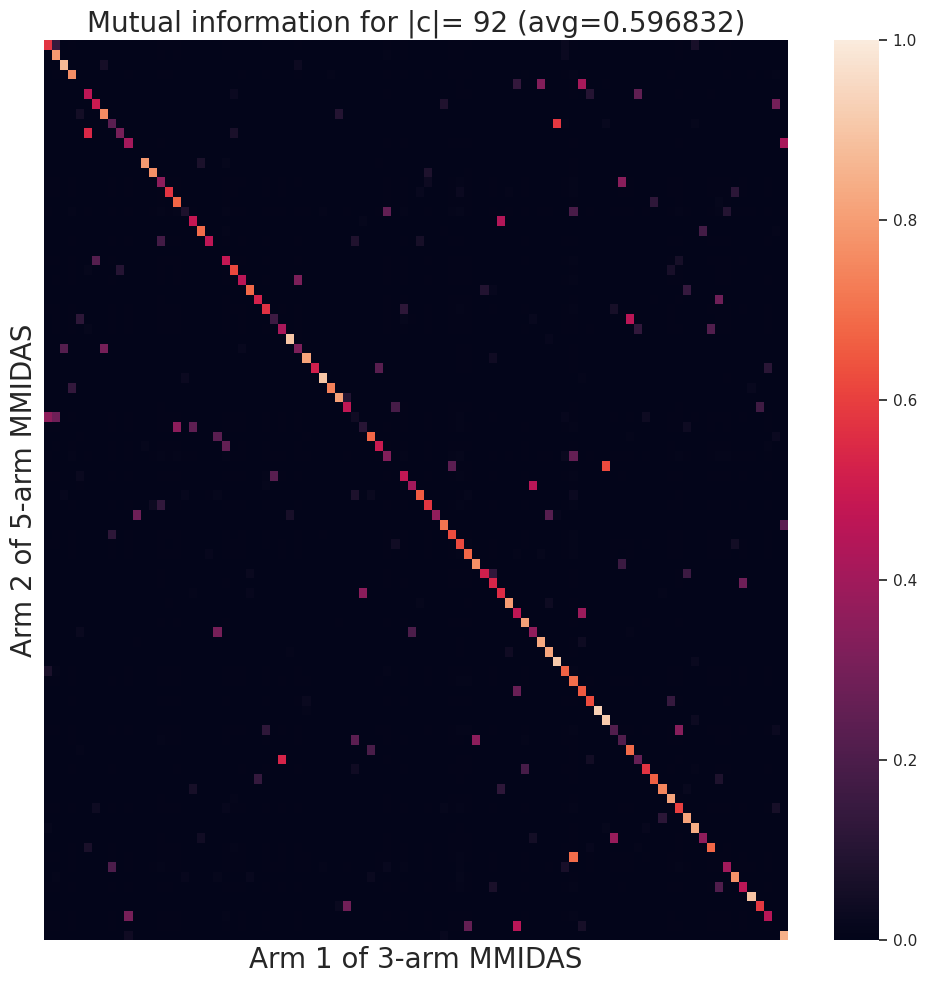

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:10<00:00,  1.30it/s]


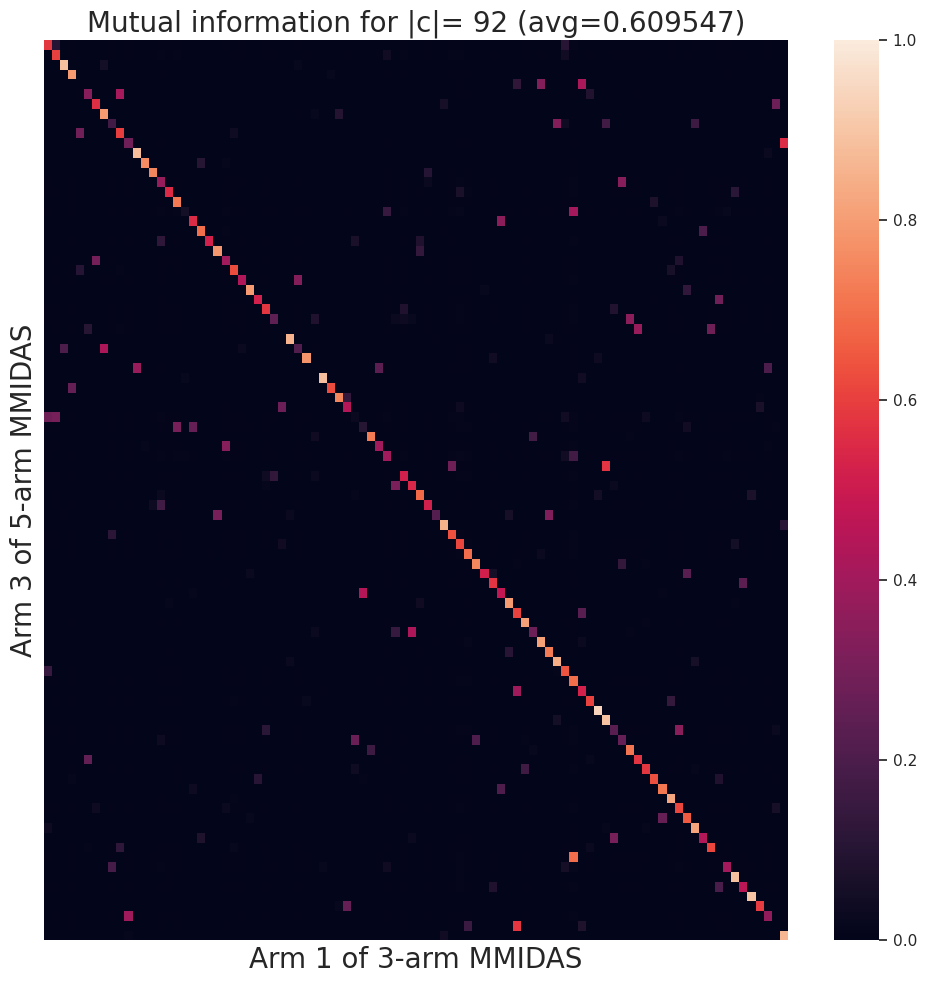

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.33it/s]


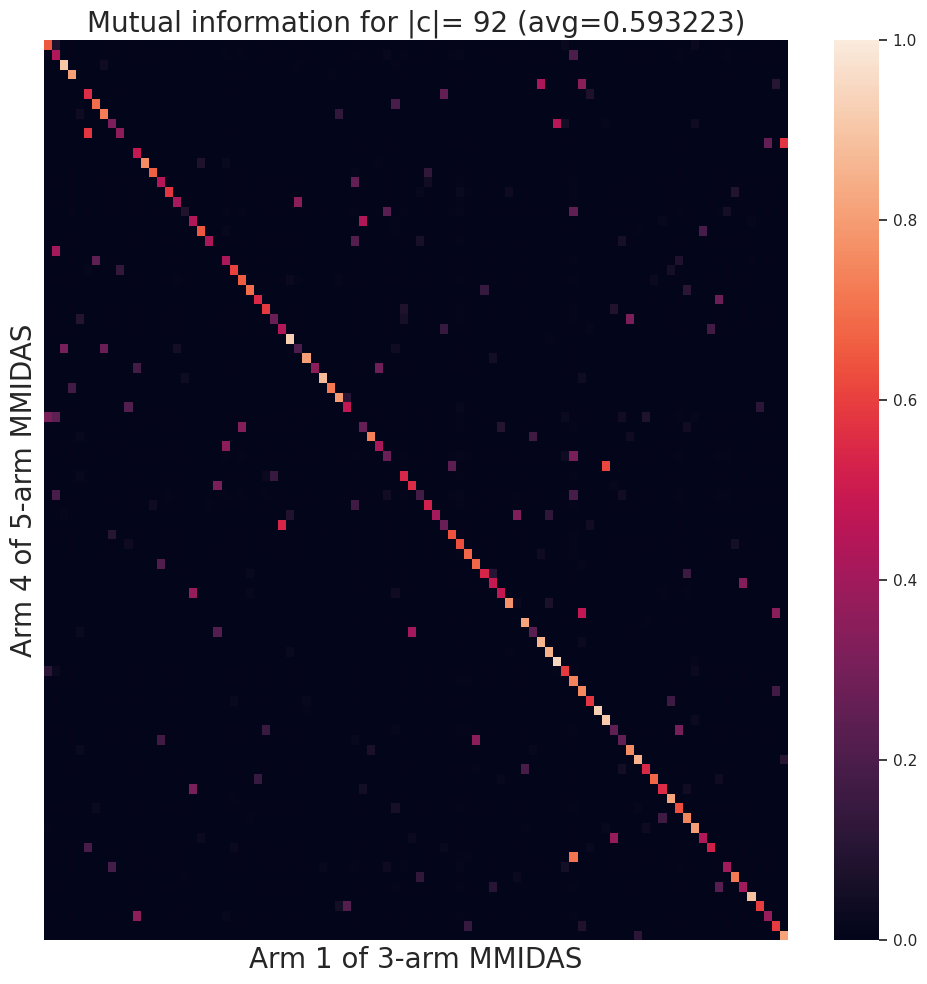

/tmp/ipykernel_85449/1143854957.py:53: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_a'][b]))
100%|██████████| 92/92 [01:10<00:00,  1.31it/s]


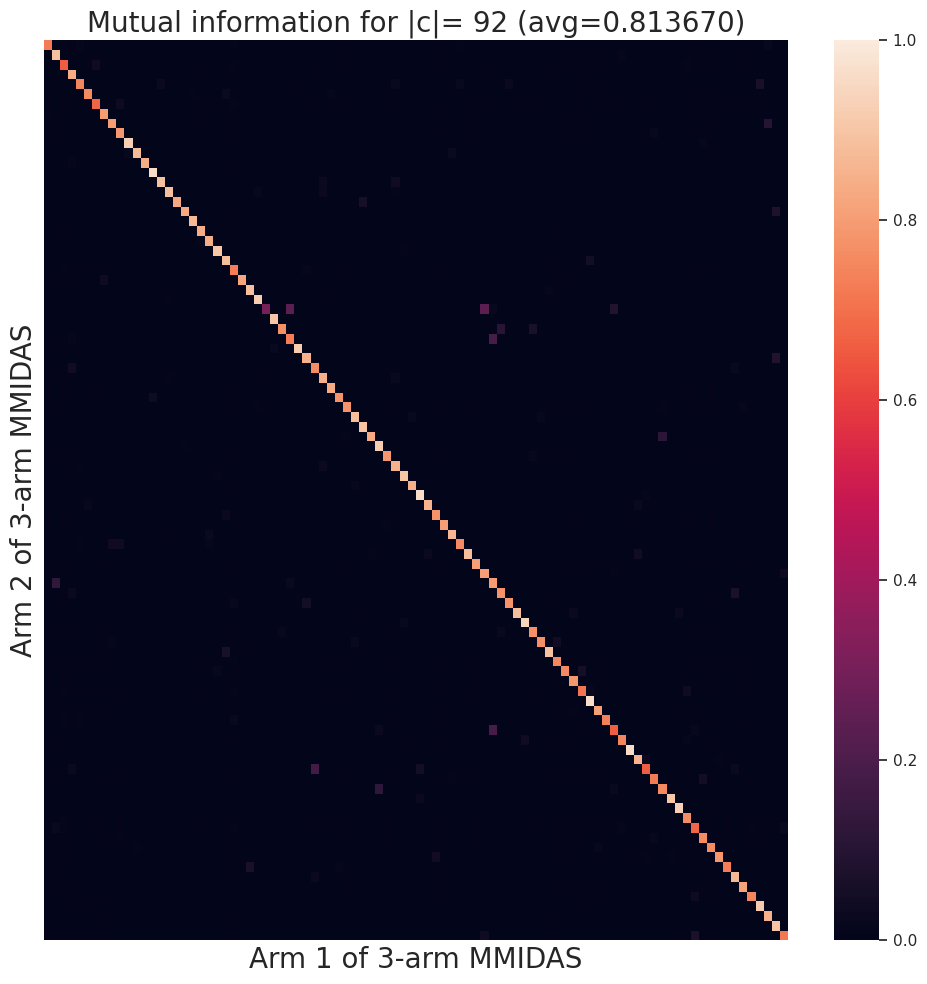

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:08<00:00,  1.34it/s]


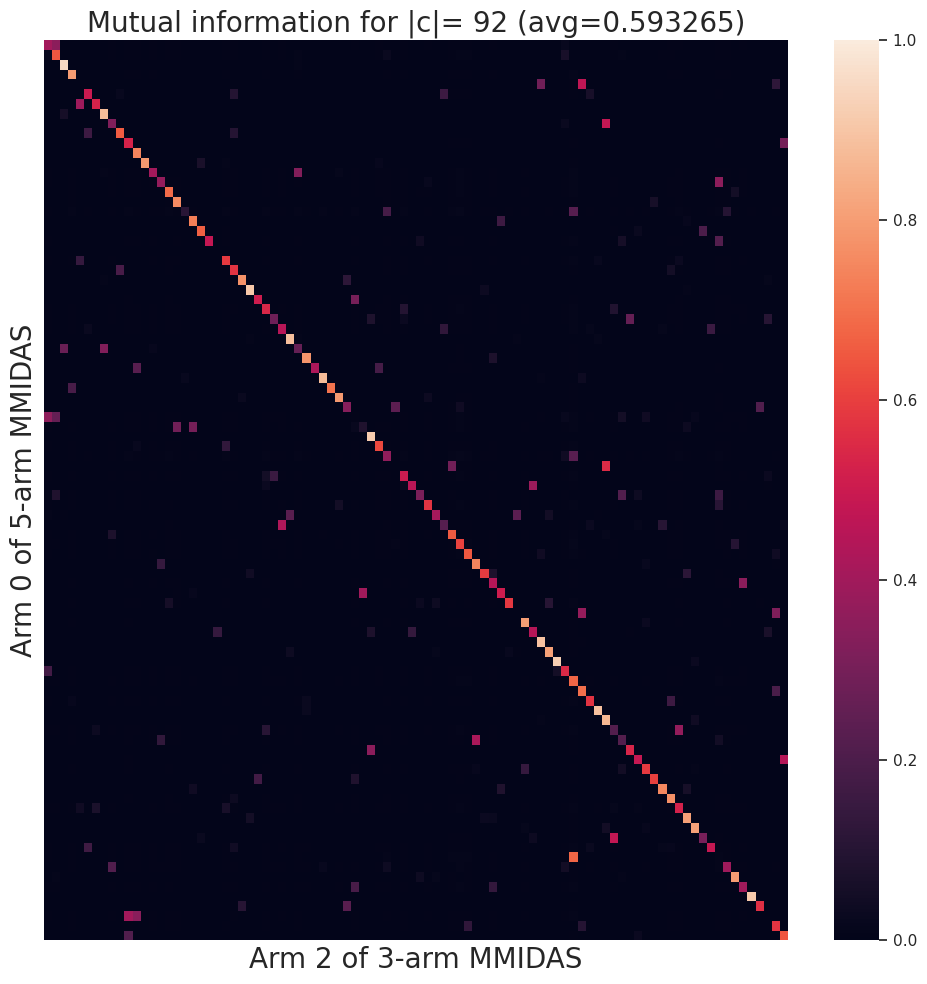

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:10<00:00,  1.30it/s]


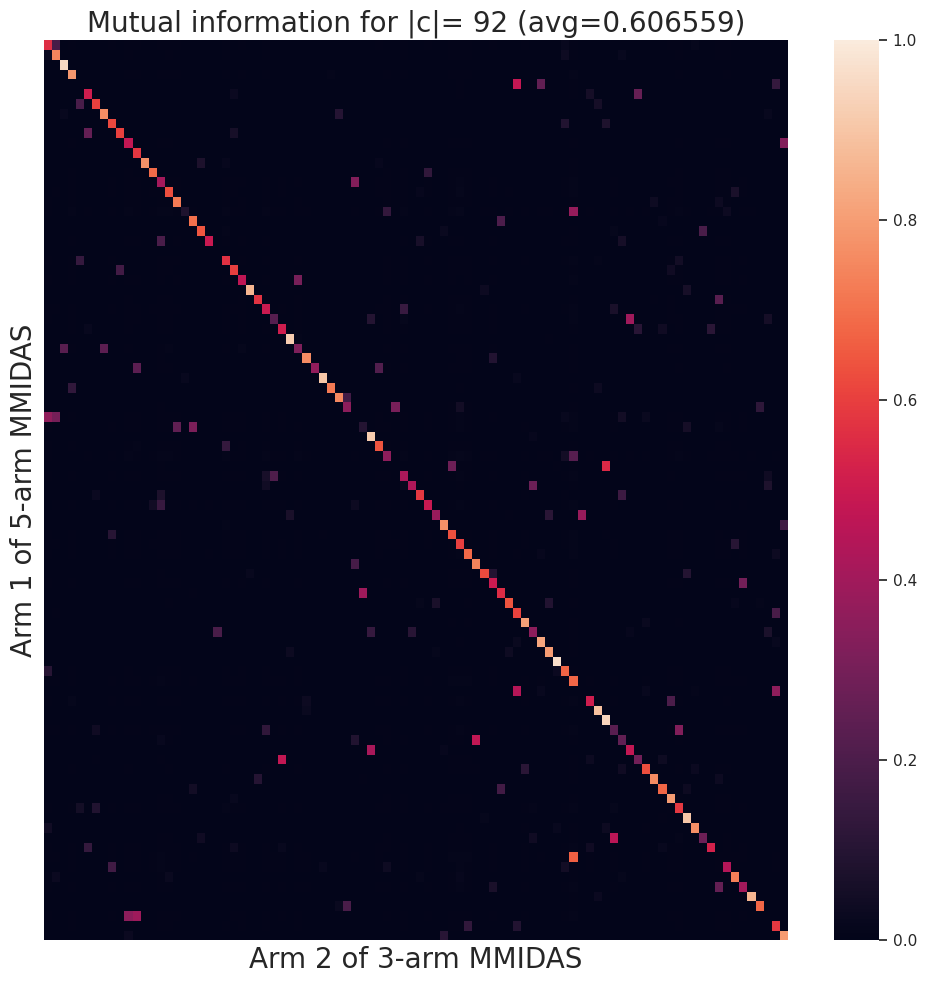

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:23<00:00,  1.10it/s]


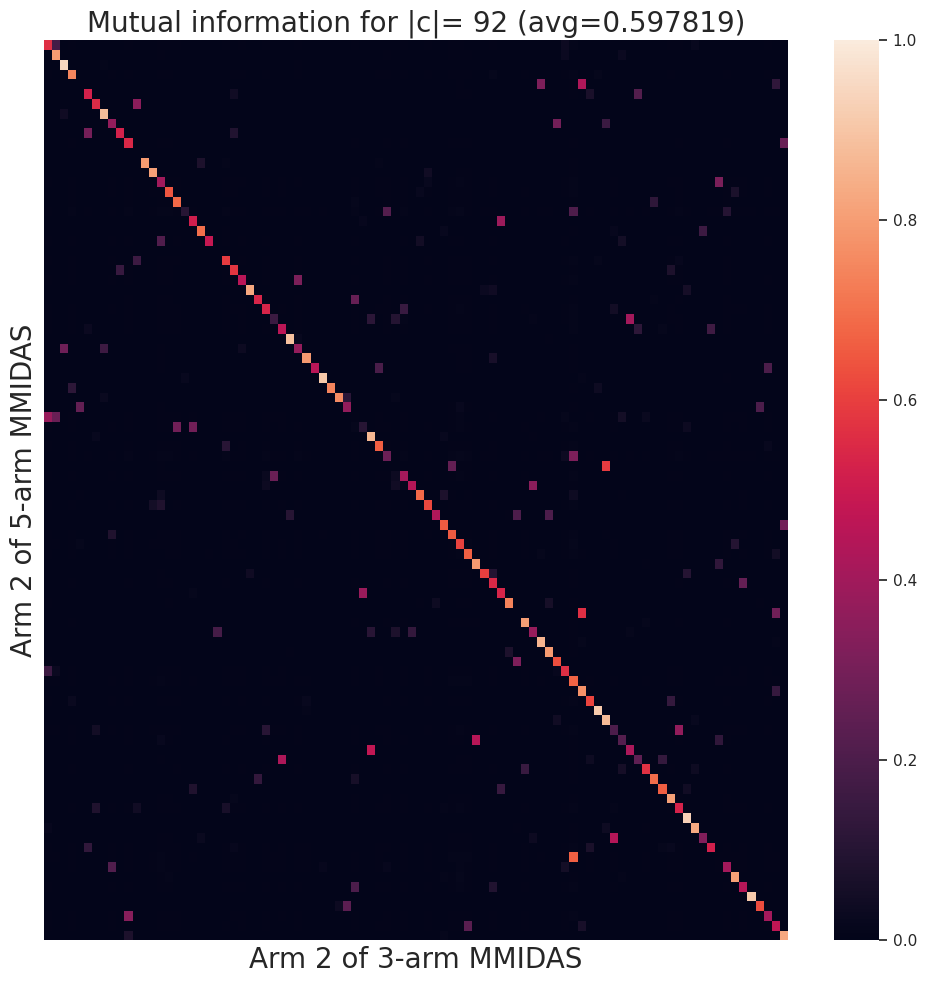

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.31it/s]


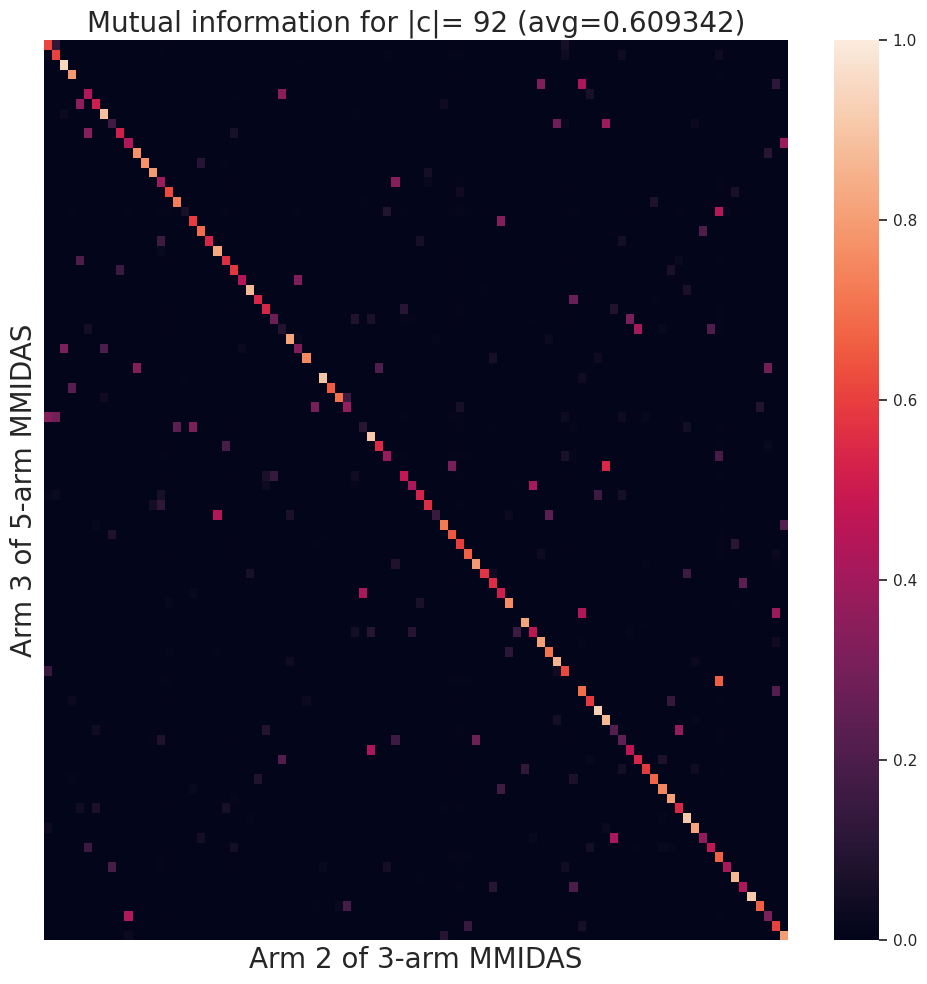

/tmp/ipykernel_85449/1143854957.py:48: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.32it/s]


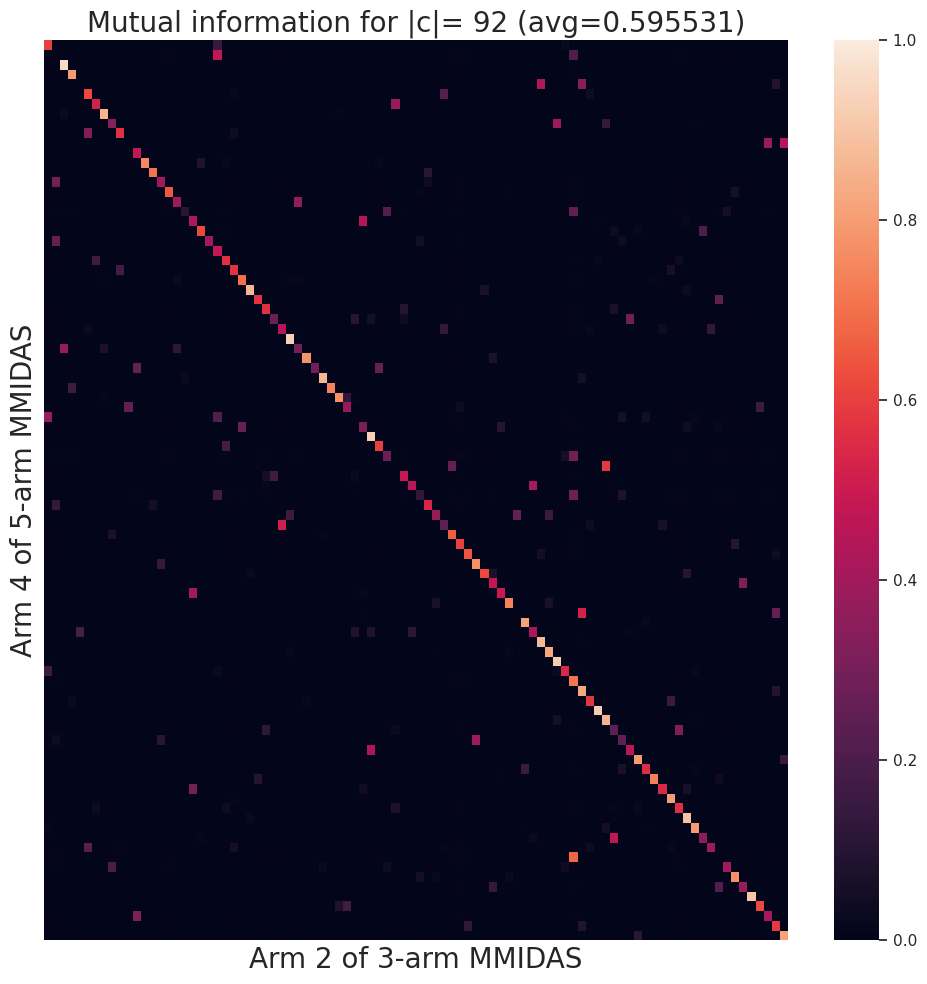

/tmp/ipykernel_85449/1143854957.py:59: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_b'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.32it/s]


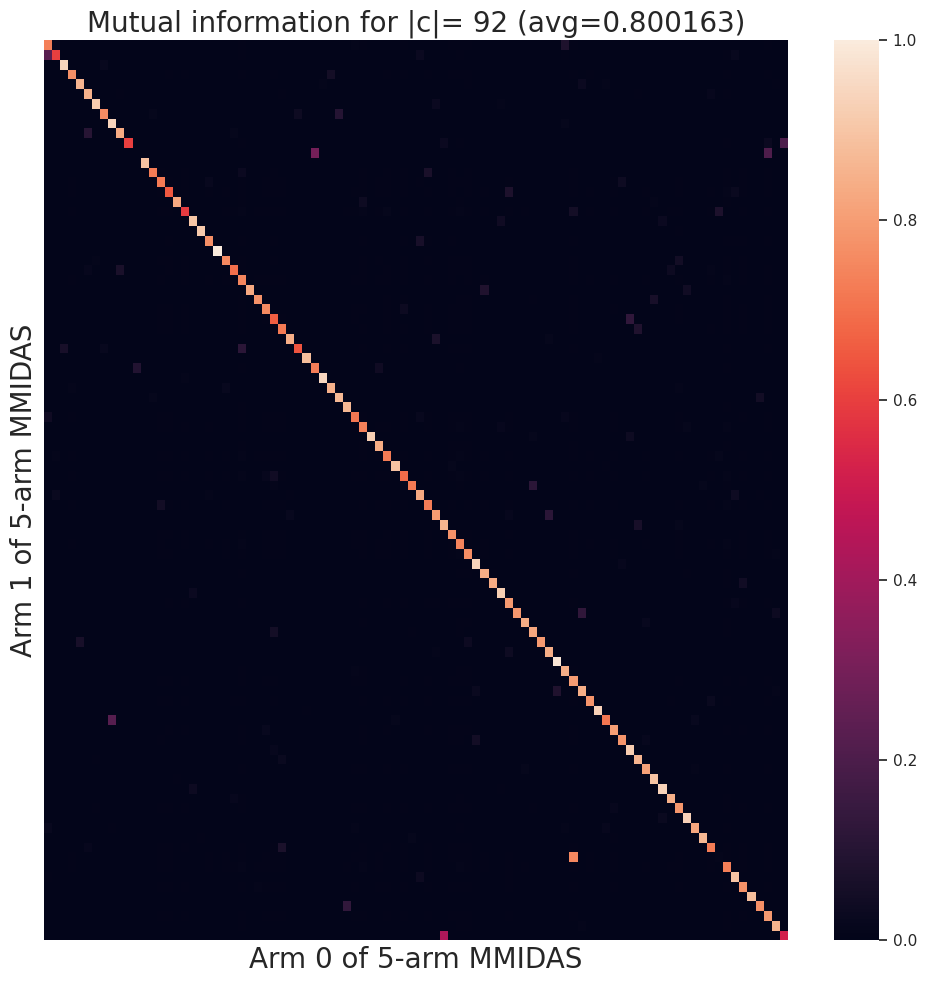

/tmp/ipykernel_85449/1143854957.py:59: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_b'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.33it/s]


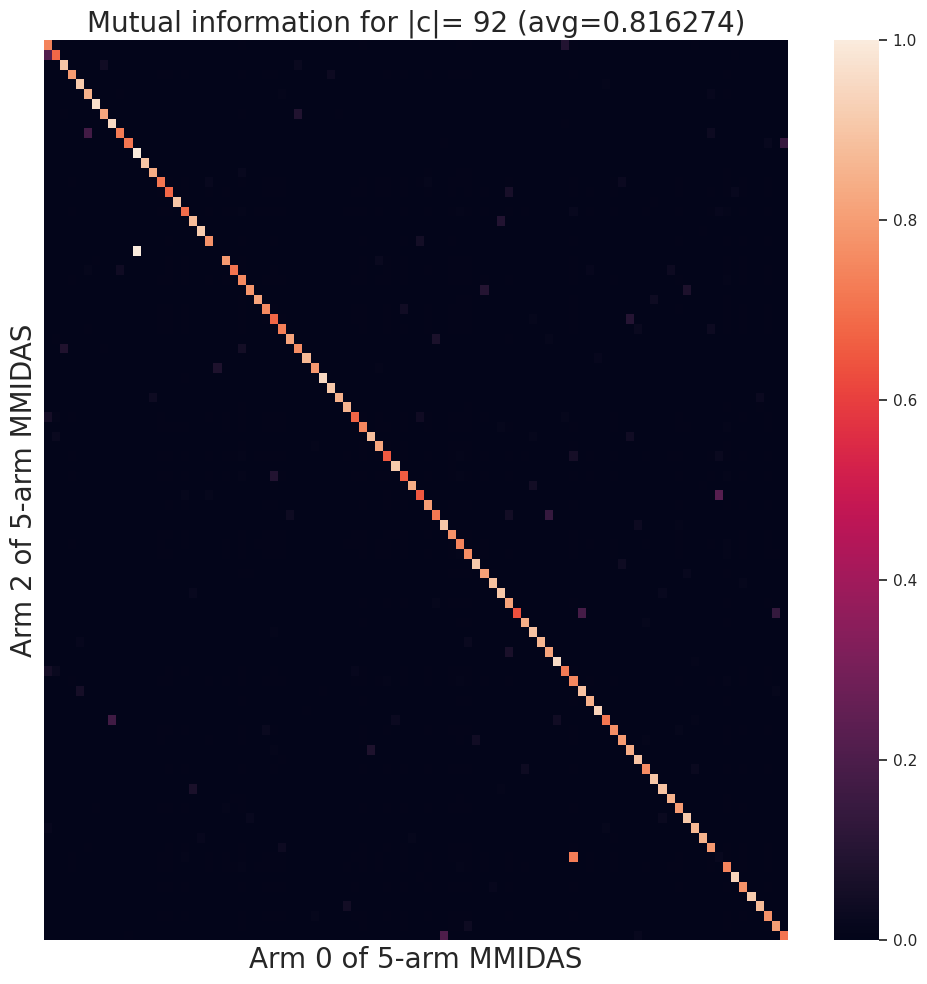

/tmp/ipykernel_85449/1143854957.py:59: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_b'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:08<00:00,  1.34it/s]


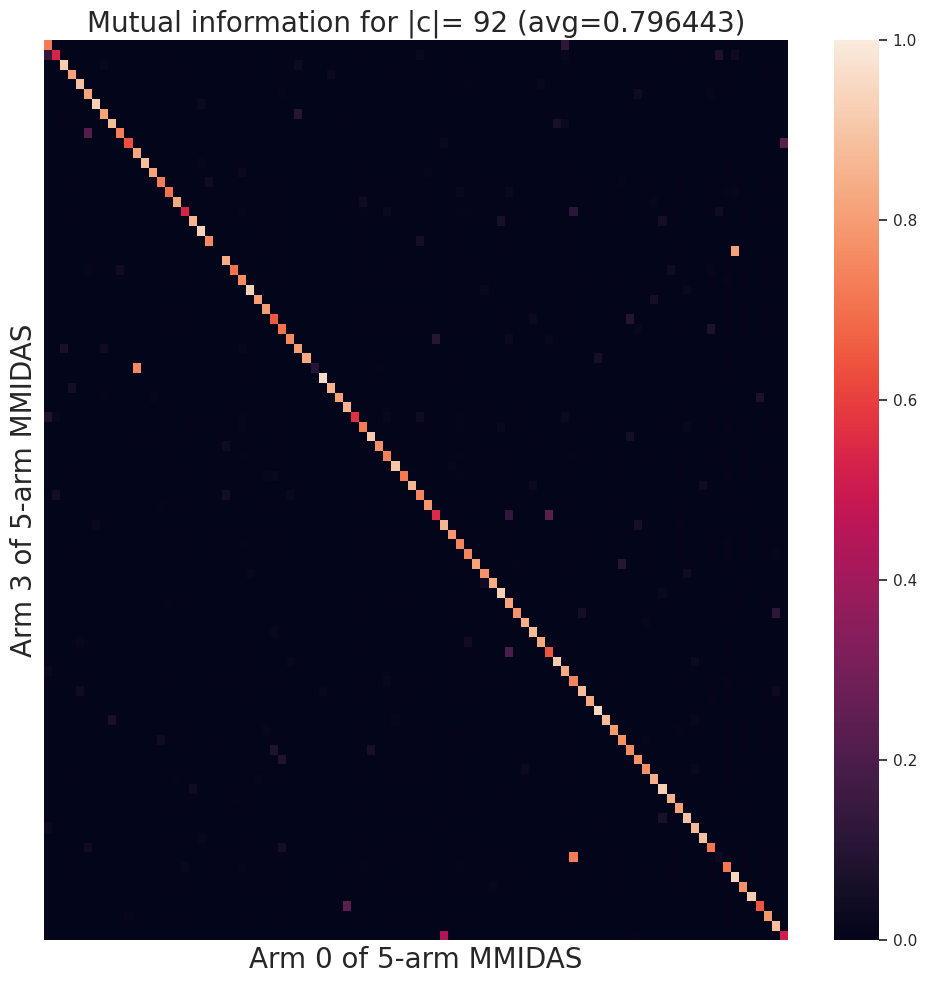

/tmp/ipykernel_85449/1143854957.py:59: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_b'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.33it/s]


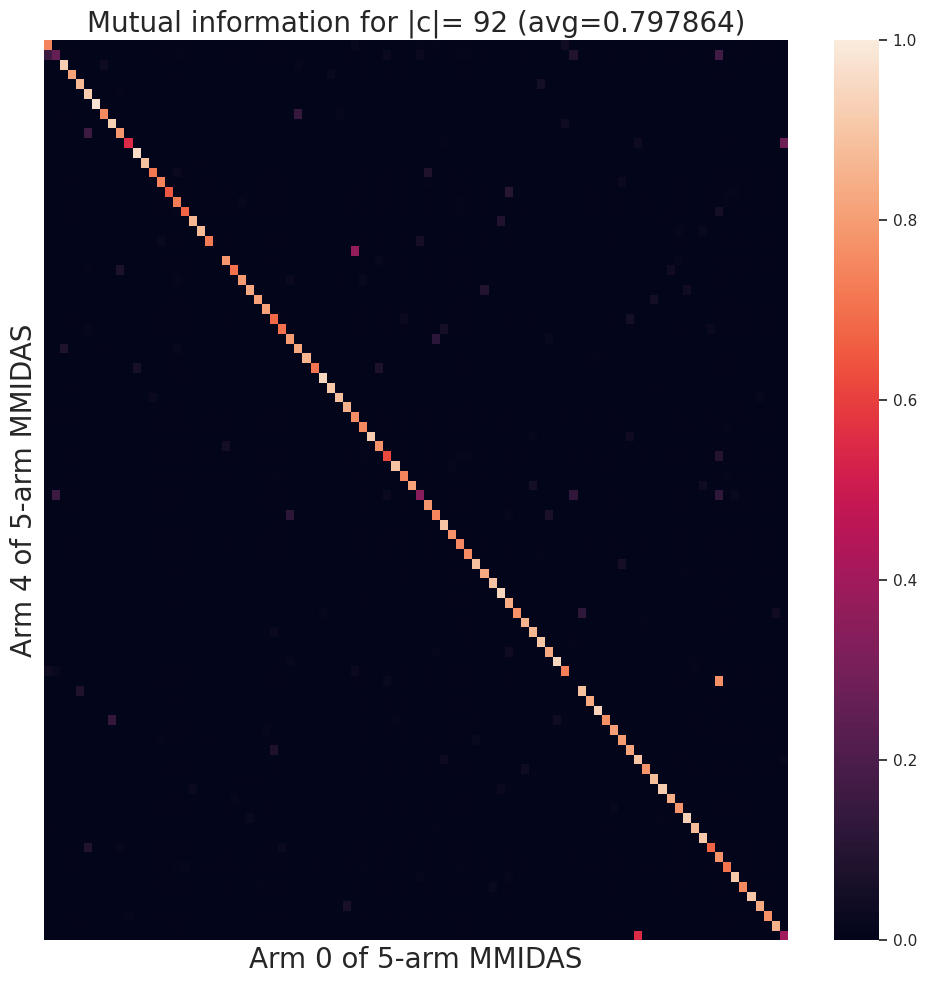

/tmp/ipykernel_85449/1143854957.py:59: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_b'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:08<00:00,  1.35it/s]


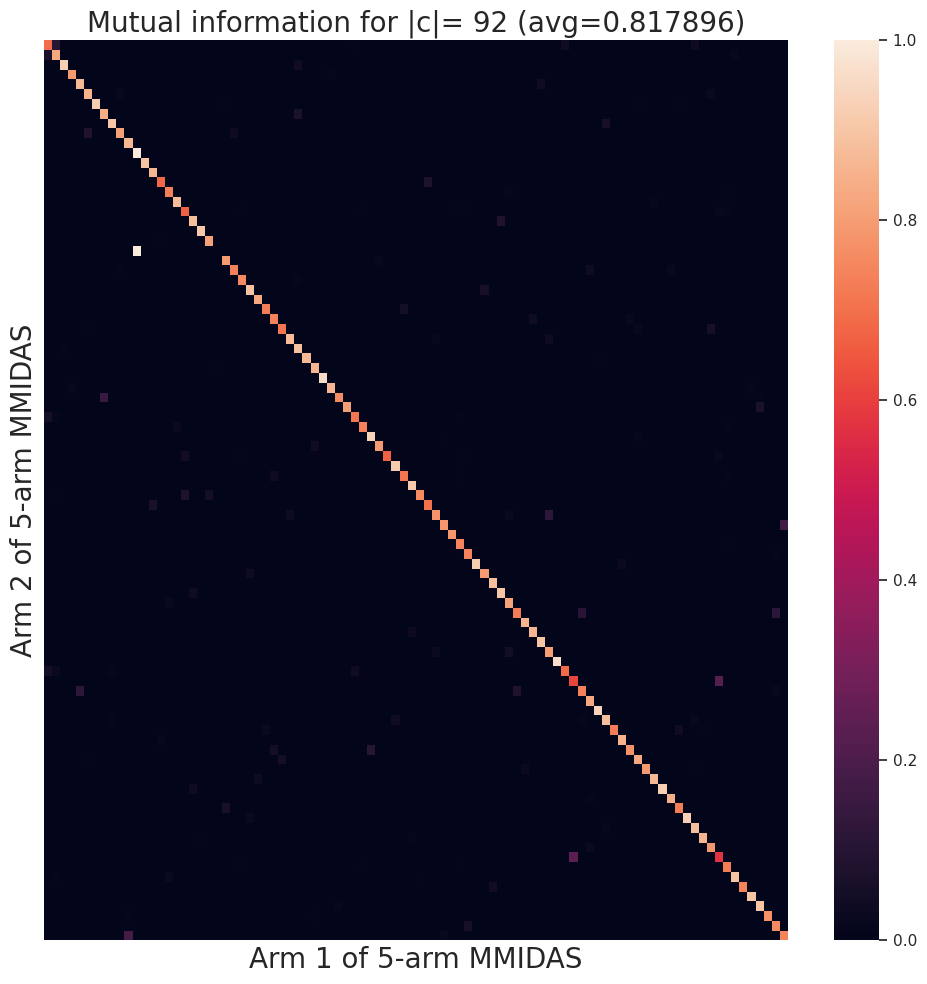

/tmp/ipykernel_85449/1143854957.py:59: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_b'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:10<00:00,  1.31it/s]


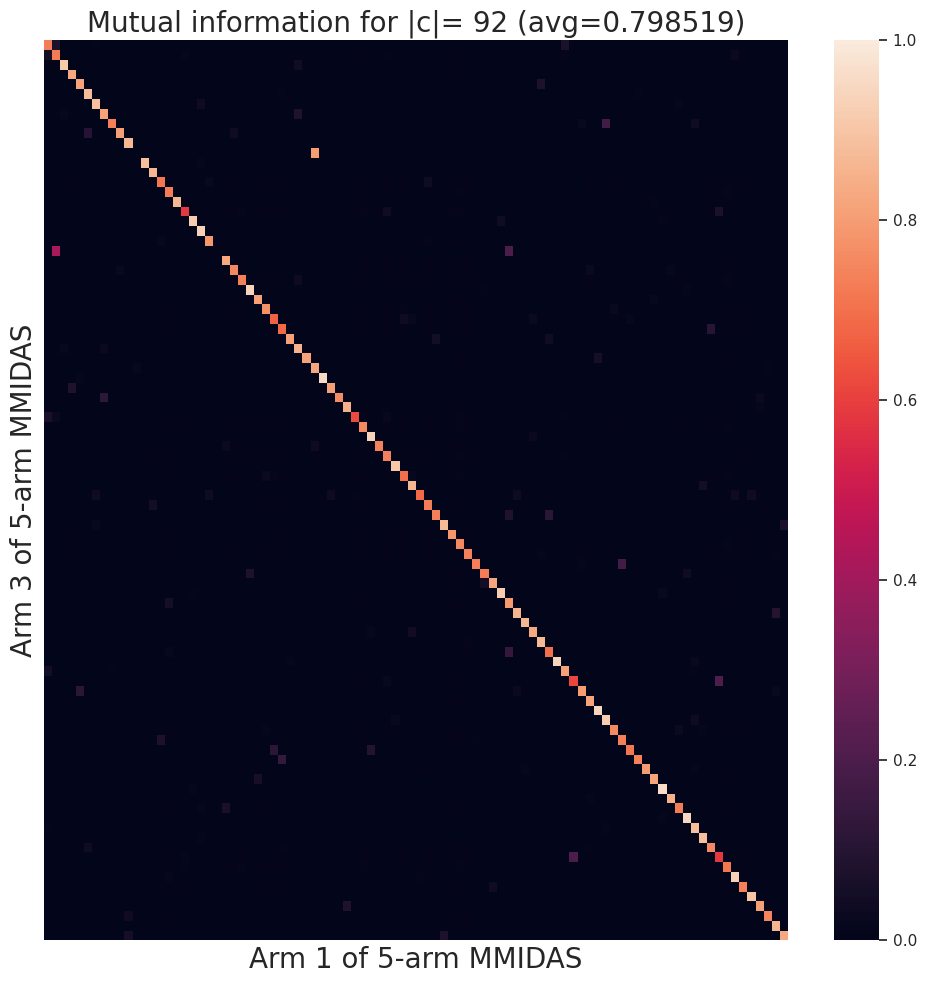

/tmp/ipykernel_85449/1143854957.py:59: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_b'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:10<00:00,  1.31it/s]


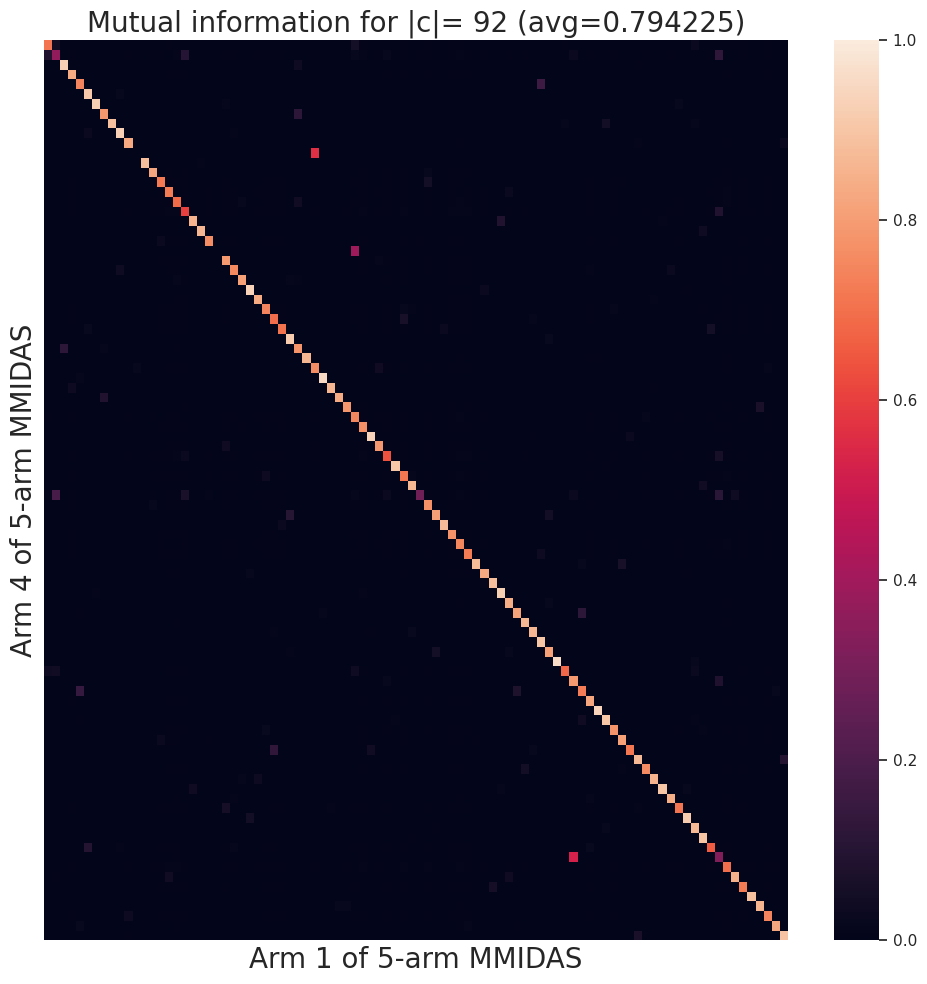

/tmp/ipykernel_85449/1143854957.py:59: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_b'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.33it/s]


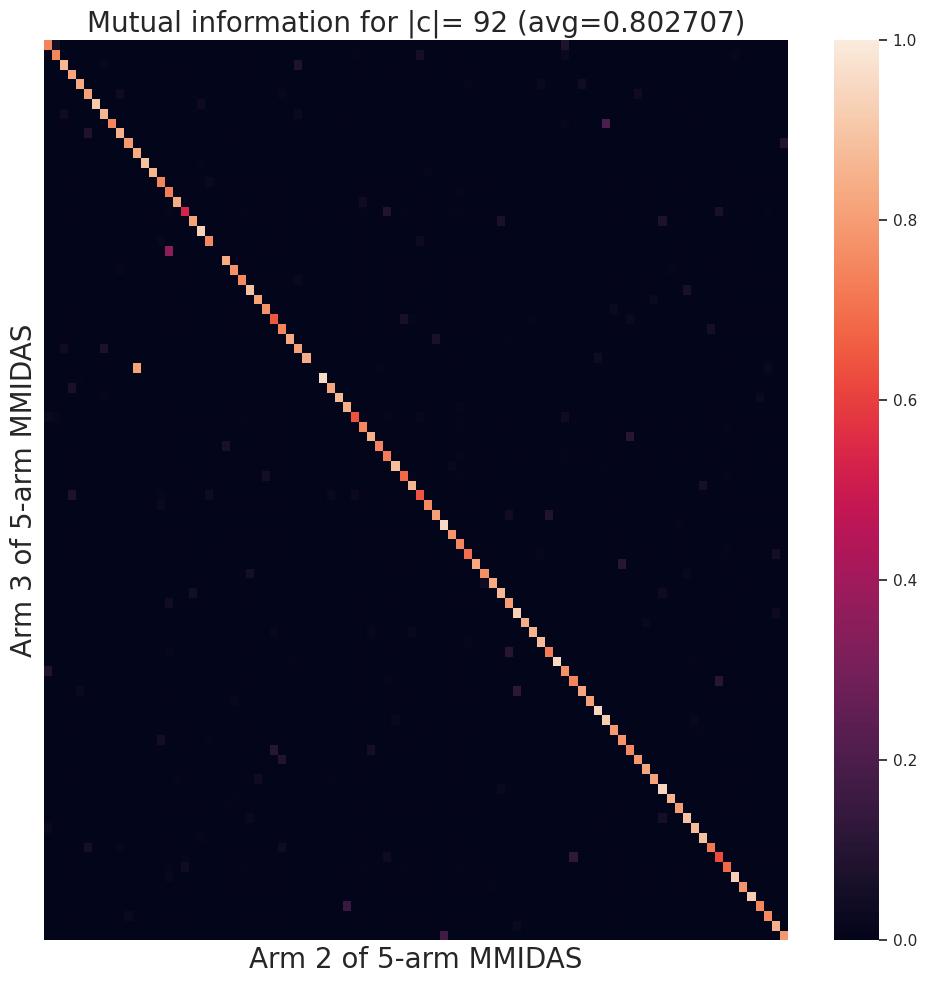

/tmp/ipykernel_85449/1143854957.py:59: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_b'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:09<00:00,  1.33it/s]


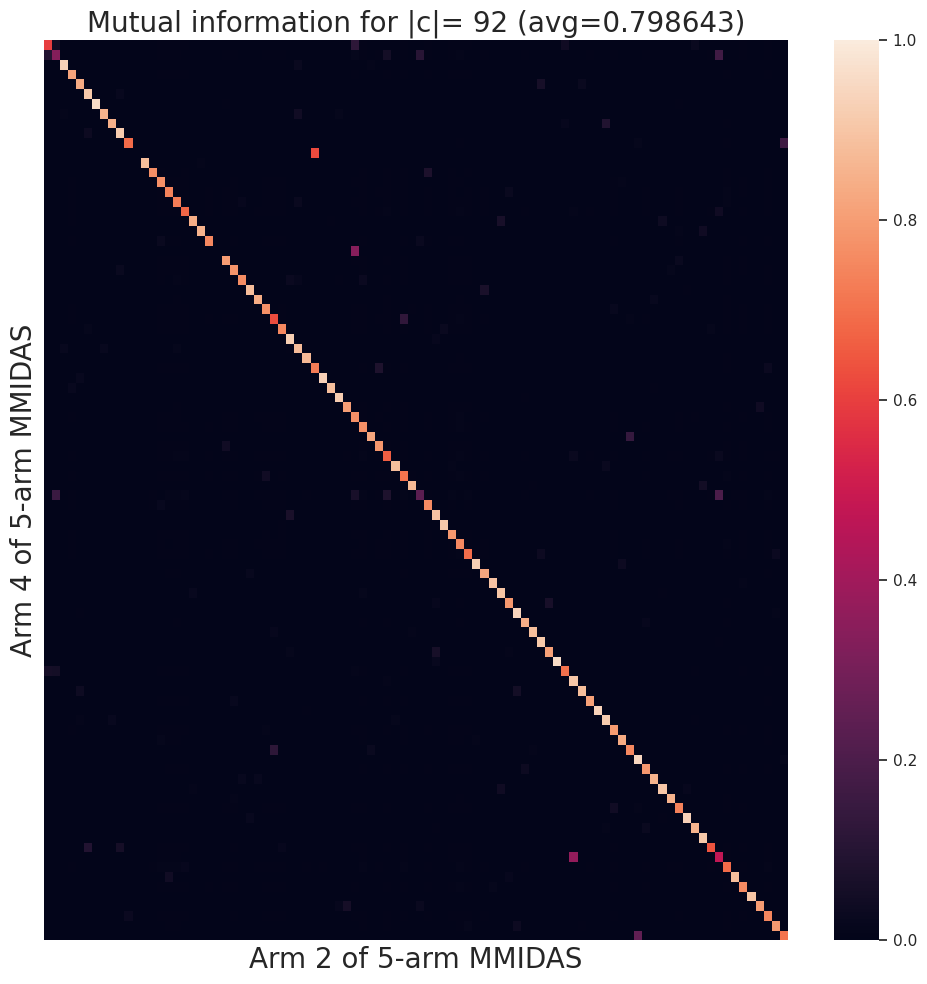

/tmp/ipykernel_85449/1143854957.py:59: FutureWarning: compute_mi() is unstable
  mi = compute_mi(ev['cs_b'][a], one_hot(ev['cs_b'][b]))
100%|██████████| 92/92 [01:10<00:00,  1.31it/s]


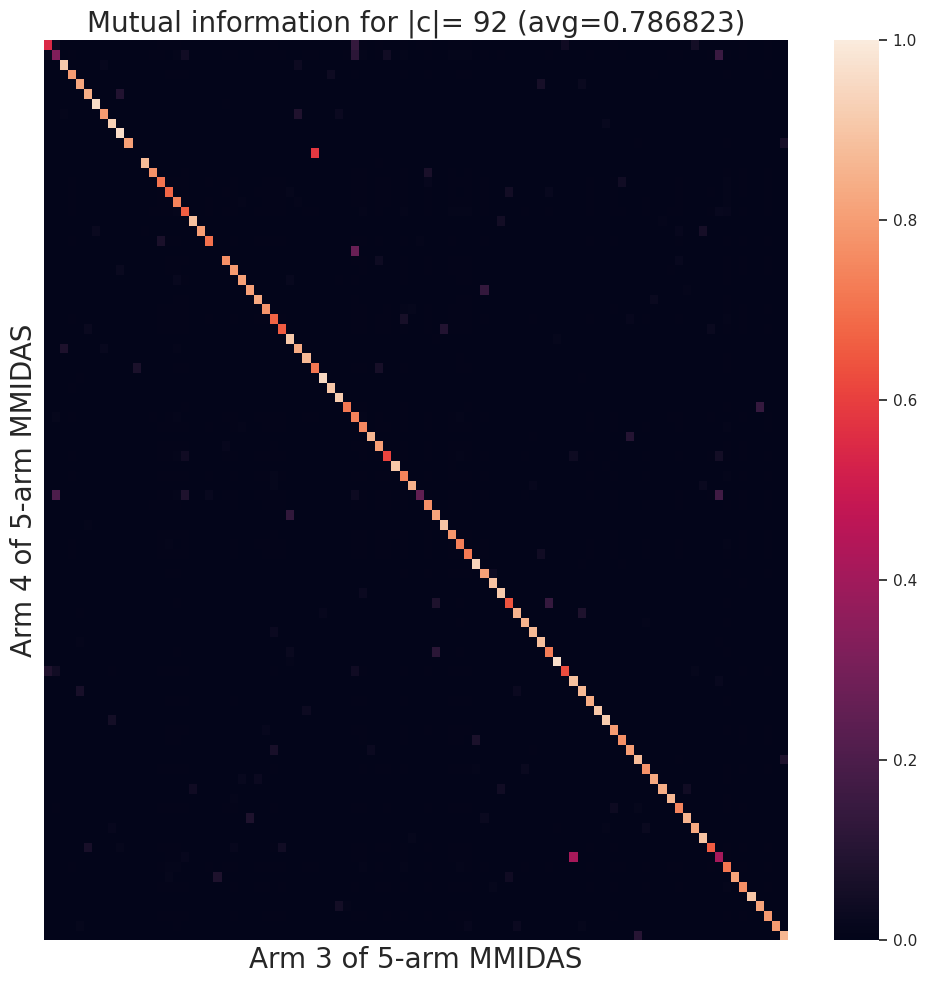

In [11]:
def one_hot(probs: np.ndarray) -> np.ndarray:
    return np.eye(probs.shape[-1])[np.argmax(probs, axis=-1)]

def avg_mi(xs: np.ndarray) -> float:
    return np.mean(np.max(xs, axis=-1)).item()

@unstable
def compute_mi(probs: np.ndarray, targets: np.ndarray) -> MI:
    C_pred = probs.shape[-1]
    C_target = targets.shape[-1]
    
    preds = np.argmax(probs, axis=-1)
    mi = np.zeros((C_target, C_pred))
    for c_p in trange(C_pred):
        for c_t in range(C_target):
            mi[c_t, c_p] = adjusted_mutual_info_score(targets[:, c_t], (preds == c_p).astype(int))
    return mi

def normalize_mi(mi: np.ndarray) -> np.ndarray:
    return normalize(mi, axis=1, norm='l1')

def plot_mi(mi: np.ndarray, axes: tuple[tuple[Arm, Arms], tuple[Arm, Arms]], xticks, yticks, savedir: Optional[str]) -> None:
    _, col_inds = linear_sum_assignment(-mi)

    fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=100)
    plt.title(f'Mutual information for |c|= {mi.shape[1]} (avg={avg_mi(mi):.6f})', fontsize=20)
    sns.set_theme(font_scale=1.)
    if xticks and yticks:
        sns.heatmap(mi[:, col_inds], xticklabels=xticks[col_inds], yticklabels=yticks, vmin=0, vmax=1, ax=ax, cbar_kws={'shrink': 1}) # pay attention to xticklabels
    else:
        sns.heatmap(mi[:, col_inds], vmin=0, vmax=1, ax=ax, cbar_kws={'shrink': 1})
    ax.set_xlabel(get_axis(axes[0]), fontsize=20)
    ax.set_xticks([])
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)
    ax.set_ylabel(get_axis(axes[1]), fontsize=20)
    ax.set_yticks(np.arange(len(yticks)))
    ax.set_yticklabels(yticks, fontsize=8)
    fig.tight_layout()
    if savedir:
        plt.savefig(savedir + f'/mutinfo_{get_axis_save(axes[0])}_vs_{get_axis_save(axes[1])}_K{mi.shape[1]}.png', dpi=300) # TODO
    plt.show()

so_far = 0
so_far_a = 0
so_far_b = 0
for a in range(A):
    for b in range(B):
        mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_b'][b]))
        plot_mi(normalize_mi(mi), ((a, A, None), (b, B, None)), [], [], f'multiarm-results/{A}{B}')
        so_far += 1
    
    for b in range(a + 1, A):
        mi = compute_mi(ev['cs_a'][a], one_hot(ev['cs_a'][b]))
        plot_mi(normalize_mi(mi), ((a, A, None), (b, A, None)), [], [], f'multiarm-results/{A}{B}')
        so_far_a += 1

for a in range(B):
    for b in range(a + 1, B):
        mi = compute_mi(ev['cs_b'][a], one_hot(ev['cs_b'][b]))
        plot_mi(normalize_mi(mi), ((a, B, None), (b, B, None)), [], [], f'multiarm-results/{A}{B}')
        so_far_b += 1

In [48]:
def plot_state():
    raise NotImplementedError
    _, data_index = all_loader.dataset.tensors
    data_index = data_index.numpy().astype(int)

    for arm in range(n_arm):
        print(arm)
        plt.close('all')
        fig = plt.figure(figsize=(5, 5))
        m_size = 3
        alp = .5
        fontsize = 18

        sns.set_theme()
        sns.set(rc={'axes.facecolor':'whitesmoke'})

        if state_dim== 1:
            axs = fig.add_subplot(1, 1, 1)
            axs.hist(outcome['state_mu'][arm][:, 0], 
                    color=data['cluster_color'][data_index], s=m_size, alpha=alp)
            axs.set_xlabel(f'T_s_{0}')
        elif state_dim == 2:
            axs = fig.add_subplot(1,1,1)
            axs.scatter(outcome['state_mu'][arm][:, 0], outcome['state_mu'][arm][:, 1],
                    color=data['cluster_color'][data_index], s=m_size, alpha=alp)
            axs.set_xlabel(r'$s_{T_1}$', fontsize=fontsize)
            axs.set_ylabel(r'$s_{T_2}$', fontsize=fontsize)
            axs.xaxis.set_tick_params(labelsize=10)
            axs.yaxis.set_tick_params(labelsize=10)
        elif state_dim == 3:
            axs = fig.add_subplot(1,1,1, projection='3d')
            axs.scatter(outcome['state_mu'][arm][:, 0],
                    outcome['state_mu'][arm][:, 1],
                    outcome['state_mu'][arm][:, 2],
                    color=data['cluster_color'][data_index], s=m_size, alpha=alp)
            axs.set_xlabel(f'T_s_{0}')
            axs.set_ylabel(f'T_s_{1}')
            axs.set_zlabel(f'T_s_{2}')

        axs.set_ylim([-2.5, 3])
        axs.set_xlim([-2.5, 2.5])
        axs.set_title(f'Continuous Representation (arm {arm+1})', fontsize=18, pad=15)
        axs.grid(False)
        fig.tight_layout()
        plt.savefig(saving_folder + f'/state_mu_K_{model_order}_arm_{arm}.png', dpi=600)
        plt.show()